# Gemma3-270M Fine-Tuning Using SFT

## Imports

In [1]:
!pip install transformers datasets torch peft
!pip install -q kagglehub
!pip install wandb

In [2]:
import wandb, os

import huggingface_hub
huggingface_hub.notebook_login()

try:
  from kaggle_secrets import UserSecretsClient
  user_secrets = UserSecretsClient()
  os.environ['KAGGLE_KEY'] = user_secrets.get_secret("KAGGLE_KEY")
  os.environ['KAGGLE_USERNAME'] = user_secrets.get_secret("KAGGLE_USERNAME")
  os.environ['WANDB_API_KEY'] = user_secrets.get_secret("WANDB_API_KEY")
except:
  try:
    from google.colab import userdata
    os.environ['KAGGLE_KEY'] = userdata.get("KAGGLE_KEY")
    os.environ['KAGGLE_USERNAME'] = userdata.get("KAGGLE_USERNAME")
    os.environ['WANDB_API_KEY'] = userdata.get("WANDB_API_KEY")
  except:
    print("Could't get secrets")

In [3]:
import os
import shutil
import torch

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the path to the Hugging Face cache directory
hf_cache_home = os.path.expanduser("~/.cache/huggingface/hub")

# Check if the cache directory exists and remove it
if os.path.exists(hf_cache_home):
    print(f"Clearing Hugging Face cache at: {hf_cache_home}")
    shutil.rmtree(hf_cache_home)
    print("Hugging Face cache cleared.")
else:
    print("Hugging Face cache directory not found, nothing to clear.")

!pip install transformers --upgrade

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import huggingface_hub

# Log in to Hugging Face (if not already logged in, this will prompt)
huggingface_hub.notebook_login()

model_id = "google/gemma-3-270m-it"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="cuda",
    trust_remote_code=True,
    attn_implementation="eager" # Explicitly use eager attention to avoid XLA issues
)

model.to(device)

print("Model and tokenizer loaded successfully.")

Hugging Face cache directory not found, nothing to clear.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Model and tokenizer loaded successfully.


In [4]:
from matplotlib import pyplot as plt

# Helper function to visualize performance during training
def plot_training_curves(train_losses, val_accuracies):
    """Plot training loss and validation accuracy curves.

    Parameters
    ----------
    train_losses : list of float
        Training loss values for each epoch. Should have one value per epoch.
    val_accuracies : list of float
        Validation accuracy values for each epoch. Should have same length as
        train_losses. Accuracy values should be between 0 and 1 (or 0 and 100
        if using percentages).

    Returns
    -------
    None
        Displays matplotlib figure with two subplots showing training curves.

    Examples
    --------
    >>> train_losses = [0.8, 0.6, 0.4, 0.3, 0.2]
    >>> val_accuracies = [0.75, 0.80, 0.85, 0.87, 0.88]
    >>> plot_training_curves(train_losses, val_accuracies)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(val_accuracies)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

## MATH dataset

In [5]:
from datasets import load_dataset

ds = load_dataset("qwedsacf/competition_math")
ds_split = ds['train'].train_test_split(test_size=0.10, seed=2025)

train_val_split = ds_split['train'].train_test_split(test_size=0.1111, seed=2025)

math_train = train_val_split['train']
math_val   = train_val_split['test']
math_test  = ds_split['test']

print("Train size:", len(math_train))
print("Val size:",   len(math_val))
print("Test size:",  len(math_test))

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-7320a6f3aba8eb(…):   0%|          | 0.00/4.85M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12500 [00:00<?, ? examples/s]

Train size: 10000
Val size: 1250
Test size: 1250


In [6]:
#Sample data
print(math_train[1])
print(math_train[2])
print(math_train[3])

{'problem': 'For how many integer values of $a$ does the equation $x^2 + ax + 5a = 0$ have integer solutions for $x$?', 'level': 'Level 5', 'type': 'Algebra', 'solution': "Suppose the roots of the quadratic are given by $m$ and $n$. Note that $$(x-m)(x-n) = x^2 - (m+n)x + mn = x^2 + ax + 5a,$$ and setting coefficients equal, it follows that  \\begin{align*}\nm + n &= -a \\\\\nmn &= 5a\n\\end{align*} (This also follows directly from Vieta's formulas.) Notice that the $a$ can be canceled by either dividing or noting that $$0 = 5a + 5 \\cdot (-a) = mn + 5(m+n).$$\n\nSimon's Favorite Factoring Trick can now be applied: $$mn + 5m + 5n + 25 = (m+5)(n+5) = 25.$$ It follows that $m+5$ and $n+5$ are divisors of $25$, whose pairs of divisors are given by $\\pm \\{(1,25),(5,5),(25,1)\\}$. Solving, we see that $(m,n)$ is in the set $$\\{(-4,20),(0,0),(20,-4),(-6,-30),(-10,-10),(-30,-6)\\}.$$ However, the two pairs of symmetric solutions yield redundant values for $a$, so it follows that the answer

The inspection of `math_train` entries confirmed the presence of numerous LaTeX commands and special characters such as `$`, `\`, `\begin{align*}` (and `\end{align*}`), `\\`, `\cdot`, `\ldots`, `\frac`, `\ge`, `\ge`, `\boxed`, `\binom`, `\times`, `\%`, and others. These need to be removed or replaced to make the text more readable and suitable for natural language processing tasks.

Now, let's create a cleaning function to handle these patterns. We'll start with a basic function and refine it as needed.

TODO: Cleaning MATH dataset

In [7]:
import json
import re
from typing import Dict, Any, Optional

# ============================================
# STEP 1: BASIC CLEANING
# ============================================

def clean_text(text: str) -> str:
    """Basic whitespace normalization."""
    if not text:
        return ""

    # Normalize whitespace
    text = re.sub(r'[ \t]+', ' ', text)
    text = re.sub(r'\n\s*\n\s*\n+', '\n\n', text)

    # Clean up lines
    lines = text.split('\n')
    lines = [line.strip() for line in lines]
    text = '\n'.join(lines)

    return text.strip()

def add_cleaned_fields(data):
    """Add cleaned_problem and cleaned_solution fields to dataset."""
    for record in data:
        record['cleaned_problem'] = clean_text(record.get('problem', ''))
        record['cleaned_solution'] = clean_text(record.get('solution', ''))
    return data


# ============================================
# STEP 2: ANSWER EXTRACTION
# ============================================

def extract_answer(text: str) -> Optional[str]:
    """
    Extract final answer from solution text.
    Priority order:
        1. \\boxed{...} - standard competition math format
        2. Final Answer: ... - explicit format
        3. Last number in text - fallback only
    """
    if not text:
        return None

    # 1. Extract from \boxed{...} - HIGHEST PRIORITY
    # Use a more sophisticated approach to handle nested braces
    boxed_content = extract_boxed_content(text)
    if boxed_content:
        answer = clean_answer_text(boxed_content)
        if answer:
            return answer

    # 2. Extract from "Final Answer:" pattern
    final_answer_pattern = r'[Ff]inal [Aa]nswer[:\s]+(.+?)(?:\n|$)'
    final_matches = re.findall(final_answer_pattern, text)
    if final_matches:
        answer = clean_answer_text(final_matches[-1])
        if answer:
            return answer

    # 3. Look for answer after common phrases
    answer_phrases = [
        r'[Tt]he answer is[:\s]+(.+?)(?:\.|$)',
        r'[Tt]herefore[,\s]+(.+?)(?:\.|$)',
        r'[Ss]o[,\s]+the (?:number|answer|value)[^:]*:[:\s]+(.+?)(?:\.|$)',
    ]

    for pattern in answer_phrases:
        matches = re.findall(pattern, text)
        if matches:
            answer = clean_answer_text(matches[-1])
            if answer:
                return answer

    # 4. LAST RESORT: Find last number-like pattern
    # Split by sentences/lines to get context
    sentences = re.split(r'[.\n]', text)
    for sentence in reversed(sentences):
        # Look for standalone numbers or simple expressions
        number_patterns = [
            r'\$([^$]+)\$',  # Math mode
            r'(-?\d+(?:\.\d+)?(?:/\d+)?)',  # Simple numbers/fractions
        ]

        for pattern in number_patterns:
            matches = re.findall(pattern, sentence)
            if matches:
                answer = clean_answer_text(matches[-1])
                if answer:
                    return answer

    return None


def extract_boxed_content(text: str) -> Optional[str]:
    """
    Extract content from \\boxed{...} handling nested braces correctly.
    Returns the content of the LAST \\boxed{} in the text.
    """
    # Find all \boxed{ positions
    pattern = r'\\boxed\{'
    matches = list(re.finditer(pattern, text))

    if not matches:
        return None

    # Process from the last match backwards
    for match in reversed(matches):
        start = match.end()  # Start after the opening brace
        brace_count = 1
        i = start

        # Find matching closing brace
        while i < len(text) and brace_count > 0:
            char = text[i]

            # Skip escaped braces
            if i > 0 and text[i-1] == '\\':
                i += 1
                continue

            if char == '{':
                brace_count += 1
            elif char == '}':
                brace_count -= 1
            i += 1

        if brace_count == 0:
            # Successfully found matching brace
            content = text[start:i-1]
            return content.strip()

    return None


def clean_answer_text(text: str) -> str:
    """Clean extracted answer text - preserve LaTeX commands."""
    if not text:
        return ""

    text = text.strip()

    # Remove outer dollar signs only
    text = re.sub(r'^\$+', '', text)
    text = re.sub(r'\$+$', '', text)

    # Clean whitespace but preserve structure
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove trailing punctuation (but not mathematical operators)
    text = re.sub(r'[.,;!?]+$', '', text)

    # Remove any closing $ that might be left
    text = text.rstrip('$')

    return text


def extract_numeric_answer(text: str) -> Optional[str]:
    """
    Extract purely numeric answer (integers, decimals, fractions).
    Use this for problems expecting numeric answers only.
    """
    answer = extract_answer(text)
    if not answer:
        return None

    # Try to extract numeric value from answer
    # Handle fractions
    frac_match = re.search(r'\\frac\{(-?\d+)\}\{(-?\d+)\}', answer)
    if frac_match:
        num, den = frac_match.groups()
        return f"{num}/{den}"

    # Handle simple fractions
    simple_frac = re.search(r'(-?\d+)/(-?\d+)', answer)
    if simple_frac:
        return simple_frac.group(0)

    # Handle exponents
    exp_match = re.search(r'(-?\d+)\^?\{?(-?\d+)\}?', answer)
    if exp_match and '^' in answer:
        base, exp = exp_match.groups()
        return f"{base}^{exp}"

    # Handle decimals and integers
    num_match = re.search(r'-?\d+(?:\.\d+)?', answer)
    if num_match:
        return num_match.group(0)

    # Return original cleaned answer if no numeric pattern found
    return answer

# ============================================
# STEP 2b: EXTRACT REASONING
# ============================================

def extract_reasoning(text: str) -> str:
    """Extract everything before the final answer."""
    if not text:
        return ""

    # Split at Final Answer
    match = re.split(r'[Ff]inal [Aa]nswer[:\s]+', text)
    if len(match) > 1:
        return match[0].strip()

    # Try splitting before a boxed answer
    boxed_match = re.split(r'\\boxed\{', text)
    if len(boxed_match) > 1:
        return boxed_match[0].strip()

    # Fallback: return all but last 1–2 lines
    lines = text.strip().split("\n")
    if len(lines) > 2:
        return "\n".join(lines[:-2]).strip()

    return text.strip()


# ============================================
# STEP 3: ADD FINAL ANSWER TO SOLUTIONS
# ============================================

def reformat_solution(record: Dict[str, Any]) -> Dict[str, Any]:
    """Add 'Final Answer: X' to cleaned_solution."""
    solution = record.get('cleaned_solution', '')

    # Extract answer
    final = extract_answer(solution)

    if final is None:
        # If no answer found, try to extract from original solution
        final = extract_answer(record.get('solution', ''))

    if final is None:
        # Fallback: mark as unable to extract
        final = "[UNABLE_TO_EXTRACT]"

    # Check if "Final Answer:" already exists
    if not re.search(r'[Ff]inal [Aa]nswer:', solution):
        record['cleaned_solution'] = solution + f"\n\nFinal Answer: {final}"

    record["final_answer"] = extract_answer(solution) or "[UNABLE]"
    record["cleaned_reasoning"] = extract_reasoning(solution)

    return record


# ============================================
# MAIN PROCESSING PIPELINE
# ============================================

def process_example(example):
    # 1. Clean problem+solution
    cleaned_problem = clean_text(example.get("problem", ""))
    cleaned_solution = clean_text(example.get("solution", ""))

    # 2. Add cleaned fields
    example["cleaned_problem"] = cleaned_problem
    example["cleaned_solution"] = cleaned_solution

    # 3. Extract answer and attach "Final Answer:"
    example = reformat_solution(example)

    return example

# ============================================
# TESTING UTILITIES
# ============================================

def test_extraction(test_cases = [
        ("The answer is $\\boxed{42}$", "42"),
        ("Therefore, we get $\\boxed{2^{2008} - 2}$", "2^{2008} - 2"),
        ("Final Answer: 17", "17"),
        ("So the value is \\frac{3}{4}.", "3/4"),
        ("The result is -15.", "-15"),
    ]):
    """Test answer extraction on common formats."""

    print("\n" + "="*60)
    print("Testing Answer Extraction:")
    print("="*60)

    for text, expected in test_cases:
        extracted = extract_answer(text)
        status = "✓" if extracted == expected else "✗"
        print(f"{status} Input: {text[:50]}...")
        print(f"  Expected: {expected}")
        print(f"  Got: {extracted}")
        print()

# Uncomment to run tests
#test_extraction([(" The answer is, as you can see, \frac{1}{5} because", fix_latex("\frac{1}{5}")),(math_train[1]["solution"],"4"), (math_train[2]["solution"],"2^{2008} -2"), (math_train[0]["solution"],"\sqrt{10}"), (math_train[3]["solution"], "\frac{5}{8}")])

In [8]:
#applying to training/testing splits
math_train = math_train.map(process_example, desc="Cleaning train split")
math_val   = math_val.map(process_example, desc="Cleaning val split")
math_test  = math_test.map(process_example, desc="Cleaning test split")


print("Cleaning applied to math_train, math_test and math_val datasets.")
print("Sample of math_train after cleaning:")
print(math_train[0]['problem'])
print(math_train[0]['cleaned_problem'])
print(math_train[0]['solution'])
print(math_train[0]['cleaned_solution'])

Cleaning train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Cleaning val split:   0%|          | 0/1250 [00:00<?, ? examples/s]

Cleaning test split:   0%|          | 0/1250 [00:00<?, ? examples/s]

Cleaning applied to math_train, math_test and math_val datasets.
Sample of math_train after cleaning:
What is the distance between the two intersections of $y=x^2$ and $x+y=1$?
What is the distance between the two intersections of $y=x^2$ and $x+y=1$?
To find the $x$-coordinates of the intersections, substitute $x^2$ for $y$ in $x+y=1$ and solve for $x$, resulting in  \begin{align*}
x+x^2&=1 \\
\Rightarrow \qquad x^2+x-1&=0 \\
\Rightarrow \qquad x&=\frac{-1\pm\sqrt{1+4}}2=\frac{-1\pm\sqrt5}2\\
\end{align*}Using each of these coordinates to solve for $y$ gives us the intersections at $\left(\frac{-1+\sqrt5}2,\frac{3-\sqrt5}2\right)$ and $\left(\frac{-1-\sqrt5}2,\frac{3+\sqrt5}2\right)$.  Using the distance formula, we have \begin{align*}
&\sqrt{ \left(\frac{-1+\sqrt5}{2}-\frac{-1-\sqrt5}{2}\right)^2 + \left(\frac{3-\sqrt5}2-\frac{3+\sqrt5}2\right)^2 }\\
&\qquad=\sqrt{\left(\frac{2\sqrt5}2\right)^2 + \left(-\frac{2\sqrt5}2\right)^2}\\
&\qquad=\sqrt{ 2\sqrt5^2 }\\
&\qquad=\boxed{\sqrt{10}

In [9]:
math_train[0]

{'problem': 'What is the distance between the two intersections of $y=x^2$ and $x+y=1$?',
 'level': 'Level 5',
 'type': 'Algebra',
 'solution': 'To find the $x$-coordinates of the intersections, substitute $x^2$ for $y$ in $x+y=1$ and solve for $x$, resulting in  \\begin{align*}\nx+x^2&=1 \\\\\n\\Rightarrow \\qquad x^2+x-1&=0 \\\\\n\\Rightarrow \\qquad x&=\\frac{-1\\pm\\sqrt{1+4}}2=\\frac{-1\\pm\\sqrt5}2\\\\\n\\end{align*}Using each of these coordinates to solve for $y$ gives us the intersections at $\\left(\\frac{-1+\\sqrt5}2,\\frac{3-\\sqrt5}2\\right)$ and $\\left(\\frac{-1-\\sqrt5}2,\\frac{3+\\sqrt5}2\\right)$.  Using the distance formula, we have \\begin{align*}\n&\\sqrt{ \\left(\\frac{-1+\\sqrt5}{2}-\\frac{-1-\\sqrt5}{2}\\right)^2 + \\left(\\frac{3-\\sqrt5}2-\\frac{3+\\sqrt5}2\\right)^2 }\\\\\n&\\qquad=\\sqrt{\\left(\\frac{2\\sqrt5}2\\right)^2 + \\left(-\\frac{2\\sqrt5}2\\right)^2}\\\\\n&\\qquad=\\sqrt{ 2\\sqrt5^2 }\\\\\n&\\qquad=\\boxed{\\sqrt{10}}.\n\\end{align*}',
 'cleaned_pro

## Training Utility Functions

In [10]:
def format_math(example, tokenizer):
    """Format example for training with proper label masking.

    Args:
        example: Dictionary with 'cleaned_problem' and 'cleaned_solution' keys
        tokenizer: HuggingFace tokenizer

    Returns:
        Dictionary with 'input_ids', 'attention_mask', and 'labels'
        Labels are -100 for question tokens (ignored in loss) and
        actual token IDs for answer tokens.
    """
    prompt_template = """Solve the math problem; show your work in a 'Reasoning:' section (LaTeX is allowed) in strictly 2-4 sentences.

You MUST finish with a single line that starts exactly with:

Final Answer:
<final numeric answer only — no LaTeX, no text>

Question:
{question}

Reasoning:
"""
    question_text = prompt_template.format(question=example['cleaned_problem'])
    answer_text = f"{example['cleaned_solution']}"

    # Tokenize question and answer separately
    question_tokens = tokenizer(question_text, add_special_tokens=True, truncation=True,max_length=1024)
    answer_tokens = tokenizer(answer_text, add_special_tokens=False, truncation=True,max_length=1024)

    # Combine
    input_ids = question_tokens['input_ids'] + answer_tokens['input_ids']
    attention_mask = question_tokens['attention_mask'] + answer_tokens['attention_mask']

    # Create labels: -100 for question (ignored), actual tokens for answer
    labels = [-100] * len(question_tokens['input_ids']) + answer_tokens['input_ids']

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

# Example:
print(f"First Question Tokenized: {tokenizer(math_train[0]['cleaned_problem'], add_special_tokens=True)}")
print()
print(f"First Answer Tokenized: {tokenizer(math_train[0]['cleaned_solution'], add_special_tokens=True)}")
print()
example_formatted = format_math(math_train[0], tokenizer)
print(f"Combined tokenized input: {example_formatted['input_ids']}")
print()
print(f"Prediction targets/labels: {example_formatted['labels']}")

First Question Tokenized: {'input_ids': [2, 3689, 563, 506, 5149, 1534, 506, 1156, 69811, 529, 609, 236762, 236784, 236781, 236884, 236778, 236795, 532, 609, 236781, 236862, 236762, 236784, 236770, 223680], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

First Answer Tokenized: {'input_ids': [2, 2021, 1586, 506, 609, 236781, 4624, 56220, 529, 506, 69811, 236764, 22784, 609, 236781, 236884, 236778, 236795, 573, 609, 236762, 236795, 528, 609, 236781, 236862, 236762, 236784, 236770, 236795, 532, 8974, 573, 609, 236781, 2500, 9113, 528, 621, 1906, 236782, 7341, 9774, 107, 236781, 236862, 236781, 236884, 236778, 36412, 236770, 1704, 107, 236785, 13676, 621, 38453, 1123, 236884, 236778, 236862, 236781, 236772, 236770, 36412, 236771, 1704, 107, 236785, 13676, 621, 38453, 1123, 70812, 1420, 17960, 236770, 236785, 3840, 236785, 4784, 236782, 236770, 236862, 236812, 1807, 236778, 1631, 1420, 17960, 236770, 236785, 3840, 236785, 4784, 236810, 236783

In [11]:
import tqdm
import torch
from difflib import SequenceMatcher

def eval_math(
    model, tokenizer, data, batch_size=16, max_new_tokens=128,
    verbose=False, num_eval=None
):
    """Evaluate format accuracy, final answer accuracy, and reasoning accuracy."""

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id
    model.config.pad_token_id = tokenizer.eos_token_id

    model.eval()

    prompt_template = (
        "Solve this math problem. Show your work in a 'Reasoning' section in 2-4 sentences "
        "and put your final answer on the last line as 'Final Answer: <answer>'.\n"
        "Question: {question}\n"
    )

    if num_eval is None:
        num_eval = len(data)

    # Metrics
    formatted = 0
    correct = 0
    reasoning_correct = 0
    reasoning_comparable = 0  # how many reasoning segments exist to evaluate

    items = list(range(num_eval))

    for start in tqdm.tqdm(range(0, num_eval, batch_size), disable=verbose):
        batch_idx = items[start:start + batch_size]
        batch = [data[i] for i in batch_idx]

        prompts = [
            prompt_template.format(question=item["cleaned_problem"])
            for item in batch
        ]

        #debugging
        print(prompts)

        inputs = tokenizer(
            prompts,
            padding=True,
            truncation=True,
            max_length=1024,
            return_tensors="pt"
        ).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id,
                return_dict_in_generate=True # hmm remove?
            )

        output_ids = outputs.sequences
        prompt_len = inputs["input_ids"].shape[1]

        # Process each output
        for j, item in enumerate(batch):
            #input_len = inputs["input_ids"][j].shape[0]
            gen_ids = output_ids[j, prompt_len:] #EDIT: bec batching #REVERT BACK TO WHAT IT WAS!!
            gen_text = tokenizer.decode(gen_ids, skip_special_tokens=True)

            # extract answer & reasoning
            pred_ans = extract_answer(gen_text)
            gt_ans  = extract_answer(item["cleaned_solution"])

            pred_reasoning = extract_reasoning(gen_text)
            gt_reasoning   = item.get("cleaned_reasoning", None)

            #debugging
            print(gen_text)

            # ---- FORMAT ACCURACY ----

            # 1. Must contain Reasoning: somewhere
            # 2. Must contain "Final Answer:" exactly once

            valid_format = True

            if "Reasoning:" not in gen_text:
                valid_format = False

            if gen_text.count("Final Answer:") != 1:
                valid_format = False

            if valid_format:
                formatted += 1


            # ---- FINAL ANSWER ACCURACY ----
            if pred_ans is not None and gt_ans is not None and pred_ans == gt_ans:
                correct += 1

            # ---- REASONING ACCURACY ----
            if pred_reasoning and gt_reasoning:
                reasoning_comparable += 1
                if SequenceMatcher(None,pred_reasoning, gt_reasoning).ratio() > 0.7:
                    reasoning_correct += 1

    # ---- METRICS ----
    total = num_eval
    format_rate = formatted / total
    answer_accuracy = correct / total
    reasoning_accuracy = reasoning_correct / total

    print(f"\nFormat rate:        {format_rate:.2%} ({formatted}/{total})")
    print(f"Answer accuracy:    {answer_accuracy:.2%} ({correct}/{total})")
    print(f"Reasoning accuracy: {reasoning_accuracy:.2%} ({reasoning_correct}/{total})")

    return format_rate, answer_accuracy, reasoning_accuracy


In [12]:
#testing eval function
eval_math(model, tokenizer, math_train, verbose=True, num_eval=5)

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


["Solve this math problem. Show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <answer>'.\nQuestion: What is the distance between the two intersections of $y=x^2$ and $x+y=1$?\n", "Solve this math problem. Show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <answer>'.\nQuestion: For how many integer values of $a$ does the equation $x^2 + ax + 5a = 0$ have integer solutions for $x$?\n", "Solve this math problem. Show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <answer>'.\nQuestion: Let $\\mathcal{C}$ be the hyperbola $y^2 - x^2 = 1$. Given a point $P_0$ on the $x$-axis, we construct a sequence of points $(P_n)$ on the $x$-axis in the following manner: let $\\ell_n$ be the line with slope 1 passing passing through $P_n$, then $P_{n+1}$ is the orthogonal projection of the point of intersecti

(0.4, 0.0, 0.0)

## Baseline Model

In [13]:
#evaluating performance on full untrained model
print("Baseline results:")
eval_math(model, tokenizer, math_test)

Baseline results:


  0%|          | 0/79 [00:00<?, ?it/s]

["Solve this math problem. Show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <answer>'.\nQuestion: A street has 50 houses on each side, for a total of 100 houses. The addresses on the south side of the street form an arithmetic sequence, as do the addresses on the north side of the street. On the south side, the addresses are 1, 5, 9, etc., and on the north side they are 3, 7, 11, etc. A sign painter paints house numbers on a house for $\\$1$ per digit. If he paints the appropriate house number once on each of these 100 houses, how much does he earn?\n", "Solve this math problem. Show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <answer>'.\nQuestion: What is the sum of the proper divisors of 256?\n", 'Solve this math problem. Show your work in a \'Reasoning\' section in 2-4 sentences and put your final answer on the last line as \'Final Answer: <answer

  1%|▏         | 1/79 [00:05<07:41,  5.91s/it]

The house numbers are 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 
Solution:
The proper divisors of 256 are 1, 2, 4, 8, 16, 32, 64, 128, 256.
The sum of the proper divisors is 1 + 2 + 4 + 8 + 16 + 32 + 64 + 128 + 256 = 1 + 2 + 4 + 8 + 16 + 32 + 64 + 128 + 256 = 1 + 2 +
Final Answer: <answer>
Reasoning: The graph of the sum $\sqrt{30} + \sqrt{50}$ is a parabola. The graph of the sum of two consecutive integers is a straight line. The graph of the sum of two consecutive integers is a parabola. The graph of the sum of two consecutive integers is a straight line.
Final Answer: <answer>
Reasoning: The graph of the sum of two consecutive integers is a parabola. The graph of the sum of two consecutive integers is a straight line. The graph of the sum of two consecutive integers is a parabola. The graph of the
The graph of $y=x^2+a$ intersects the graph of $y=ax$ at $x=0$.
The graph of $y=ax$ intersects the graph of

  3%|▎         | 2/79 [00:11<07:41,  5.99s/it]

[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]

The complex numbers $z$ and $w$ satisfy $z^{13} = w,$ $w^{11} = z,$ and the imaginary part of $z$ is $\sin{\frac{m\pi}{n}}$.
Find $n.$
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final
Solution: 1, 4, 9, 16, 25, 36, 45, 54, 63, 72, 81, 90, 108, 115, 126, 132, 145, 154, 163, 172, 180.
Final Answer: 180
Final Answer: <answer>

We are given that $a_1=1$ and $a_{m+n}=a_m+a_n+mn.$
We want to find $a_{12}.$
We know that $a_1=1$ and $a_{m+n}=a_m+a_

  4%|▍         | 3/79 [00:17<07:33,  5.96s/it]

\[
\begin{aligned}
\frac{35 \cdot 40}{160} &= \frac{1400}{160} \\
\frac{1400}{160} &= 9 \\
\frac{1400}{160} &= 9 \\
\frac{1400}{160} &= 9 \\
\frac{1400}{160} &= 9 \\
\frac{1400}{160} &= 9
\end{aligned}

The area of the region defined by $z = 7 + 10i$ and $z = 7 - 10i$ is 0.
The area of the region defined by $z = 7 + 10i$ and $z = 7 - 10i$ is 0.
The area of the region defined by $z = 7 + 10i$ and $z = 7 - 10i$ is 0.
The area of the region defined by $z = 7 + 10i$ and $z = 
The problem is to compute $\dbinom{11}{9}$.
The problem is to compute $\dbinom{11}{9}$.
The problem is to compute $\dbinom{11}{9}$.
The problem is to compute $\dbinom{11}{9}$.
The problem is to compute $\dbinom{11}{9}$.
The problem is to compute $\dbinom{11}{9}$.
The problem is to compute $\dbinom{11}{9}$.
The problem is to compute $\dbinom{11}{9}$.
The problem is to compute $\dbinom
We are given that $p + q + r + s = 8$ and $pq + pr + ps + qr + qs + rs = 12.$
We want to find the largest possible value of $s.$

Final 

  5%|▌         | 4/79 [00:23<07:26,  5.95s/it]

The problem is to find the integer value of $5^5\div5^4-5^3+5^2\cdot5^1$.
We can write the expression as $5^5\div5^4-5^3+5^2\cdot5^1$.
We can also write it as $5^5\div5^4-5^3+5^2\cdot5^1$.
We can also write it as $5^5\div5^4-5^3+5^2\cdot5^1$.
We can also write it
The math lab is located in the school building.
The school building is located in the city.
The city is located in the state.
What is the number of school days from today?
The answer is 10.
Final Answer: <answer>

Final Answer: <Answer>
Reasoning:
The problem states that Runner B's portion is $1.5$ times the length of Runner A's portion.
Runner A's portion is $1.5$ times the length of Runner B's portion.
The combined portion for Runners C and D is twice the length of the combined portion for Runners A and B.
Runner E then runs the last $10$ miles of the race.
Therefore, Runner B runs $1.5$ times the length of Runner A's portion, which is $1.5 \times 1
The number $123_{10}$ is written in base $5$.
The number $123_{10}$ is writt

  6%|▋         | 5/79 [00:29<07:23,  5.99s/it]

The roots of the equation are $-2$, 3, and 5.
The equation is
\[ax^3 + (a + 2b) x^2 + (b - 3a) x + (8 - a) = 0\]
The roots of the equation are $-2$, 3, and 5.
The roots of the equation are $-2$, 3, and 5.
The roots of the equation are $-2$, 3, and 5.
The roots of the equation are $-2$, 3, and 5.
The roots of the
Solution:
We know that $31^3 = 31 \times 31 \times 31 = 31 \times 31 \times 31$.
We also know that $13^3 = 13 \times 13 \times 13 = 169 \times 13 = 2197$.
Therefore, $31^3 + 13^3 = 31 \times 31 \times 31 + 169 \times 13 = 31 \times 31
The problem asks to show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <reasoning>'.
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning

  8%|▊         | 6/79 [00:35<07:18,  6.00s/it]

Final Answer: <det>
Reasoning:
The matrix $\mathbf{M}$ is a $3 \times 3$ matrix.
The matrix $\mathbf{M}$ is a $1 \times 1$ matrix.
The determinant of a matrix is the product of its diagonal entries.
Therefore, $\det \mathbf{M} = 2 \cdot 1 \cdot 1 = 2.$

Final Answer: <det>
Reasoning:
The matrix $\mathbf{M}$ is a $3 \times 3$ matrix.
The matrix $\mathbf{M}$ is a $
Final Answer: <reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>

Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Fi

  9%|▉         | 7/79 [00:41<07:10,  5.98s/it]

The equation of the parabola is $y = -16t^2 + 32t + 15$.
The height of the ball is given by $h = -16t^2 + 32t + 15$.
The maximum height of the ball is $h = -16t^2 + 32t + 15$.
Final Answer: <Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>

The problem is to find the maximum possible value of $k$ such that $a_i+b_i$ are distinct and less than or equal to 2009.
The problem is to find the maximum possible value of $k$ such that $a_i+b_i$ are distinct and less than or equal to 2009.
The problem is to find the maximum possible value of $k$ such that $a_i+b_i$ are distinct and less than or equal to 2009.
The problem is to find the maximum possible value of $
Final Answer:
The solution is $\theta = \frac{1}{2} \sin 2 \theta.$

Final Answer:
The solution is $\theta = \frac{1}{2} \sin 2 \theta.$

Final Answer:
The solution is $\theta = \frac{1}{2} \sin 2 \theta.$

Final Answer:
The solution is $\thet

 10%|█         | 8/79 [00:47<07:04,  5.98s/it]

Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>

Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:
Final Answer:

Solution:
The sum of the prime numbers between 10 and 20 is 2+3+5+7+11+13+17+19+23+29+31+37+41+43+47+53+59+61+

 11%|█▏        | 9/79 [00:54<07:09,  6.14s/it]

Solution:
We are given the expression $\left(\frac{6}{7}\right)^2 \cdot \left(\frac{1}{2}\right)^2$.
We can rewrite this expression as $\left(\frac{6}{7}\right)^2 \cdot \left(\frac{1}{2}\right)^2$.
We can also write this as $\left(\frac{6}{7}\right)^2 \cdot \left(\frac{1}{2}\right)^2$.
We can also write this as $\left(\frac{6}{7}\right)^2 \cdot \left(\frac
The problem is to find the number of ways to write the numbers 1, 2, 3, 4, 5, and 6 in a row so that given any number in the row, all of its divisors (not including itself) appear to its left.
The problem is to find the number of ways to write the numbers 1, 2, 3, 4, 5, and 6 in a row so that given any number in the row, all of its divisors (not including itself) appear to its left.
The problem is to find the number of ways to write the
$\bullet$ Condition III: $x = 0$ or $x = 2$ or $y = 1$

Final Answer: 3
Final Answer: <answer>
Final Answer: 3
Final Answer: <answer>
Final Answer: 3
Final Answer: <answer>
Final Answer: 3
Final Answe

 13%|█▎        | 10/79 [01:00<06:57,  6.05s/it]

Reasoning:
The prime numbers are numbers greater than 1 that have only two distinct prime factors. The prime numbers are 2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 49, 53, 59, 61, 67, 69, 71, 73, 79, 83, 89, 97
The problem asks to find the total number of four-digit palindromes.
A four-digit palindrome has the form $abba$, where $a$ and $b$ are digits.
The number of four-digit palindromes is 10.
The problem asks to find the total number of four-digit palindromes.
A four-digit palindrome has the form $abba$, where $a$ and $b$ are digits.
The number of four-digit palindromes is 10.
The problem asks to find the total number of four-digit palindromes.
A four-digit palindrome has
The problem asks to show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <reasoning>'.
Final Answer: <reasoning>
Final Answer: <answer>
Final Answer: <reasoning>
Final Answer: <answer>
Final Answer: <reasoning>
Final Answer: <answer>
Fina

 14%|█▍        | 11/79 [01:06<06:48,  6.01s/it]

The problem states that the positive integers with exactly three positive divisors are listed in ascending order.
The problem states that the positive integers with exactly three positive divisors are listed in ascending order.
Therefore, the fifth number listed is 5.

Final Answer: <answer>
Reasoning:
The problem states that the positive integers with exactly three positive divisors are listed in ascending order.
The problem states that the positive integers with exactly three positive divisors are listed in ascending order.
Therefore, the fifth number listed is 5.
Final Answer: <answer>
Reasoning:
The problem states that the positive integers with
We are given that $e(x)$ is even and $o(x)$ is odd.
We are given that $e(x) + o(x) = \frac{6}{x + 2} + x^2 + 2^x$ for all real numbers $x \neq -2.$
We want to find $o(1).$
We know that $e(1) + o(1) = \frac{6}{1 + 2} + 1^2 + 2^1 = \frac{6}{3} + 1 + 2 =
The perimeter of the sector is 28 cm.
The area of the sector is 49 sq cm.
What is the leng

 15%|█▌        | 12/79 [01:12<06:42,  6.00s/it]

Final Answer: <answer>
Reasoning:
The given information states that $\|\mathbf{a}\| = 7$ and $\|\mathbf{b}\| = 11$.
We want to find all possible values of $\mathbf{a} \cdot \mathbf{b}$.
Since $\|\mathbf{a}\| = 7$ and $\|\mathbf{b}\| = 11$, we know that $\mathbf{a} \cdot \mathbf{b} = 7 \cdot 11 = 77$.
Therefore, the possible values of $\mathbf{a} \cdot \mathbf{b}$ are all
The problem is not well-defined.

Final Answer: <answer>
Reasoning:
The problem states that $173 \cdot 927 \equiv n \pmod{50}$.
We are given that $173 \cdot 927 = 14951$.
We want to find the value of $n$.
Since $173 \cdot 927 \equiv n \pmod{50}$, we have $n \equiv 14951 \pmod{50}$.
Since $14951 = 50
We know that $z = re^{i \theta}$ and $2z + \frac{1}{z} = 2re^{i \theta} + \frac{1}{z}$.
We want to find the minimum value of $\sin^2 \theta.$
We know that $\sin^2 \theta = \frac{1}{\sin^2 \theta} = \frac{1}{ \sin^2 \theta} = \frac{1}{ \sin^2 \theta} = \frac{1}{ \sin^2 \theta} = \frac{1}{ \sin^2
Reasoning:
The given equation

 16%|█▋        | 13/79 [01:17<06:34,  5.97s/it]

[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]
[/imagine]

We know that $\log_{\sqrt{5}} 125 \approx 1.39$.
Therefore, $\log_{\sqrt{5}} 125 \sqrt{5} \approx 1.39$.

Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer
[/asy]

Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final 

 18%|█▊        | 14/79 [01:23<06:24,  5.92s/it]

[/p>
\begin{itemize}
    \item Number of paths from $A$ to $C$ is 1.
    \item The number of paths from $A$ to $C$ is 1.
    \item The number of paths from $A$ to $C$ is 1.
    \item The number of paths from $A$ to $C$ is 1.
    \item The number of paths from $A$ to $C$ is 1.
    \item The number of paths from $A$ to $C$ is 1.
Reasoning:
The area of a parallelogram is calculated using the formula:
Area = base * height
In this case, the base is 6 units and the height is 8 units.
Therefore, the area of the parallelogram is 6 * 8 = 48 square units.
Final Answer: <answer>

We are given that $\frac{1}{a_1 + \omega} + \frac{1}{a_2 + \omega} + \dots + \frac{1}{a_n + \omega} = 2 + 5i.$
We want to find the value of $a_1.$

Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final
The answer is 987.

Final Answer: <answer>
Reasoning:
The Networ

 19%|█▉        | 15/79 [01:29<06:19,  5.92s/it]

The game spinner is divided into four regions labeled $A$, $B$, $C$, and $D$. The probability of the arrow stopping on region $A$ is $\frac{3}{8}$. The probability of it stopping in $B$ is $\frac{1}{4}$. The probability of it stopping in $C$ is equal to the probability of it stopping in $D$. What is the probability of the arrow stopping in region $C$? Express your answer as a common fraction.
The game spinner is divided into four regions labeled $A$, $B$, $C$, and $D$. The probability of the arrow
The problem asks to show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <reasoning>'.
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>

The probability that the sum of two numbers is 12 is 0.
Th

 20%|██        | 16/79 [01:35<06:12,  5.91s/it]

Final Answer: <answer>
Reasoning:
The problem states that there are 30 cars in the parking lot.
All of the cars are red or white, and a car can have either 2 doors or 4 doors.
The fraction of red cars is 50%.
The fraction of 4-door cars is 50% of 30 cars, which is 0.50 * 30 = 15.
The number of 4-door cars is 15.
The number of red cars is 50% of 30, which
The quadratic equation $x^2 + 36x + 56 = 0$ has roots $x_1$ and $x_2$.
The quadratic equation $mx^2 + n(m+n)x + m^2 + 2n x + n^2 = 0$ has roots $x_1$ and $x_2$.
The quadratic equation $x^2 + 36x + 56 = 0$ has roots $x_1$ and $x_2$.
The quadratic equation $mx^2 + n(m+n)
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]

Reasoning:
The sum of the digits of a two-digit number is always greater than or equal to the number itself.
The sum of the digits of a two-digit nu

 22%|██▏       | 17/79 [01:41<06:06,  5.92s/it]

Reasoning:
The set of five positive integers is a set of five integers.
The average of the five integers is 5.
The median of the set is 5.
The only mode of the set is 8.
The difference between the largest and smallest integers in the set is 8 - 5 = 3.
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>

The center of the ellipse is at $(0, 0)$.
What is the center of the ellipse?
The center of the ellipse is $(0, 0)$.
Final Answer: <center>
Reasoning: The equation of the ellipse is $9x^2 + 72x + 4y^2 - 8y - 176 = 0.$
The center of the ellipse is $(0, 0)$.
The equation of the ellipse is $9x^2 + 72x + 4y^2 - 8y - 176 = 
Find the value of $t$.
Final Answer: <answer>
Reasoning:
The given equations are of the form
\[\begin{pmatrix} -1 \\ 2 \\ 5 \end{pmatrix} + t \begin{pmatrix} 2 \\ a \\ 4 \end{pmatrix} = \begin{pmatrix} -7 \\ -3 \\ 11 \end{pmatrix} + u \begin{p

 23%|██▎       | 18/79 [01:47<06:01,  5.92s/it]

*/
```
Final Answer: <answer>
```
The interior degree measure of angle $A$ is 104 degrees.
Final Answer: <answer>
```
Final Answer: <answer>
```
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer:
We want to find all values of $r$ such that $r \le 12.2$.
We can write $r = 12.2$.
We can also write $r = 12$.
We can write $r = 13$.
We can write $r = 14$.
We can write $r = 15$.
We can write $r = 16$.
We can write $r = 17$.
We can write $r = 18$.
We can write $r = 19$.
We can write
Reasoning:
The first triangle has a side length of 21 inches and a hypotenuse of 29 inches. The second triangle is similar to the first, with a hypotenuse of 87 inches.
The side length of the second triangle is 21 inches.
The length of the shortest side of the second triangle is 21 inches.
Final Answer

 24%|██▍       | 19/79 [01:53<05:54,  5.91s/it]

Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>

Final Answer: <time>
Reasoning:
The time is currently $3:00:00$ PM.
The time in $6666$ seconds is $6666 \text{ seconds} + 60 \text{ seconds} = 7366$ seconds.
Final Answer: <time>
Reasoning:
The time is $3:00:00$ PM.
The time in $6666$ seconds is $6666 \text{ seconds} + 60 \text{ seconds} = 736
The coefficient of $x^{70}$ is 0.

Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Ans

 25%|██▌       | 20/79 [01:59<05:48,  5.91s/it]

Reasoning:
We are given that $2a+4b=5$ and $a$ is equal to three times $b$.
We are asked to find the value of $3a$.
We know that $a=3b$.
Therefore, $3a = 3(3b) = 9b$.
Final Answer: <9b>
Final Answer: <9b>
Final Answer: <9b>
Final Answer: <9b>
Final Answer: <9b>
Final Answer: <9b>
Final Answer: <9b>
Final
The problem asks to show your work in a 'Reasoning' section.

Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>

Solution:
The largest perfect square less than 225 that is a multiple of 9 is 15.
Final Answer: <answer>

The problem asks to show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <answer>'.
Final Answer

 27%|██▋       | 21/79 [02:05<05:43,  5.91s/it]

We know that $\sin x + \cos x + \tan x + \cot x + \sec x + \csc x = \frac{\pi}{2}.$
Therefore, $\sin 2x = \sin x + \cos x + \tan x + \cot x + \sec x + \csc x = \frac{\pi}{2} - \sin x - \cos x - \tan x - \cot x$.
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <
Final Answer: <100.00>
Reasoning:
The problem states that Bill walks $\frac{1}{2}$ mile south, then $\frac{3}{4}$ mile east, and finally $\frac{1}{2}$ mile south.
The total distance Bill walks is $\frac{1}{2} + \frac{3}{4} + \frac{1}{2} = \frac{1}{2} + \frac{3}{4} + \frac{1}{2} = \frac{1}{2} + \frac{3}{4} + \frac
The problem is to solve the equation
\[2 \sin \theta (\sin 2 \theta + \sin 4 \theta + \sin 6 \theta + \dots + \sin 14 \theta) = \cos \theta - \frac{1}{2}\]
where $0^\circ \le \theta \le 24^\circ.$
The problem is to solve the equation
\[2 \sin \theta (\sin 2 \theta + \sin 4 \theta + \sin 6 \theta + \dots + \sin 14 \theta) = \cos
The problem asks 

 28%|██▊       | 22/79 [02:11<05:39,  5.95s/it]

Final Answer: <answer>
Reasoning:
The problem states that Isabella's score on the seventh test was 95. This means that the average of her test scores was 95.
The problem also states that the average of her test scores was an integer.
Therefore, Isabella's score on the sixth test was 92.
Final Answer: <answer>
Reasoning:
The problem states that Isabella's score on the seventh test was 95. This means that the average of her test scores was 95.
The problem also states that the average of her test
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>

The vector on the line at $t = 2$ is $\begin{pmatrix} 1 \\ 4

 29%|██▉       | 23/79 [02:17<05:34,  5.98s/it]

We know that $i = \frac{1}{2}$.
We want to find $\left|\left(1+i\right)^6\right|$.
We know that $i = \frac{1}{2}$.
So, we have
$\left|\left(1+i\right)^6\right| = \left|\left(1+\frac{1}{2}\right)^6\right| = \left|\frac{1^6 + \frac{1}{2^6}}{1^6 + \frac{1}{2^6}}\right| = \left|\frac{
The remainder is 1.
Final Answer: <remainder>
Reasoning:
The sum of the squares of the first $n$ positive integers is given by the formula:
$S_n = \frac{n(n+1)}{2}$
In this case, we want to find the remainder when $S_n$ is divided by 11.
$S_n = \frac{n(n+1)}{2} \equiv 1 \pmod{11}$
Since $n$ is a positive integer, $n \equiv 0 \pmod{11}$.

[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]

The sequence $a_1, a_2, a_3, \dots$ is an arithmetic sequence, and the sequence $b_1, b_2, b_3, \dots$ is a geometric sequence.
The sequence $c_1,$ $c_2,

 30%|███       | 24/79 [02:23<05:28,  5.98s/it]

The ratio of the number of colonies that had to ratify the Constitution to the number of colonies that had not to ratify the Constitution is 9:13.
The ratio of the number of colonies that had to ratify the Constitution to the number of colonies that had not to ratify the Constitution is 13:9.
The ratio of the number of colonies that had to ratify the Constitution to the number of colonies that had not to ratify the Constitution is 13:9.
The ratio of the number of colonies that had to ratify the Constitution to the number of colonies that had not to
We are given that $f(x) = x^2+1$ and $g(x) = 2x-1$.
We want to find $f(g(5))$.
We know that $g(5) = 2(5)-1 = 10-1 = 9$.
Therefore, $f(g(5)) = f(9) = 9^2 + 1 = 81 + 1 = 82$.

Final Answer: 82
</answer>
Final Answer: 82

We want to find $g(x)$.
We can rewrite the equation as
\[ 8x^4 - 7x^2 + 8x - 7 + g(x) = x + 1 \]
We can rewrite the equation as
\[ 8x^4 - 7x^2 + 8x - 7 + g(x) = x + 1 \]
We can rewrite the equation as
\[ 8x^4 - 7x^2 + 8x - 7 +

 32%|███▏      | 25/79 [02:29<05:22,  5.97s/it]

Final Answer: 14.0
Reasoning:
The problem states that $x$ is positive and $x\cdot\lfloor x\rfloor = 27$.
We know that $\lfloor x\rfloor = \lfloor x \cdot \frac{x}{2} \rfloor = \lfloor x \cdot \frac{x}{2} \rfloor = \lfloor x \cdot \frac{x}{2} \rfloor = x$.
Therefore, $x \cdot \lfloor x \rfloor = 27$.
We are given that $x > 0$ and $x \cdot \
The problem states that all 50 states as well as the District of Columbia and Puerto Rico have distinct two-letter postal abbreviations. If a two-letter sequence of letters (such as CO or EE) is chosen at random, what is the probability that it is a postal abbreviation for one of the 50 states, the District of Columbia, or Puerto Rico? Express your answer as a common fraction.
The problem states that all 50 states as well as the District of Columbia and Puerto Rico, have distinct two-letter postal abbreviations. If a two-letter sequence of letters (such as CO or EE) is
The problem asks to show your work in a 'Reasoning' section in 2-4 sentences and p

 33%|███▎      | 26/79 [02:35<05:17,  5.98s/it]

Final Answer: <answer>
Reasoning:
The geometric series is given by $a + ar + ar^2 + \cdots$.
The sum of the series is given as $12$.
The terms involving odd powers of $r$ have a sum of $5$.
The sum of the series is $a + ar + ar^2 + \cdots = a(1 + 1 + 1 + \cdots) = a \cdot \frac{1}{1-1} = a \cdot \frac{1}{0}$.
Since the sum of the series is $12$, we
The problem is to find the smallest integer $m+n$ such that the product of the solutions of the equation is 1.
Final Answer: <answer>
Reasoning:
The equation is $8(\log_n x)(\log_m x)-7\log_n x-6\log_m x-2013 = 0$.
We can rewrite this as $8(\log_n x)(\log_m x) - 7\log_n x - 6\log_m x - 2013 = 0$.
We can rewrite this as
The problem asks to find the degree of $g(x)$.
The degree of $h(x)$ is $8$, so $h(x)$ is a polynomial of degree 8.
The degree of $f(x)$ is $4$, so $f(x)$ is a polynomial of degree 4.
The degree of $g(x)$ is $8$, so $g(x)$ is a polynomial of degree 8.
The degree of $g(x)$ is $8$.
The degree of $f(x)$ is $4$, so $f(x)$ is a
The 

 34%|███▍      | 27/79 [02:41<05:09,  5.95s/it]

The roots of $z^4 - z^2 + 1 = 0$ are $z_1 = 1$, $z_2 = -1$, $z_3 = -1$, $z_4 = 1$.
The roots of $z^4 - z^2 + 1 = 0$ are $z_1 = 1$, $z_2 = -1$, $z_3 = -1$, $z_4 = -1$.
The roots of $z^4 - z^2 + 1 = 0$ are $z_1 =
Final Answer: <decimal>
Reasoning:
The problem is to subtract $111.11$ from $333.33$.
We can use the subtraction formula: $a - b = -n$, where $a$ is the amount to be subtracted, $b$ is the amount to be added, and $n$ is the number of subtractive operations.
In this case, $a = 333.33$, $b = 333$, and $n = 1$.
So, $333.33 - 333
\]
Final Answer: <answer>
Reasoning:
The given equation is $\sqrt{8 + \sqrt{32 + \sqrt{768}}} = a \cos \frac{\pi}{b}$.
We can rewrite this as $\sqrt{8 + \sqrt{32 + \sqrt{768}}} = a \cos \frac{\pi}{b}$.
We can also rewrite this as $\sqrt{8 + \sqrt{32 + \sqrt{768}}} = a \cos \frac{\pi}{b}$.
We can also rewrite this as $\sqrt{8
Final Answer: <answer>
Reasoning:
The given information states that $b = 5,$ $c = 4,$ and $\cos (B - C) = \frac{31}{32}.$
We are asked

 35%|███▌      | 28/79 [02:46<05:02,  5.94s/it]

[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]

The problem asks to show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <reasoning>'.
Final Answer: <reasoning>
Final Answer: <reasoning>
Final Answer: <reasoning>
Final Answer: <reasoning>
Final Answer: <reasoning>
Final Answer: <reasoning>
Final Answer: <reasoning>
Final Answer: <reasoning>
Final Answer: <reasoning>
Final Answer: <reasoning>
Final Answer: <reasoning>

We can also write
\[ \mathbf{M} \begin{pmatrix} 1 & -2 \\ 1 & 4 \end{pmatrix} = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}.\]
We can also write
\[ \mathbf{M} \begin{pmatrix} 1 & -2 \\ 1 & 4 \end{pmatrix} = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}.\]
We can also write
\[ \mathbf{M} \begin{pmatrix}
Reasoning:
The inverse of $\math

 37%|███▋      | 29/79 [02:52<04:57,  5.96s/it]

The problem is to find the number of ordered triples $(x,y,z)$ of nonnegative integers less than $20$ such that $x+y+z = 20$.
The problem is to find the number of ordered triples $(x,y,z)$ of nonnegative integers less than $20$ such that $x+y+z = 20$.
The problem is to find the number of ordered triples $(x,y,z)$ of nonnegative integers less than $20$ such that $x+y+z = 20$.
The problem is to find the number of
The problem asks to show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <answer>'.
Final Answer: <Reasoning>
Final Answer: <Answer>
Final Answer: <Reasoning>
Final Answer: <Answer>
Final Answer: <Reasoning>
Final Answer: <Answer>
Final Answer: <Reasoning>
Final Answer: <Answer>
Final Answer: <Reasoning>
Final Answer: <Answer>
Final Answer: <Reasoning>
Final Answer: <Answer>
Reasoning: The greatest common factor of 99 and 100 is 1.
Final Answer: <answer>

The problem is to find $n \times s.$

Final Answer: <Reasoni

 38%|███▊      | 30/79 [02:58<04:52,  5.97s/it]

Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>

Solution:
The perfect-square integer closest to 273 is 15.
Final Answer: <answer>

The proper factors of 12 are 1, 2, 3, 4, 6, 8, 12.
The proper factors of 25 are 1, 5, 25.
The proper factors of 26 are 1, 2, 3, 4, 6, 7, 10, 12, 14, 26.
The proper factors of 27 are 1, 3, 9, 27.
The proper factors of 28 are 1, 2
The problem statement is:
Triangle $ABC$ is isosceles with angle $A$ congruent to angle $B$. The measure of angle $C$ is 30 degrees more than the measure of angle $A$. What is the number of degrees in the measure of angle $C$?
The problem statemen

 39%|███▉      | 31/79 [03:04<04:47,  5.98s/it]

Reasoning:
The measure of the smaller obtuse angle formed by the hands of a standard clock at 2:48pm is 180 degrees.
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer:
[/begin]
  label("$A$",A,S);
  label("$B$",B,SE);
  label("$C$",C,E);
  label("$D$",D,N);
  label("$E$",E,W);
  label("$A$",A,A);
  label("$B$",B,SE);
  label("$C$",C,E);
  label("$D$",D,N);
  label("$E$",E,W);
  label("$A$",A,A);
  label("$B$",B,SE);
  label("$C
The problem is to solve this problem.
Final Answer: <Reasoning>
The problem states that the coach can make as many as $3$ substitutions, where any one of the $11$ players in the game is replaced by one of the substitutes. The number of ways to make substitutions is $n = \binom{11}{11} = 1$.
The number of 

 41%|████      | 32/79 [03:10<04:41,  5.99s/it]

Find the final answer:
$x = \frac{50 + 4}{2} = \frac{54}{2} = 27$
Final Answer: $x = 27$
Final Answer: $x = 27$
Final Answer: $x = 27$
Final Answer: $x = 27$
Final Answer: $x = 27$
Final Answer: $x = 27$
Final Answer: $x = 27$
Final Answer: $x = 27$
Final Answer: $x
The problem asks to show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <reason>'.
Final Answer: <Reason>
Final Answer: <Reason>
Final Answer: <Reason>
Final Answer: <Reason>
Final Answer: <Reason>
Final Answer: <Reason>
Final Answer: <Reason>
Final Answer: <Reason>
Final Answer: <Reason>
Final Answer: <Reason>
Final Answer: <Reason>
Final Answer: <Reason>
Final Answer: <Reason
Final Answer: <simplify>
Final Answer: <simplify>
Final Answer: <simplify>
Final Answer: <simplify>
Final Answer: <simplify>
Final Answer: <simplify>
Final Answer: <simplify>
Final Answer: <simplify>
Final Answer: <simplify>
Final Answer: <simplify>
Final Answer: <simplify>
Final Answe

 42%|████▏     | 33/79 [03:16<04:33,  5.94s/it]

[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]

[/asy]

Final Answer: <answer>
Reasoning:
The problem states that Genevieve draws the kite on a grid with the points one inch apart, as shown below. This means that the points are located at the corners of the grid. The small kite is a rectangle with the same length and width as the large kite. The small kite is a rectangle with the same length and width as the large kite. Therefore, the area of the small kite is the area of the large kite, which is the same as the area of the small kite.
Final Answer: <answer>
Reasoning:
The problem
[/begin]
[/begin]
[/end]
[/begin]
[/end]
[/begin]
[/end]
[/begin]
[/end]
[/begin]
[/end]
[/begin]
[/end]
[/begin]
[/end]
[/begin]
[/end]
[/begin]
[/end]
[/begin]
[/end]
[/begin]
[/end]
[/begin]
[/end]
[/begin]
[/end]
[/begin]
[/end]
[/

 43%|████▎     | 34/79 [03:22<04:25,  5.91s/it]

Solution:
The perimeter of the triangle is given by the formula: Perimeter = 2 * (length + width + height).
In this case, the sides are 14 cm, 8 cm, and 9 cm.
Therefore, the perimeter of the triangle is 2 * (14 + 8 + 9) = 2 * (25 + 9) = 2 * 34 = 68 cm.
Final Answer: <answer>
Final Answer: 68
Final Answer: <answer>
Final Answer: 68
Final Answer: 6
\[
\begin{aligned}
x^2 + \lfloor x \rfloor &= 75 \\
x^2 - \lfloor x \rfloor &= 75 - x
\end{aligned}
\end{aligned}
\end{aligned}
Final Answer:
\[
x^2 - \lfloor x \rfloor = 75 - x
\]
Final Answer:
\[
x^2 - \lfloor x \rfloor = 75 - x
\]
Final Answer:
\[
x^2 - \lfloor x \rfloor = 75 - x
\]
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final An

 44%|████▍     | 35/79 [03:28<04:19,  5.90s/it]

We are given that $\sqrt{7\cdot 2} = \sqrt{14}$.
We are given that $\sqrt{2^3\cdot 7^3} = \sqrt{2^3\cdot 7^3} = \sqrt{2^3\cdot 7^3} = \sqrt{2^3\cdot 7^3} = \sqrt{2^3\cdot 7^3} = \sqrt{2^3\cdot 7^3} = \sqrt{2^3\cdot 7^3} = \sqrt{2^
Reasoning:
The problem states that the kennel has 60 dogs.
The number of dogs that like watermelon is 9.
The number of dogs that like salmon is 48.
The number of dogs that like both salmon and watermelon is 5.
The total number of dogs in the kennel is 60.
The number of dogs that do not like either watermelon or salmon is 9 + 48 + 5 = 148.
The number of dogs that do not like either watermelon or salmon is 60 - 148 = -148.

The equation of the line is $y = 3x + b$.
The equation of the line is $y = 5x + 3$.
The line intersects the line with slope 5 at the point $(10,15)$.
The equation of the line is $y = 5x + 3$.
We want to find the distance between the $x$-intercepts of the two lines.
The equation of the line is $y = 3x + b$.
The equation of the line is $y = 5x

 46%|████▌     | 36/79 [03:34<04:13,  5.90s/it]

The line $y = -2x + 18$ is a line.
We want to find the number of lattice points that pass through the line $y = -2x + 18$.
The line $y = -2x + 18$ is a line.
The number of lattice points that pass through the line $y = -2x + 18$ is 1.

Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>

Reasoning:
The equation $2x^2+2y^2+10x-6y-18=0$ is a quadratic equation in the form $ax^2+bx+c=0$.
The quadratic equation is a parabola. The parabola is defined by $2x^2+2y^2+10x-6y-18=0$.
The area of a circle is given by $A = \pi r^2$, where $r$ is the radius of the circle.
In this case, the radius of the circle is $r = \sqrt
Final Answer: <answer>
Reasoning:
The product of $7d^2-3d+g$ and $3d^2+hd-8$ is $21d^4-44d^3-35d^2+14d-16$.
We can rewrite the expression as $7d^2-3d+g = 21d^4-44d^3-35d^2+14d-16$.
We can rewrite the expression as $3d^2+hd-8 = 21d
The problem asks to show your work in a 'Reasoning' section in 2-4 

 47%|████▋     | 37/79 [03:40<04:08,  5.91s/it]

The distance between the parallel lines is
\[ \frac{1}{2} \left| \begin{pmatrix} 2 \\ -3 \end{pmatrix} + \begin{pmatrix} 1 \\ -7 \end{pmatrix} \right| = \frac{1}{2} \left| \begin{pmatrix} 2 \\ -3 \end{pmatrix} + \begin{pmatrix} 1 \\ -7 \end{pmatrix} \right| = \frac{1}{2} \left| \begin{pmatrix} 2 \\ -3 \end{pmatrix} + \begin{
Final Answer: <fraction>
Reasoning:
The equation $2x = 5y$ can be written as $2x = 5y$, which simplifies to $x = \frac{5y}{2}$.
The equation $7y = 10z$ can be written as $7y = 10z$, which simplifies to $y = \frac{10z}{7}$.
We want to find the value of $\frac{z}{x}$.
We know that $x = \frac{5y}{2}$ and $y = \frac{10z}{
The coordinates of the vertices of the triangle are $(0,0)$, $(a,11)$, and $(b,37)$.
The triangle is equilateral.
The side length of the triangle is $a$.
The side length of the triangle is $b$.
The side length of the triangle is $a$.
The side length of the triangle is $b$.
The side length of the triangle is $a$.
The side length of the triangle is $b$.

 48%|████▊     | 38/79 [03:46<04:02,  5.91s/it]

Reasoning:
The volume of a rectangular box is the product of the area of its faces and the length of its longest diagonal.
The area of the faces is $24 \times 16 = 480$ square inches.
The length of the longest diagonal is $d = \sqrt{24^2 + 16^2 + 6^2} = \sqrt{576 + 256 + 36} = \sqrt{1072}$ inches.
The volume of the box is $V = l \times w \times h = 
The diameter of the circle is 1.
The radius of the circle is $\frac{1}{2}$.
The length of the chord $AC$ is $2\sqrt{2}$.
The length of the chord $BC$ is $2\sqrt{2}$.
The length of the chord $AB$ is $1$.
The length of the chord $MN$ is $1$.
The length of the chord $MN$ is $1$.
The length of the chord $MN$ is $1$.
The length of the chord $MN$ is $1$.
The length of the chord
We can write this as $x^2 + y^2 = x + 1 + y - 1$.
We can also write this as $x^2 + y^2 = x + y + 1$.
We can also write this as $x^2 + y^2 = x + y + 1$.
We can also write this as $x^2 + y^2 = x + y + 1$.
We can also write this as $x^2 + y^2 = x + y + 1$.
We can also write t

 49%|████▉     | 39/79 [03:52<03:56,  5.91s/it]

Final Answer: <answer>
Reasoning:
The given equation is $\left|\frac{12}{x}+3\right|=2$.
We can rewrite this as $\frac{12}{x}+3 = 2$.
Subtracting 3 from both sides, we get $\frac{12}{x} = 2-3 = -1$.
Multiplying both sides by $x$, we get $12 = -x$, so $x = \frac{12}{-1} = -12$.
The product of all possible values of $x$ is $12
Reasoning:
The polynomial $P(x)$ is a polynomial of degree 4 with rational coefficients. The leading coefficient is 1, so the polynomial is a quadratic. The polynomial has $\sqrt{1+\sqrt{6}}$ as a root.
Final Answer: <Final Answer: <Final Answer>
Final Answer: <Final Answer>
Final Answer: <Final Answer>
Final Answer: <Final Answer>
Final Answer: <Final Answer>
Final Answer: <Final Answer>
Final Answer: <Final Answer>
Final Answer: <Final Answer>
Final Answer: <Final Answer>
Final Answer: <answer>
Reasoning:
The function $f(x)$ is an even function, which means that $f(x)$ is a multiple of $2$.
The function $g(x)$ is an odd function, which means that $g(x)$ is not a 

 51%|█████     | 40/79 [03:58<03:55,  6.03s/it]

The prime factorization of $6x^2-47x+15$ is $6x^2-47x+15$.
We want to find the greatest integer $x$ such that $|6x^2-47x+15|$ is prime.
We know that $6x^2-47x+15 = 6x^2-47x+15$ is divisible by $6$.
Since $6x^2-47x+15$ is divisible by $6$, we have $6x^2-47x
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>

Reasoning:
The greatest common divisor of 128, 144 and 480 is 12.
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final 

 52%|█████▏    | 41/79 [04:04<03:46,  5.97s/it]

We want to find the minimum value of this expression.
We can write the expression as
\[ 2x^2 + 5y^2 + 2z^2 + 4xy - 4yz - 2z - 2x.\]
We can also write it as
\[ 2x^2 + 5y^2 + 2z^2 + 4xy - 4yz - 2z - 2x.\]
We can also write it as
\[ 2x^2 + 5y^2 + 2z^2 + 4
The fraction $\frac{0.0\overline{57}}{1}$.
Final Answer: <reasoning>
Final Answer: <answer>
Final Answer: <reasoning>
Final Answer: <answer>
Final Answer: <reasoning>
Final Answer: <answer>
Final Answer: <reasoning>
Final Answer: <answer>
Final Answer: <reasoning>
Final Answer: <answer>
Final Answer: <reasoning>
Final Answer: <answer>
Final Answer: <reasoning>
Final Answer: <answer>
Final Answer: <reasoning
Reasoning:
The marble statue of Abraham Lincoln has a height of 60 feet. A scale model of the statue has a height of 4 inches.
To find the number of feet of the statue, we need to convert the height from feet to inches.
1 foot = 12 inches
So, 60 feet = 60 * 12 inches = 720 inches.
Therefore, one inch of the model represents 720 inches

 53%|█████▎    | 42/79 [04:10<03:39,  5.93s/it]

We are given that $\sin 5 \theta = \sin^5 \theta.$
We want to find $\tan 2 \theta.$

Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]
[/a]

Reasoning:
The number $3$ in the tens digit of the day of the month is $3$.
The number $3$ in the tens digit of the day of the month is $3$.
Therefore, there are 3 days in a year.
Final Answer: <answer>

[/draw(Circle((0,0),2));
[/draw(Circle((0,0),2));
[/draw(Circle((0,0),2));
[/draw(Circle((0,0),2));
[/draw(Circle((0,0),2));
[/draw(Circle((0,0),2));
[/draw(Circle((0,0),2));
[/draw(Circle((0,0),2));
[/draw(Circle(

 54%|█████▍    | 43/79 [04:15<03:32,  5.89s/it]

Final Answer: <answer>
Reasoning:
The given statement is that $\mathbf{A}^3 = \mathbf{0}.$ This means that the matrix $\mathbf{A}$ is a zero matrix.
The matrix $\mathbf{A}$ is a $2 \times 2$ matrix, so it has 2 rows and 2 columns.
The matrix $\mathbf{A}^2$ is a $2 \times 2$ matrix, so it has 2 rows and 2 columns.
The number of different possible matrices that $\mathbf{A}^2$ can be is 2.

Final
Reasoning:
The total value of the coins in the jar is 13.20.
The number of nickels is 13.20 / 5 = 2.64.
Therefore, Jamie has 2 nickels.
Final Answer: <answer>
Final Answer: 2
Final Answer: 2
Final Answer: 2
Final Answer: 2
Final Answer: 2
Final Answer: 2
Final Answer: 2
Final Answer: 2
Final Answer: 2
Final Answer: 2
Final Answer: 2

Final Answer: $\frac{4}{9}$
Final Answer: $\frac{4}{9}$
Final Answer: $\frac{4}{9}$
Final Answer: $\frac{4}{9}$
Final Answer: $\frac{4}{9}$
Final Answer: $\frac{4}{9}$
Final Answer: $\frac{4}{9}$
Final Answer: $\frac{4}{9}$
Final Answer: $\frac{4}{9}$
Final Answer: $

 56%|█████▌    | 44/79 [04:21<03:25,  5.88s/it]

Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>

The polynomial $p(x)$ is a cubic polynomial.
The polynomial $p(x)$ is a cubic polynomial.
The polynomial $p(x)$ is a cubic polynomial.
The polynomial $p(x)$ is a cubic polynomial.
The polynomial $p(x)$ is a cubic polynomial.
The polynomial $p(x)$ is a cubic polynomial.
The polynomial $p(x)$ is a cubic polynomial.
The polynomial $p(x)$ is a cubic polynomial.
The polynomial $p(x)$ is a cubic polynomial.
The polynomial $p(x)$ is a cubic polynomial
Solution:
The four consecutive positive prime numbers are 2, 3, 5, 7.
The sum of these four consecutive positi

 57%|█████▋    | 45/79 [04:27<03:20,  5.89s/it]

Answer: Odd
Final Answer: <answer>

Reasoning:
The problem asks for the largest digit $N$ for which $2345N$ is divisible by 6.
We need to find the largest digit $N$ such that $2345N$ is divisible by 6.
The divisibility of 2345 by 6 is 0.
Therefore, the largest digit $N$ for which $2345N$ is divisible by 6 is 5.

Final Answer: <answer>

```
Final Answer: 1.99
Final Answer: 1.99
Final Answer: 1.99
Final Answer: 1.99
Final Answer: 1.99
Final Answer: 1.99
Final Answer: 1.99
Final Answer: 1.99
Final Answer: 1.99
Final Answer: 1.99
Final Answer: 1.99
Final Answer: 1.99
Final Answer: 1.99
Final Answer: 1.99

Reasoning:
We are given that $x=6$.
We want to find $\sqrt{x^2} - 3$.
We know that $\sqrt{x^2} = x$.
So, $\sqrt{x^2} - 3 = x - 3$.
Final Answer: <Final Answer>
Therefore, $\sqrt{x^2} - 3 = x - 3$.
Final Answer: <Final Answer>
Therefore, $\sqrt{x^2} - 3 = x - 3$.
Final Answer: <Final Answer>
Therefore, $\
Reasoning:
The arithmetic mean is the average of the two numbers.
The harmonic mean i

 58%|█████▊    | 46/79 [04:33<03:14,  5.89s/it]

Final Answer: <answer>
Reasoning:
The semi-circle is a circle with radius 8 cm. The distance between the line on which the semi-circle sits and the line above is 12 cm. The semi-circle touches the line above at two points. The distance between these two points is 12 cm.
The semi-circle is a circle with radius 8 cm. The distance between the line on which the semi-circle sits and the line above is 12 cm.
The semi-circle touches the line above at two points.
The distance between these two points is 
The problem asks to show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <reason>'.
Final Answer: <reason>
Final Answer: <rational fraction>
Final Answer: <rational fraction>
Final Answer: <rational fraction>
Final Answer: <rational fraction>
Final Answer: <rational fraction>
Final Answer: <rational fraction>
Final Answer: <rational fraction>
Final Answer: <rational fraction>
Final Answer: <rational fraction>
Final Answer: <ratio

 59%|█████▉    | 47/79 [04:39<03:08,  5.88s/it]

Final Answer: <100.00>
Reasoning:
The volume of a pyramid is calculated by multiplying the area of the base by the height. The base is a square with side length $s$, and the area of the base is $s^2$. The height of the pyramid is $h$. The area of the square base is $s^2$. The volume of a pyramid is given by the formula $V = \frac{1}{3} \cdot \text{base area} \cdot \text{height}$. In this case, the base is a square with side length $s$,
The area of $\mathcal{T}$ is $\frac{1}{4}$ of the area of the plane $x+y+z=1.$
The area of $\mathcal{S}$ is $\frac{1}{4}$ of the area of the plane $x+y+z=1.$
The area of $\mathcal{T}$ is $\frac{1}{4}$ of the area of the plane $x+y+z=1.$
The area of $\mathcal{S}$ is $\frac{1}{4}$ of the area of the plane $x+y+z=1.$

Final Answer: <answer>
Reasoning:
The problem states that $0 \le n < 31$ and $3n \equiv 1 \pmod{31}$.
We want to find the value of $n$ such that $3n \equiv 1 \pmod{31}$.
We know that $3n \equiv 1 \pmod{31}$.
Since $3n \equiv 1 \pmod{31}$, we h

 61%|██████    | 48/79 [04:45<03:02,  5.88s/it]

The vector $\bold{v}$ is a scalar multiple of the vector $\bold{a}$.
Therefore, the vector $\bold{v}$ is a scalar multiple of the vector $\bold{a}$.
The vector $\bold{v}$ is a scalar multiple of the vector $\bold{a}$.
The vector $\bold{v}$ is a scalar multiple of the vector $\bold{a}$.
The vector $\bold{v}$ is a scalar multiple of the vector $\bold{a}$.
The vector $\bold{v}$ is a scalar multiple of the vector $\bold{a}$.
The vector $\bold{v
\[f(x) = \max \{|x + 15|, |x + 12|, |x + 8|, |x - 1|, |x - 3|, |x - 19|\}.\]
We want to find the minimum value of $f(x).$
\[f(x) = \max \{|x + 15|, |x + 12|, |x + 8|, |x - 1|, |x - 3|, |x - 19|\}.\]
The minimum value of $f(x)$ is 
Final Answer: <answer>
Reasoning:
The points $(1,a,b)$ and $(a,2,b)$ are collinear.
To find the value of $a+b$, we can use the fact that the slope of the line connecting $(1,a,b)$ and $(a,2,b)$ is given by:
$$m = \frac{b - a}{2 - 1} = \frac{b - a}{1}$$
Since the points are collinear, the slope of the line connecting $(1,a,

 62%|██████▏   | 49/79 [04:51<02:55,  5.85s/it]

We are given that $f(3x) = 5$ for all $x > 0$.
We are given that $f(3x) = f(x) + 2$ for all $x > 0$.
We want to find $f^{-1}(11)$.
We know that $f(3x) = 5$ for all $x > 0$.
Since $f(3x) = 5$ for all $x > 0$, we have $f^{-1}(5) = 3x$.
Since $f(3x) =
The sequence is $a_1, a_2, a_3, \ldots$
The sum of the first $n$ terms of a sequence is given by $S_n = \frac{a_1 + a_2 + \ldots + a_n}{2}$.
The sum of the first $n$ terms of a sequence is given by $S_n = \frac{a_1 + a_2 + \ldots + a_n}{2}$.
The sum of the first $n$ terms of a sequence is given by $S_n = \frac{a_1
Final Answer: <answer>
Final Answer: <reason>
Final Answer: <answer>
Final Answer: <reason>
Final Answer: <answer>
Final Answer: <reason>
Final Answer: <answer>
Final Answer: <reason>
Final Answer: <answer>
Final Answer: <reason>
Final Answer: <answer>
Final Answer: <reason>
Final Answer: <answer>
Final Answer: <reason>
Final Answer: <answer>
Final Answer: <reason>
Final Answer: <answer>
Final Answer: <reason>
Final Answer
The prob

 63%|██████▎   | 50/79 [04:56<02:49,  5.84s/it]

Final Answer: <answer>
```
Final Answer: <answer>
```
Final Answer: <answer>
```
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer:
The vertex of the parabola is at $x = 3.$
The parabola opens upward.
The vertex is at $x = 3.$
The vertex is at $(3, \frac{3^2 - 6(3) + 5}{12}) = (3, \frac{9 - 18 + 5}{12}) = (3, \frac{-6}{12}) = (3, -1/2).$
The equation of the directrix is $y = -\frac{1}{2}.$
The equation of the obliquerix is $y = \
The problem states that each monkey receives a whole number of bananas whenever the bananas are divided.
The first monkey takes some bananas from the pile, keeps three-fourths of them, and divides the rest equally between the other two. The second monkey takes some bananas from th

 65%|██████▍   | 51/79 [05:02<02:43,  5.85s/it]

Solution:
We can rewrite the expression as $2^3 \cdot \frac{4}{3} = 8 \cdot \frac{4}{3} = \frac{32}{3}$.
Final Answer: $\frac{32}{3}$
Final Answer: <answer>
Final Answer: 32/3
Final Answer: 32/3
Final Answer: 32/3
Final Answer: 32/3
Final Answer: 32/3
Final Answer: 32/3
Final Answer: 32/3
Final Answer
Solve for x.
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer:
Reasoning: The sum of the positive odd divisors of $60$ is $60$.
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answ

 66%|██████▌   | 52/79 [05:08<02:38,  5.87s/it]

Final Answer: <answer>
Reasoning:
The edges of a tetrahedron $ABCD$ measure $7, 13, 18, 27, 36$ and $41$ units. If the length of edge $AB$ is $41$, then the length of edge $CD$ is
$\textbf{(A)}\ 7\qquad \textbf{(B)}\ 13\qquad \textbf{(C)}\ 18\qquad \textbf{(D)}\ 27\qquad \textbf{(E)}\ 36$
Final Answer: <answer>
Reasoning:
Solution:
1. Find the lengths of the sides of the triangle.
2. Find the length of the largest angle.
3. Find the length of the smallest angle.
4. Find the cosine of the smallest angle.
5. Find the cosine of the largest angle.
6. Find the cosine of the smallest angle.
7. Find the cosine of the largest angle.
8. Find the cosine of the smallest angle.
9. Find the cosine of the largest angle.
10. Find the cosine of the smallest angle.
11. Find the cosine of the largest angle.

Reasoning:
The sum of the first $N$ positive odd numbers is given by the formula: $S_N = 1 + 3 + 5 + \dots + (2N-1)$.
We are given that $S_N = 121$.
We want to find the value of $N$.
We know that $S

 67%|██████▋   | 53/79 [05:14<02:32,  5.88s/it]

The points $(9, -5)$ and $(-3, -1)$ are the endpoints of a diameter of a circle. What is the sum of the coordinates of the center of the circle?
The points $(9, -5)$ and $(-3, -1)$ are the endpoints of a diameter of a circle. What is the sum of the coordinates of the center of the circle?
The points $(9, -5)$ and $(-3, -1)$ are the endpoints of a diameter of a circle. What is the sum of the coordinates of the center of the circle?
The points $(9, -5)$
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>

Reasoning:
The problem states that Donut Haven fries just enough batches of $20$ to pack $44$ full boxe

 68%|██████▊   | 54/79 [05:20<02:26,  5.87s/it]

We are given that $x + y + z = 1.$
We want to find the minimum value of $\frac{1}{x + y} + \frac{1}{x + z} + \frac{1}{y + z}.$
We know that $x + y + z = 1.$
We want to find the minimum value of $\frac{1}{x + y} + \frac{1}{x + z} + \frac{1}{y + z}.$
We know that $x + y + z = 1.$
We want to find the minimum value of $\
Find the final answer:
$x = \frac{40 + 9}{2} = \frac{49}{2} = 24.5$
Final Answer: <answer>
Final Answer: 24.5
Final Answer: 24.5
Final Answer: 24.5
Final Answer: 24.5
Final Answer: 24.5
Final Answer: 24.5
Final Answer: 24.5
Final Answer: 24.5
Final Answer: 24.5
Final Answer:
Final Answer: <reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reaso

 70%|██████▉   | 55/79 [05:26<02:20,  5.86s/it]

Final Answer: <maximum value of $\sin (a - b)> 10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]

[/asy]
[/asy]

Final Answer: <answer>
Reasoning:
The parabola $y = ax^2 + bx + c$ has a minimum value at its vertex, which is at $x = -\frac{b}{2a}$.
The parabola $y = ax^2 + bx + c$ has a maximum value at its vertex, which is at $x = \frac{-b}{2a}$.
The parabola $y = ax^2 + bx + c$ is graphed. The vertex of the parabola is at $(m, n)$.
The graph of the parabola is given
The area of the triangle is given by $\frac{1}{2} \cdot \text{base} \cdot \text{height}$.
We are given that the vertices of the triangle are the $x$ and $y$ intercepts of the curve $y = (x-3)^2 (x+2)$.
We want to find the area of the triang

 71%|███████   | 56/79 [05:32<02:15,  5.87s/it]

\[
f(x) = \begin{cases}
k(x) &\text{if }x>2, \\
2+(x-2)^2&\text{if }x\leq2.
\end{cases}
\]
\[
f(x) = \begin{cases}
k(x) &\text{if }x>2, \\
2+(x-2)^2&\text{if }x\leq2.
\end{cases}
\]
\[
f(x) = \begin{cases}
k(x) &\text{
The area of triangle $ABC$ is given by $\frac{1}{2} \cdot AC \cdot BP$.
We are given that $AP = 1$ and $CP = 2$.
We are given that $AP = 1$ and $CP = 2$.
We are given that $AC = \sqrt{AP^2 + CP^2} = \sqrt{1^2 + 2^2} = \sqrt{1+4} = \sqrt{5}$.
We are given that $BP = \sqrt{CP^2 + AP^2} = \sqrt
Reasoning:
The given equation is $10xy+14x+15y=166$.
We can rewrite this as $10xy+14x+15y-166=0$.
We can also write this as $10xy+14x+15y-166=0$.
We can also write this as $10xy+14x+15y-166=0$.
We can also write this as $10xy+14x+15y-166=0$.
Final Answer: (A)
Reasoning:
The line $y = 2x + 7$ is parameterized using vectors.
The given options are:
(A) $\begin{pmatrix} x \\ y \end{pmatrix} = \begin{pmatrix} 0 \\ 7 \end{pmatrix} + t \begin{pmatrix} 2 \\ 1 \end{pmatrix}$
(B) $\begin{pmatr

 72%|███████▏  | 57/79 [05:38<02:09,  5.89s/it]

The function $y = \frac{x-2}{x^2-7x+10}$ is defined for all values of $x$ such that $x^2-7x+10 > 0$.
We want to find the number of values of $x$ such that $x^2-7x+10 > 0$.
We can rewrite the inequality as $x^2-7x+10 - 10 > 0$, which simplifies to $x^2-7x > 0$.
We can also rewrite the inequality as $x^2-
Final Answer: $n = 5$
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
The remainder is 1.
Final Answer: <remainder>
Reasoning:
The sum of the first n integers is given by the formula: $S_n = \frac{n(n+1)}{2}$.
We want to find the remainder when $1 + 2 + 3 + 4 + \dots + 9 + 10$ is divided by 9.
We can write the sum as $1 + 2 + 3 + 4 + \dots + 9 + 10 =

 73%|███████▎  | 58/79 [05:44<02:03,  5.89s/it]

\end{align*}
We are given that $a,$ $b,$ $c,$ $d,$ and $e$ are distinct roots of the equation $x^5 + 7x^4 - 2 = 0.$
We want to find the value of $a^4,$ $b^4,$ $c^4,$ $d^4,$ and $e^4.$
We have $a^4 = (a - b)(a - c)(a - d)(a - e) = (a - b)(a - c)(a - d)(a - e) = (
Solution:
The number of positive three-digit integers less than 500 that have at least two digits that are the same is 1.
Final Answer: <answer>

Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>

Reasoning:
The problem states that if $x$ is tripled and then increased by $7$, the result is $-8$. This means that $3x + 7 = -8$.
We can solve for $x

 75%|███████▍  | 59/79 [05:50<01:58,  5.92s/it]

Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>

Reasoning:
The given function is $f(x + y) = f(x) f(y)$ for all real numbers $x$ and $y.$
We are given that $f(2) = 3.$
We want to find $f(6).$
We know that $f(x + y) = f(x) f(y)$ for all real numbers $x$ and $y.$
Therefore, $f(6) = f(2 + 2) = f(2) f(2) = 3 \cdot 3 = 9.$

Solution:
1. Find the lengths of the bases of the two triangles.
2. Calculate the area of the two triangles.
3. Find the ratio of the bases of the two triangles.
4. Find the perimeter of the two triangles.
5. Find the minimum possible value of the common perimeter.

Final Answer: <answ

 76%|███████▌  | 60/79 [05:55<01:52,  5.92s/it]

Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>

The problem is a bit tricky, and I need to find the number of ways to choose a president, vice-president, secretary, and treasurer.
I need to show my work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <answer>'.
Final Answer: <reason>
Final Answer: <answer>
Final Answer: <reason>
Final Answer: <answer>
Final Answer: <reason>
Final Answer: <answer>
Final Answer: <reason>
Final Answer: <answer>
Final Answer:
A. 10
B. 15
C. 20
D. 25
Final Answer: <answer>
Reasoning:
The problem states that a Presiden

 77%|███████▋  | 61/79 [06:01<01:46,  5.91s/it]

Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>

The problem is to find the value of $\frac{4.\overline{054}{1}}{\frac{1}{1}}$.
We can write $4.\overline{054}$ as a fraction with a denominator of 1.
We can write $4.\overline{054}$ as a fraction with a denominator of 1.
We can write $4.\overline{054}$ as a fraction with a denominator of 1.
We can write $4.\overline{054}$ as a fraction with a denominator of 1.
We can write $4.\overline{
The problem asks to show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <reason>'.
Final Answer: <reaso

 78%|███████▊  | 62/79 [06:07<01:40,  5.89s/it]

The equation $P(x) = 0$ is a point on the graph of the equation $xyz = 1$.
We want to find the minimum possible distance between $P$ and the origin.
The equation $P(x) = 0$ is a point on the graph of the equation $xyz = 1$.
The equation $P(x) = 0$ is a point on the graph of the equation $xyz = 1$.
The equation $P(x) = 0$ is a point on the graph of the equation $xyz = 1$.
The equation $
Final Answer: <answer>
Reasoning:
The given equation is $\frac{a^2}{bc} + \frac{b^2}{ac} + \frac{c^2}{ab} = -1.$
We can rewrite this as $\frac{a^2}{bc} + \frac{b^2}{ac} + \frac{c^2}{ab} = \frac{a^2}{bc} + \frac{b^2}{ac} + \frac{c^2}{ab} = \frac{a^2}{bc} + \frac{b
Final Answer: <polynomial>
Reasoning:
The expression $(x^5+x^4+x+10)-(x^5+2x^4-x^3+12)$ is a difference of squares.
The expression $(x^5+x^4+x+10)-(x^5+2x^4-x^3+12)$ is a difference of squares.
The difference of squares is $(x^5+x^4+x+10)-(x^5+2x^4-x^3+12) = x^4
Reasoning:
The tank is $\frac{7}{8}$ full.
After 12 gallons are used, the tank is $\

 80%|███████▉  | 63/79 [06:13<01:34,  5.91s/it]

The soccer team is conducting a passing drill in which each of the 11 members of the soccer team must pass the ball to each of the other members exactly three times. How many times must the ball be passed before the passing drill is over?
The soccer team is conducting a passing drill in which each of the 11 members of the soccer team must pass the ball to each of the other members exactly three times. How many times must the ball be passed before the passing drill is over?
The soccer team is conducting a passing drill in which each of the 11 members of the soccer team must pass the ball to
The problem asks to show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <answer>'.
Final Answer: <reasoning>
Final Answer: <answer>
Final Answer: <reasoning>
Final Answer: <answer>
Final Answer: <reasoning>
Final Answer: <answer>
Final Answer: <reasoning>
Final Answer: <answer>
Final Answer: <reasoning>
Final Answer: <answer>
Final Ans

 81%|████████  | 64/79 [06:19<01:28,  5.91s/it]

\[
\begin{aligned}
f(f(x)) &= f(x) \\
f(f(x)) &= \left\{
\begin{array}{cl}
-x + 3 & \text{if } x \le 0, \\
2x - 5 & \text{if } x > 0.
\end{array}
\right.
\end{aligned}
\end{aligned}
\end{aligned}
Final Answer:
\[
\begin{aligned}
f(f(x)) &= f(x) \\
The list is $n$ numbers.
The list is $n$ numbers.
The list is $n$ numbers.
The list is $n$ numbers.
The list is $n$ numbers.
The list is $n$ numbers.
The list is $n$ numbers.
The list is $n$ numbers.
The list is $n$ numbers.
The list is $n$ numbers.
The list is $n$ numbers.
The list is $n$ numbers.
The list is $n$ numbers.
The list is $n$ numbers.
The list
Final Answer: <13725>
Reasoning:
The number $325_{8}$ is written as $3 \cdot 8 + 2 = 24 + 2 = 26$.
The number $237_{8}$ is written as $2 \cdot 8 + 3 = 16 + 3 = 19$.
Therefore, $325_{8} - 237_{8} = 26 - 19 = 7$.
Final Answer: <7>
Final Answer: <1372
The book is 488 pages long.
The first page is 1, the last page is 488.
The book is 488 pages long.
The first page is 1, the last page is 488.
Th

 82%|████████▏ | 65/79 [06:25<01:22,  5.92s/it]

The problem asks to show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <answer>'.
Final Answer: <reason>
Final Answer: <answer>
Final Answer: <reason>
Final Answer: <answer>
Final Answer: <reason>
Final Answer: <answer>
Final Answer: <reason>
Final Answer: <answer>
Final Answer: <reason>
Final Answer: <answer>
Final Answer: <reason>
Final Answer: <answer>
Final Answer: <reason
The graph of the equation $f(x) = x^2 - 8x + 15$ is a parabola.
The point $(0, 2)$ is on the graph of the equation $f(x) = x^2 - 8x + 15$.
The distance between the vertex of the graph of the equation $f(x) = x^2 - 8x + 15$ and the point $(0, 2)$ is given by the formula:
$d = \sqrt{(x - 0)^2 + (y - 2)^2}
Final Answer: <answer>
[/asy]
Final Answer: <answer>
[/asy]
Final Answer: <answer>
[/asy]
Final Answer: <answer>
[/asy]
Final Answer: <answer>
[/asy]
Final Answer: <answer>
[/asy]
Final Answer: <answer>
[/asy]
Final Answer: <answer>
[/asy]
Final An

 84%|████████▎ | 66/79 [06:31<01:16,  5.92s/it]

Final Answer: <fraction>
Reasoning:
The operation $*$ is defined for non-zero integers as follows: $a * b = \frac{1}{a} + \frac{1}{b}$.
We are given that $a+b = 9$ and $a \times b = 20$.
We want to find the value of $a*b$.
We know that $a+b = 9$.
We also know that $a \times b = 20$.
So, $a+b = 9$.
We have $a+b = 
We want to find the number of positive integers $x$ such that $x^2 \leq 200$.
We can write $x^2 \leq 200$ as $x^2 \leq 200$.
We want to find the number of positive integers $x$ such that $x^2 \leq 200$.
We can write $x^2 \leq 200$ as $x^2 \leq 200$.
We want to find the number of positive integers $x$ such that $x^2 \leq 2
The problem asks to show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <reasoning>'.
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
F

 85%|████████▍ | 67/79 [06:37<01:11,  5.92s/it]

Final Answer: <answer>
Final Answer: 15
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer
We are given that $a$ and $b$ are the roots of the quadratic equation $2x^2-7x+2 = 0.$
We want to find $\frac{1}{a-1}+\frac{1}{b-1}.$
We know that $a-1$ and $b-1$ are the roots of the quadratic equation $2x^2-7x+2 = 0.$
We can write the equation as $2x^2-7x+2 = 0$ as $2x^2-7x+2 = 0.$
We
[/a]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]
[/begin]

The pr

 86%|████████▌ | 68/79 [06:43<01:05,  5.91s/it]

\]
The problem is to find $a + b + c + d.$

Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
We are given that the sum is equal to 1.
We are given that the sum is equal to 1.
We are given that the sum is equal to 1.
We are given that the sum is equal to 1.
We are given that the sum is equal to 1.
We are given that the sum is equal to 1.
We are given that the sum is equal to 1.
We are given that the sum is equal to 1.
We are given that the sum is equal to 1.
We are given that the sum is equal to 1
We are given that $a,b,c,d$ are integers.
We want to find the value of $a+b+c+d$.
We know that $a+b+c+d = -1$.
Final Answer: <answer>
Therefore, $a+b+c+d = -1$.



 87%|████████▋ | 69/79 [06:49<00:59,  5.91s/it]

Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>

Final Answer: <answer>
Reasoning:
The given equations are:
$a+b+c = 6$
$ab+ac+bc = 5$
$abc = -12$
We want to find $a^3+b^3+c^3$.
We know that $a^3+b^3+c^3 = (a+b+c)(a^2+b^2+c^2 - ab-bc-ca)$.
We are given $a+b+c = 6$, $ab+ac+bc = 
The top five rows of Pascal's Triangle are:
1. 1, 2, 3, 4, 5
2. 1, 2, 3, 4, 5
3. 1, 2, 3, 4, 5
4. 1, 2, 3, 4, 5
5. 1, 2, 3, 4, 5
6. 1, 2, 3, 4, 5
7. 1, 2, 3, 4,
Reasoning:
The average of five numbers is $10.6$.
The four numbers are 10, 4, 5 and 20.
The sum of the five numbers is $10 + 4 + 5 + 20 = 55$.
The average of the five n

 89%|████████▊ | 70/79 [06:55<00:53,  5.91s/it]

The polynomial equation \[x^3 + bx + c = 0\] has a root of 5.
The polynomial equation \[x^3 + bx + c = 0\] has a root of 2.
The polynomial equation \[x^3 + bx + c = 0\] has a root of 3.
The polynomial equation \[x^3 + bx + c = 0\] has a root of 1.
The polynomial equation \[x^3 + bx + c = 0\] has a root of 0.
The polynomial equation \[x^3 + bx + c = 
The problem states that $M = 2007 \div 3$.
Therefore, $X = \frac{2007}{3} = 669$.

Final Answer: <answer>

The polynomial $P(x)$ has 34 complex zeros of the form $z_k=r_k\left[\cos(2\pi\alpha_k) + i\sin(2\pi\alpha_k)\right]$, $k=1,2,3,\ldots,34$, with $0<\alpha_1\le\alpha_2\le\alpha_3\le\dots\le\alpha_{34}<1$ and $r_k>0$.
The polynomial $P(x)$ has 34 complex zeros of the form $z_k
The die is rolled on a standard die one of the dots is removed at random with each dot equally likely to be chosen. The die is then rolled. What is the probability that the top face has an odd number of dots?
The die is rolled on a standard die one of the dots is 

 90%|████████▉ | 71/79 [07:01<00:48,  6.04s/it]

Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>

Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer
/* AMC8 2005 #16 Problem */
path hex=rotate(30)*(dir(360)--dir(60)--dir(120)--dir(180)--dir(240)--dir(300)--cycle);
pen lightcolor=l

 91%|█████████ | 72/79 [07:07<00:41,  6.00s/it]

Solution:
We are given that the balls are distinguishable but the boxes are not.
We want to find the number of ways to put 5 balls in 3 boxes.
The number of ways to arrange 5 balls in 3 boxes is given by the formula:
n(n-1)(n-2) = n! / 3!
So, the number of ways to put 5 balls in 3 boxes is 3! / 3! = 1.
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <
We can rewrite the equation as $x = \sqrt{11-2x} + 4$.
We can also write the equation as $x = \sqrt{11-2x} + 4$.
We can also write the equation as $x = \sqrt{11-2x} + 4$.
We can also write the equation as $x = \sqrt{11-2x} + 4$.
We can also write the equation as $x = \sqrt{11-2x} + 4$.
We can also write the equation as $x
Solution:
We are given that $z^2 - 8z + 37 = 0$.
We want to find the number of possible values for $|z|$.
The quadratic equation $z^2 - 8z + 37 = 0$ can be factored as $(z - 7)(z - 5) = 0$.
Therefore, the solutions are $z = 7$ and $z = 5$.
Since $|z| = 7$ and $|z| = 5$, there are two po

 92%|█████████▏| 73/79 [07:13<00:35,  5.98s/it]

The problem asks to show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <reasoning>'.
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>

The problem asks to show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <reasoning>'.
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>
Final Answer: <Reasoning>

Reasoning:
The number 2002 is a prime number.
The prime factorization of 2002 is 2002.
The number of positive divisors of 

 94%|█████████▎| 74/79 [07:19<00:29,  5.95s/it]

The problem is to find the value of $0.\overline{5}$ in the fraction $\frac{1}{2}$.
We can write $0.\overline{5}$ as $\frac{1}{2}$.
Final Answer: <answer>
Final Answer: $\frac{1}{2}$
Final Answer: $\frac{1}{2}$
Final Answer: $\frac{1}{2}$
Final Answer: $\frac{1}{2}$
Final Answer: $\frac{1}{2}$
Final Answer: $\frac{1}{2}$
Final Answer: $\frac{1}{2}$
The club has 20 members.
The number of boys is 10.
The number of girls is 10.
We want to choose a president and a vice-president such that the president is a boy and the vice-president is a girl.
The number of ways to choose a president and a vice-president is 20!
The number of ways to choose a president and a vice-president is 20!
The number of ways to choose a president and a vice-president is 20!
The number of ways to choose a president and a vice-president is
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <R

 95%|█████████▍| 75/79 [07:24<00:23,  5.94s/it]

The digits are $1, 2, 3$.
The product of the digits is $12$.
The largest three-digit number in which the product of the digits is $12$ is $132$.
Therefore, the largest three-digit number in which the product of the digits is $12$ is $132$.

Final Answer: <Reasoning>
Final Answer: <The largest three-digit number in which the product of the digits is $12$ is $132$.
Final Answer: <The largest three-digit number in which the product of
Final Answer: <fraction>
Reasoning:
The expression is 1 + \cfrac{2}{3+\cfrac{4}{5}} = 1 + \cfrac{2}{3+\cfrac{4}{5}} = 1 + \cfrac{2}{3+\cfrac{4}{5}} = 1 + \cfrac{2}{3+\cfrac{4}{5}} = 1 + \cfrac{2}{3+\cfrac{4}{5}} = 1 + \cfrac{2}{3+\cfrac{4}{5}} =
The problem is to find the sum of all possible values of $x$.
The problem is to find the sum of all possible values of $x$.
The problem is to find the sum of all possible values of $x$.
The problem is to find the sum of all possible values of $x$.
The problem is to find the sum of all possible values of $x$.
The prob

 96%|█████████▌| 76/79 [07:30<00:17,  5.92s/it]

[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]

[/imagine graph(circle((0,0),42.4),linewidth(1));
[/imagine graph(circle((0,0)--(30,30),linewidth(2));
[/imagine graph(circle((0,0)--(30,-30),linewidth(2));
[/imagine graph(circle((0,0)--(30,-30),linewidth(2));
[/imagine graph(circle((0,0)--(30,0),linewidth(2));
[/imagine graph(circle((0,0)--(30,0)--(0,0),linewidth(2));
[/
We are given that $S = \{x + yi \mid x, y \in \mathbb{R} \}$.
We want to find the smallest positive integer $m$ such that for all positive integers $n \ge m,$ there exists a complex number $z \in S$ such that $z^n = 1.$
We are given that $S = \{x + yi \mid x, y \in \mathbb{R} \}$.
We want to find the smallest positive integer $m$ such that for all positive integers $n \ge m,$ there exists a complex number $z \
The answer is $\frac{60}{7}$.

Reaso

 97%|█████████▋| 77/79 [07:36<00:11,  5.94s/it]

\end{align*}
Final Answer: <answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer: <Reasoning>
Final Answer: <Final Answer>
Final Answer:
Reasoning:
The expression $3^4-5\cdot8$ is a perfect square.
We can rewrite it as $3^4 - 5 \cdot 8 = 3^4 - 40 = 81 - 40 = 41$.
Therefore, $3^4 - 5\cdot8 = 41$.
Final Answer: $41$
Final Answer: <answer>

\end{tabular}
\end{tabular}
\end{tabular}
The problem is to solve this math problem. Show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <answer>'.
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answ

 99%|█████████▊| 78/79 [07:42<00:05,  5.93s/it]

Final Answer: <answer>
Reasoning:
The teacher is asking Bill to calculate $a-b-c$. Bill mistakenly calculates $a-(b-c)$ and gets an answer of 11.
The correct answer was 3.
Therefore, $a-b = 3$.
Final Answer: <answer>
Reasoning:
The teacher is asking Bill to calculate $a-b-c$. Bill mistakenly calculates $a-(b-c)$ and gets an answer of 11.
The correct answer was 3.
Therefore, $a-b = 3$.

Reasoning:
We are given that $2^8 = 16^x$.
We know that $2^8 = 256$.
Therefore, $16^x = 256$.
We can write $16^x = 256$.
We can also write $16^x = 256$.
We are asked to find $x$.
Final Answer: <answer>
Therefore, $x = 8$.
Final Answer: <answer>
Final Answer: <answer>
Final Answer: <answer>
Final Answer:
Reasoning:
The problem states that the number is multiplied by five, and the result is the same as twenty-one plus twice the original number.
Therefore, the original number must be the same as twenty-one.
Final Answer: <answer>

The number $777_{10}$ is a $10$-digit number.
The base $7$ representation of 

100%|██████████| 79/79 [07:48<00:00,  5.93s/it]

Final Answer: 563.51
Reasoning:
The problem is a simple arithmetic problem. We need to round $563.5097$ to the nearest hundredth.
We can round $563.5097$ to the nearest hundredth, which is $563.51$.
Final Answer: 563.51
Reasoning:
We are asked to round $563.5097$ to the nearest hundredth.
We can round $563.5097$ to the nearest hundred
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]
[/asy]


Format rate:        12.80% (160/1250)
Answer accuracy:    1.36% (17/1250)
Reasoning accuracy: 0.08% (1/1250)


ValueError: too many values to unpack (expected 2)

# SFT training

## Train model

In [15]:
#To keep track of training & validation loss to visualize
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, TrainerCallback, DataCollatorForSeq2Seq

class LossTrackerCallback(TrainerCallback):
    def __init__(self, train_losses, val_losses):
        self.train_losses = train_losses
        self.val_losses = val_losses

    def on_epoch_end(self, args, state, control, **kwargs):
        # Logs always contains latest loss
        logs = state.log_history[-1]

        if "loss" in logs:
            self.train_losses.append(logs["loss"])

        if "eval_loss" in logs:
            self.val_losses.append(logs["eval_loss"])

In [16]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, TrainerCallback, DataCollatorForSeq2Seq
from peft import LoraConfig, get_peft_model, TaskType
import torch
from transformers import DataCollatorForLanguageModeling

# Define a simple callback to print the train loss periodically
class PrintLossCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and 'loss' in logs:
            print(f"Step {state.global_step}: Train loss={logs['loss']:.4f}")

def train_math(model, tokenizer, train_data, val_data, test_data,
                batch_size, gradient_accumulation_steps,
                learning_rate, max_epochs, patience,
                lora_r, lora_drop):
    """Fine-tune model with LoRA on MATH."""

    # Set padding token
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id
    model.config.eos_token_id = tokenizer.eos_token_id

    # Apply LoRA
    lora_config = LoraConfig(r=lora_r, lora_alpha=lora_r * 2, #EDIT: acc to gemma notation, lora config
                             target_modules=[
                                 "q_proj", "k_proj", "v_proj", "o_proj",
                                  # "gate_proj", "up_proj", "down_proj" --> unused bec 3x MLPs
                                  ],
                             lora_dropout=lora_drop, bias="none",
                             task_type=TaskType.CAUSAL_LM)
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()


    # --- REQUIRED FOR GEMMA3 + PEFT + GRAD CHECKPOINTING ---
    model.gradient_checkpointing_enable() #must be AFTER LoRA
    model.enable_input_require_grads()
    model.config.use_cache = False #(we use later in eval)
    model.train()

    model.to(device)

    # Format and tokenize with proper masking
    train_tokenized = train_data.map(
        lambda x: format_math(x, tokenizer),
        remove_columns=train_data.column_names
    )
    val_tokenized = val_data.map(
        lambda x: format_math(x, tokenizer),
        remove_columns=val_data.column_names
    )

    #data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, label_pad_token_id=-100, padding="longest")
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False
    )

    train_losses = []
    val_losses = []

    # Training arguments
    args = TrainingArguments(
        output_dir="./math_checkpoints",
        num_train_epochs=max_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=1, #EDIT: VALIDATIOIN IS SMALLER FOR MEMORY ISSUES
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=learning_rate,
        logging_steps=20,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        fp16=False,
        bf16=True,  #edit: true for TPU usage, smaller GPU usage
        report_to="none",
        gradient_checkpointing=True,
        eval_accumulation_steps=1, #EDIT: again, mem saving for val set
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=patience),
                   PrintLossCallback(),
                   LossTrackerCallback(train_losses, val_losses)],
    )

    # Train
    trainer.train()

    #save training
    trainer.save_model("./sft_model_full")
    tokenizer.save_pretrained("./sft_model_full")

    # Final evaluation
    model.config.use_cache = True
    print("\nFinal test results:")
    eval_math(model, tokenizer, math_test)

    #Final performance visualization
    print("\nPlotting training curves...")
    plot_training_curves(train_losses, val_losses)

    return model

## Setting hyperparameters

Fresh model loaded and ready for fine-tuning
trainable params: 368,640 || all params: 268,466,816 || trainable%: 0.1373


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1250 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,1.156900,1.112978
2,1.090100,1.074626


Step 20: Train loss=2.2963
Step 40: Train loss=2.1787
Step 60: Train loss=2.0115
Step 80: Train loss=1.9187
Step 100: Train loss=1.7650
Step 120: Train loss=1.7470
Step 140: Train loss=1.6542
Step 160: Train loss=1.5782
Step 180: Train loss=1.5557
Step 200: Train loss=1.4282
Step 220: Train loss=1.2962
Step 240: Train loss=1.2658
Step 260: Train loss=1.1688
Step 280: Train loss=1.1446
Step 300: Train loss=1.1569
Step 320: Train loss=1.1456
Step 340: Train loss=1.1213
Step 360: Train loss=1.1211
Step 380: Train loss=1.1066
Step 400: Train loss=1.0882
Step 420: Train loss=1.1280
Step 440: Train loss=1.0894
Step 460: Train loss=1.0954
Step 480: Train loss=1.0971
Step 500: Train loss=1.0785
Step 520: Train loss=1.1075
Step 540: Train loss=1.1184
Step 560: Train loss=1.0881
Step 580: Train loss=1.1054
Step 600: Train loss=1.1014
Step 620: Train loss=1.0901

Final test results:


  0%|          | 0/79 [00:00<?, ?it/s]

["Solve this math problem. Show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <answer>'.\nQuestion: A street has 50 houses on each side, for a total of 100 houses. The addresses on the south side of the street form an arithmetic sequence, as do the addresses on the north side of the street. On the south side, the addresses are 1, 5, 9, etc., and on the north side they are 3, 7, 11, etc. A sign painter paints house numbers on a house for $\\$1$ per digit. If he paints the appropriate house number once on each of these 100 houses, how much does he earn?\n", "Solve this math problem. Show your work in a 'Reasoning' section in 2-4 sentences and put your final answer on the last line as 'Final Answer: <answer>'.\nQuestion: What is the sum of the proper divisors of 256?\n", 'Solve this math problem. Show your work in a \'Reasoning\' section in 2-4 sentences and put your final answer on the last line as \'Final Answer: <answer

  1%|▏         | 1/79 [00:07<09:55,  7.63s/it]

The answer is $100 \times 1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Reasoning:
The proper divisors of 256 are 1, 2, 4, 8, 16, 32, 64, 128, 256.
Final Answer: 1, 2, 4, 8, 16, 32, 64, 128, 256

Final Answer: 1, 2, 4, 8, 16, 32, 64, 128, 256

Final Answer: 1,
Reasoning:
We know that the sum of two consecutive integers is equal to the square of the difference between the two consecutive integers.
We can also write the sum of two consecutive integers as $2\sqrt{30} + 2\sqrt{50}$.
We can also write the sum of two consecutive integers as $2\sqrt{30} + 2\sqrt{50} = 2\sqrt{30} + 2\sqrt{50} = 2\sqrt{30} + 2\sqrt{50} = 2\sqrt{3
Reasoning:
The graph of $y=x^2+a$ intersects the graph of $y=ax$ when $x^2+a=ax$. This means that $x^2+a=ax$ is equivalent to $x^2-ax+a=0$.
The quadratic equation $x^2-ax+a=0$ has roots $x = \pm \sqrt{a}$ and $x = - \pm \sqrt{a}$.
The roots of $x^2-ax+a=0$ are $\pm \sqrt{a}$.
The roots of $
[asy]


  3%|▎         | 2/79 [00:15<09:41,  7.55s/it]

[asy]size(101);
filldraw(Circle((0,0),2)^^Circle((.8,-.3),1),gray(.6)+fillrule(1),black);[/asy]
[asy]size(101);
filldraw(Circle((0,0),2)^^Circle((.8,-.3),1),gray(.6)+fillrule(1),black);[/asy]
[asy]size(101);
filldraw(Circle((0,0),2)^^Circle((.8,-.3),1),gray(.
Reasoning:
We have $z^{13} = w,$ so $z^{13} = z^3.$
Also, $w^{11} = z,$ so $w^{11} = w^3.$
The imaginary part of $z$ is $\sin{\frac{m\pi}{n}},$ so $z^{13} = z^3.$
Also, $w^{11} = z,$ so $w^{11} = w^3.$
The imaginary part of $w$ is $\sin{\frac{m\pi}{n}},
Reasoning:
We know that 180 is a perfect square.
We can find the perfect squares that are factors of 180 by finding the perfect squares that are multiples of 3.
The perfect squares that are multiples of 3 are 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 125, 150, 180.
The perfect squares that are factors of 180 are 1, 4, 9
Reasoning:
We have $a_1=1,$ $a_2=a_1+a_2+2n,$ $a_3=a_2+a_1+3n,$ and so on.
We have $a_1+a_2+a_3+ \dots = a_1+a_2+a_1+a_2+a_1+a_2+a_1+a_2+a_1+a_2+a_1+a_2+a_1+a_2+a_1+
Re

  4%|▍         | 3/79 [00:22<09:31,  7.52s/it]

Reasoning:
We know that $160 = 1399 \cdot 1 + 100$, so $160 \equiv 100 \pmod{1399}$.
We can write $160 = 1399 \cdot 1 + 100$, so $160 \equiv 100 \pmod{1399}$.
Since $100 = 1399 \cdot 1 + 100$, we have $100 \equiv 100 \pmod{13
Reasoning:
We have $|z - 7 + 10i| \le 5.$
We can write $z = 7 + 10i - 5 = 2 + 10i.$
Then $|z - 7 + 10i| = |2 + 10i - 7 + 10i| = |2 - 7 + 10i| = |-5 + 10i| = \begin{cases} 5 - 10i \\ 5 + 10i \end{cases} \implies \
Reasoning:
We have $\frac{11}{9} = \frac{11}{9} \cdot \frac{1}{1} = \frac{11}{9} \cdot 1 = \frac{11}{9}$.

Final Answer: $\frac{11}{9}$

Final Answer: $\boxed{\frac{11}{9}}$

Final Answer: $\boxed{\frac{11}{9}}$

Final Answer: $\boxed{\frac{11}{9}}$

Final Answer: $\boxed{\frac{11}{9}}$

Final Answer: $\boxed
\[\frac{p^2 + q^2 + r^2 + s^2}{2} = \frac{12}{p+q+r+s} = \frac{12}{8} = \frac{3}{4}.\]Then $p^2 + q^2 + r^2 + s^2 = \frac{3}{4} \cdot 2 = 3.$

Final Answer: \frac{3}{4}

Final Answer means that $s = \frac{3}{4}.$

Final Answer: $\frac{3}{4}$

Final A

  5%|▌         | 4/79 [00:30<09:23,  7.51s/it]

Reasoning:
$5^5\div5^4-5^3+5^2\cdot5^1 = 5\cdot 5^2-5^3+5^2\cdot5^1 = 5\cdot 25-5^3+5^2\cdot5^1 = 125-125+25\cdot5^1 = 25+25\cdot5^1 = 25+125\cdot5^1 = 125\cdot5^1+25\cdot5^
Reasoning:
The math lab is located in the 1st, 2nd, 3rd, 4th, 5th, 6th, 7th, 8th, 9th, 10th, 11th, 12th, 13th, 14th, 15th, 16th, 17th, 18th, 19th, 20th, 21th, 22th, 23th, 24th, 25th, 
Reasoning:
The total distance of the race is $100$ miles.
Runner A's portion is $100/5 = 20$ miles.
Runner B's portion is $100/2 = 50$ miles.
Runner C's portion is $100/4 = 25$ miles.
Runner D's portion is $100/8 = 12.5$ miles.
Runner E's portion is $100/10 = 10$ miles.
The total distance of the race
Reasoning:
$123_{10} = 123_{10} = 123_{10} = 123_{10} = 123_{10} = 123_{10} = 123_{10} = 123_{10} = 123_{10} = 123_{10} = 123_{10} = 123_{10} = 123_{10} = 123_{10
Reasoning:
The residue system modulo $2^4$ is the set of all integers $x$ such that $x \equiv 0 \pmod{2^4}$ and $x \equiv 1 \pmod{2^4}$.
The residue system modulo $2^4$ is the s

  6%|▋         | 5/79 [00:37<09:18,  7.54s/it]

ovce:
\[x = \frac{-2 \pm \sqrt{2^2 - 3^2 \left( \frac{a}{a} \right) = \frac{-2 \pm 1.54 \left( \frac{a}{a} \right) = \frac{-2 \pm 1.54 \left( \frac{a}{a} \right) = \frac{-2 \pm 1.54 \left( \frac{a}{a} \right) = \frac{-2 \pm 1.54 \left( \frac
ovce:
\begin{itemize}
    \textbf{240019
    \textbf{31}
    \textbf{10}
    \textbf{2}
    \textbf{3}
    \textbf{4}
    \textbf{5}
    \textbf{6}
    \textbf{7}
    \textbf{8}
    \textbf{9}
    \textbf{10}
    \textbf{11}
    \textbf{12}
    \textbf{13}
    \textbf{
ovce:
\begin{align*} \boxed{x = 100 \\ 100 \\ \boxed{x = 100 \\ \boxed{x = 100 \\ \boxed{x = 100 \\ \boxed{100 \\ \boxed{100 \\ \boxed{100 \\ \boxed{100 \\ \boxed{100 \\ \boxed{100 \\ \boxed{100 \\ \boxed{100 \\ \boxed{100 \\ \boxed{100 \\ \boxed{10
ovce:
Let $a$be the equation of the line be $y = \frac{a}{b}$ where $a = 6$ and $b = 4.$
Then the distance is $c = \frac{a}{b} = \frac{4}{b} = \frac{4}{a} = \frac{4}{b} = \frac{4}{a} = \frac{4}{b} = \frac{4}{a} = \frac{4}{b} = \frac{4}{a}

  8%|▊         | 6/79 [00:45<09:11,  7.55s/it]

\[\det \begin{pmatrix} 2 \\ 1 \end{pmatrix} = \begin{pmatrix} 2 \\ 1 \end{pmatrix} \begin{pmatrix} 1 \\ 2 \end{pmatrix} = \begin{pmatrix} 2 \\ 1 \end{pmatrix} \begin{pmatrix} 1 \\ 2 \end{pmatrix} = \begin{pmatrix} 2 \\ 1 \end{pmatrix}.\]

Final Answer: 2, 1, 2, 1, 2, 1, 2, 1, 2,
Reasoning:
The surface area of a cylinder is given by $A = 2\pi R^2 + 2\pi R H + 2\pi R^2.$
The surface area of the cylinder is minimized when $R = 2R,$ so $A = 4\pi R^2.$
The surface area of the two circular ends is $2\pi R^2 + 2\pi R H.$
The total surface area of the cylinder is $A = 4\pi R^2 + 2\pi R H + 2\pi R^2 =
Reasoning:
We have $\log_2 (\log_8 x) = \log_2 (\log_2 x) = \log_2 x.$
We also have $\log_8 (\log_2 x) = \log_8 (\log_2 x) = \log_2 x.$
Therefore, $(\log_2 x)^2 = \boxed{1}.$

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer:
Reasoning:
We have $8 = 2^3$, so we can write $8 = 2^3 \cdot 2^1$.
We can write $8 = 2^3 \c

  9%|▉         | 7/79 [00:52<09:04,  7.57s/it]

Reasoning: The equation of the parabola is $y = -16t^2 + 32t + 15$. The maximum height occurs when the parabola is tangent to the $x$-axis. The equation of the parabola is $y = -16t^2 + 32t + 15$. The maximum height occurs when the parabola is tangent to the $x$-axis, so the maximum height is $15$.

Final Answer: <15>

Final Answer: 15

Final Answer: 15

Final Answer: 15
Final Answer: 
Reasoning:
Let $a_i = 2009$ for $i=1,\dots,1000$. Then $a_i+b_i = 2009+b_i$. We want to find the maximum possible value of $k$ such that $a_i+b_i$ is distinct and less than or equal to $2009$.
If $k=1000$, then $a_i+b_i = 2009+b_i$, so $a_i=b_i=20
\[\boxed{\boxed{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
Reasoning:
We can write $\frac{91}{26}$ as a fraction: $\frac{91}{26} = \frac{91 \cdot 1}{26 \cdot 1} = \frac{91}{26}$.

Final Answer: 91/26

Final Answer: 91/26

Final Answer: 91/26

Final Answer: 91/26

Final Answer</div>


 10%|█         | 8/79 [01:00<08:55,  7.54s/it]

Reasoning:
We have $f(n) = \frac{1}{2002} \log_{2002} n^2$.
We can also write $f(n) = \frac{1}{2002} \log_{2002} n^2 = \frac{1}{2002} \log_{2002} n^2$.
We can also write $f(n) = \frac{1}{2002} \log_{2002} n^2 = \frac{1}{2
Reasoning:
We have $[1-(-1)^{11}] = 1^2 + (-1)^2 = 1+1 = 2.$
Then we have $[1-(-1)^{11}]^2 = 2^2 = 4.$

Final Answer: 4/1

Final Answer: 4/1

Final Answer: 4/1

Final Answer: 4/1

Final Answer: 4/1

Final Answer: 4/1

Final Answer: 4/1

Final Answer: 4/1

Final Answer: 4/1
Reasoning:
The prime numbers between 10 and 20 are 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 49, 53, 59, 61, 67, 69, 71, 73, 77, 79, 83, 89, 97.
The sum of these prime numbers is 11 + 13 +
Final Answer: <1200000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Reasoning:
Let the vertices of the cube be $A, B, C$. We can draw a line connecting $A$ and $B$ to form a triangle. The distance between $A$ and $B$ is $AB = \sqrt{2}$. The 

 11%|█▏        | 9/79 [01:07<08:50,  7.57s/it]

Reasoning:
We can write the expression as
\[ \left(\frac{6}{7}\right)^2 \cdot \left(\frac{1}{2}\right)^2 = \left(\frac{6}{7}\right)^2 \cdot \left(\frac{1}{2}\right)^2 = \left(\frac{6}{7}\right)^2 \cdot \left(\frac{1}{2}\right)^2 = \left(\frac{6}{7}\right)^2 \cdot \left(\frac{1}{2}\right)^2.\]
We can also write this as
Reasoning:
We can write the numbers in a row in the following way:
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
$\bullet$ Condition III: $x = 1$ or $y = 2$ or $y = 3$

Reasoning:
We have $x = 1$ and $y = 0$ or $y = 2$.
We have $x = 0$ and $y = 1$ or $y = 2$.
We have $x = 1$ and $y = 2$ or $y = 3$.
We have $x = 1$ and $y = 3$ or $y = 2$.
We have $y =
Reasoning:
We can write the denominator as $q(x) = \frac{2x^6+3x^5-x^2-1}{x^2-1}$.
The denominator is a difference of two squares, so we can write
\[ q(x) = \frac{2x^6+3x^5-x^2-1}{x^2-1} = \frac{2x^6+3x^5-x^2-1}{x^2-1} \]
The degree of $q(x)$ is 2.


Reasoning:


 13%|█▎        | 10/79 [01:15<08:43,  7.58s/it]

Reasoning:
The prime numbers are 2 and 3. The difference between them is 1.
The sum of two prime numbers is 2+3=5.
The sum of two prime numbers is 2+3=5.
The sum of two prime numbers is 2+3=5.
The sum of two prime numbers is 2+3=5.

Final Answer: 5

Final Answer: 5

Final Answer: 5

Final Answer: 5

Final Answer: 5

Final Answer: 5

Final Answer: 5

Final Answer:
Reasoning:
A four-digit palindrome is a number that is a palindrome, but it is not a four-digit number. A four-digit number is a four-digit number that is a palindrome, but it is not a four-digit number.
The four-digit palindromes are 1331, 191, 272, 363, 454, 545, 636, 727, 818, 909.
The total number of four-digit palindromes is 10.


Reasoning:
We have $S_n = 2^0 + 2^1 + 2^2 = 2^0 + 2^1 + 2^2 = 2^0 + 2^1 + 2^2 = 2^0 + 2^1 + 2^2$.
We have $S_{n+1} = 2^1 + 2^2 + 2^3 = 2^1 + 2^2 + 2^3 = 2^1 + 2^2 + 2^3 = 
Reasoning:
We can write $8 \odot 6 = 8 + \frac{3}{2 \cdot 6} = 8 + \frac{3}{12} = 8 + \frac{1}{4}$.

Final Answer: 8 + \frac

 14%|█▍        | 11/79 [01:23<08:36,  7.60s/it]

Reasoning:
The positive integers with exactly three positive divisors are 1, 3, 5, 7, 11, 13, 17, 19, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 11
\[o(1) = \frac{6}{1 + 2} + 1^2 + 2^1 = \frac{6}{3} + 1 + 2 = 2 + \frac{6}{3} + 2 = 2 + \frac{6}{3} + \frac{6}{3} = 2 + \frac{12}{3} = \frac{24}{3} = 8.\]

Final Answer: 8/3, 24/3, 2, 12/3, 8.

Final
Reasoning:
The perimeter of the sector is the sum of the two sides that form the angle of the sector. The angle of the sector is the angle between the two sides that form the angle of the sector. The angle of the sector is the angle between the two sides that form the angle of the sector. The angle of the sector is the angle between the two sides that form the angle of the sector. The angle of the sector is the angle between the two sides that form the angle of the sector. The angle of the sector is the angle between the two sides that form the angle of the sector. The angle of the
Reasoning:
The prime nu

 15%|█▌        | 12/79 [01:30<08:28,  7.59s/it]

Reasoning:
We have $\|\mathbf{a}\| = 7$ and $\|\mathbf{b}\| = 11$.
We have $\|\mathbf{a}\| \cdot \|\mathbf{b}\| = 7 \cdot 11 = 87$.
Since $\mathbf{a}$ and $\mathbf{b}$ are vectors, we have $\mathbf{a} \cdot \mathbf{b} = 87$.

Final Answer: 87\

Final Answer: 87\

Final Answer: 87\

Final Answer: 87\

Final Answer: 87
Reasoning:
We have $173\cdot 927 = 173\cdot 927 = 173\cdot 927 = 173\cdot 927 = 173\cdot 927 = 173\cdot 927 = 173\cdot 927 = 173\cdot 927 = 173\cdot 927 = 173\cdot 927 = 173\cdot 927 = 
\[\sin^2 \theta = \sin^2 \theta \cos \theta + \cos^2 \theta \sin \theta.\]Since $\sin^2 \theta + \cos^2 \theta = 1,$ we have $\sin^2 \theta \cos \theta + \cos^2 \theta \sin \theta = 1.$

Final Answer: \boxed{\boxed{1}}

Final Answer: \boxed{1}

Final Answer: \boxed{1}

Final Answer: \boxed{1}

Final Answer: \boxed{1}

Final Answer: \
Reasoning:
We have $f(1) = 4f^{-1}(1) + 6 = 4(1) + 6 = 10$.
We have $f(2) = 4f^{-1}(2) + 6 = 4(2) + 6 = 8 + 6 = 14$.
Final Answer: 14, 8, 10, 14, 2, 14, 8, 10,

 16%|█▋        | 13/79 [01:38<08:22,  7.61s/it]

[/line]

Final Answer: <fraction>

Final Answer: <1/2>

Final Answered: 1/2

Final Answer: 1/2

Final Answer: 1/2

Final Answer | <fraction> |

Final Answer: 1/2

Final Answer | <fraction> |

Final Answer | 1/2 |

Final Answer | 1/2 |

Final Answer | 1/2 |

Final Answer | 1/2 |

Final Answer | 1/2 |

Final Answer | 1/2 |

Final Answer | 1
Reasoning:
We know that $\sqrt{5} = 5^{1/2}$.
We can write $\log_{\sqrt{5}} 125\sqrt{5} = \log_{\sqrt{5}} 125 \cdot 5^{1/2} = \log_{\sqrt{5}} 125 \cdot 5^{1/2} = \log_{\sqrt{5}} 125 \cdot 5^{1/2} = \log_{\sqrt{5}} 125 \cdot 5^{1/2} = \log_{\
[/asy]

Final Answer: (-1/2)

Reasoning:
The graph of $y = \frac{p(x)}{q(x)}$ is shown below. The graph of $y = \frac{p(x)}{q(x)}$ is a parabola with a vertical line at the point $(x,y)$. The graph of $y = \frac{p(x)}{q(x)}$ is a parabola with a horizontal line at the point $(x,y)$. The graph of $y = \frac{p(x)}{q(x)}$ is a parabola with a horizontal line at the
Reasoning:
We can write the expression as $0! + 1! +

 18%|█▊        | 14/79 [01:46<08:14,  7.61s/it]

[asy]
    draw((0,0), (w-1,h-1), (w-1,h), (w-1,h), (w-1,h), (w-1,h), (w-1,h), (w-1,h), (w-1,h), (w-1,h), (w-1,h), (w-1,h), (w-1,h), (w-1,h), (w-1,h), (w-1,h), (w-1,h), (w-
Reasoning:
The area of a parallelogram is given by the formula $\frac{1}{4} \cdot \text{base} \cdot \text{height}$.
The base is 6 and the height is 8.
The area of the parallelogram is $\frac{1}{4} \cdot 6 \cdot 8 = \frac{48}{4} = 12$.

Final Answer: 12/4

Final Answer: 12/4

Final Answer: 12/4

Final Answer</div>
Final Answer: 12/4
Final Answer:
The answer must be a real number.

Final Answer: \frac{2a_1 - 1}{a_1^2 - a_1 + 1} + \frac{2a_2 - 1}{a_2^2 - a_2 + 1} + \dots + \frac{2a_n - 1}{a_n^2 - a_n + 1} = \boxed{1}

Final Answer: \frac{2a_1 - 1}{a_1^2 - a_1 + 1} + \frac{2
Reasoning:
Option 1:
The number of digits in the number is 987. The number of digits in the number is 987. The number of digits in the number is 987. The number of digits in the number is 987. The number of digits in the number is 987. The number of 

 19%|█▉        | 15/79 [01:53<08:07,  7.61s/it]

ovce:
\begin{itemize}
    \textbf{3}{A} \text{A} \text{B} \text{C} \text{D} \text{C} \text{D} \text{D} \text{E} \text{F} \text{G} \text{H} \text{I} \text{I} \text{J} \text{K} \text{L} \text{M} \text{N} \text{O} \text{P} \text{Q} \text{R} \
ovce
The answer is $\boxed{\boxed{\boxed{\boxed{128}}$

Final Answer:
</
\
<answer>
</
\
<answer>
<
<
<
<
<
<
<
< 
< 
< 
< 
< 
< 
< 
< 
< 
< 
< 
< 
< 
< 
< 
< 
< 
< 
< 
< 
< 
< 
< 
< 
< 

ovce
The problem asks for the value of the sum of the two numbers, where the number of numbers is equal to the two numbers.

Final Answer: <value> <number of numbers = <number of numbers = 10000000000

Final Answer: 10000000

The verification: <number of numbers = 1000

Final Answer in: <number of numbers = 1000
<number of numbers = 100
<number of numbers = 100
<number of numbers = 10
ovce
The answer should be $0$.

Reasoning:
The problem is a math problem:
The answer is 0.
The answer is 0.

Final Answer:
0
Reasoning:
Final Answer: 0
Reasoning:
Final Answer: 0
Reaso

 20%|██        | 16/79 [02:01<07:58,  7.59s/it]

Reasoning:
The number of cars that are 4-door is 50% of 30, which is 15.
The number of cars that are 2-door is 8.
The number of cars that are 4-door and red is 15 - 8 = 7.

Final Answer: 7/2

Final Answer: 7/2

Final Answer: 7/2

Final Answer: 7/2

Final Answer: 7/2

Final Answer: 7/2

Final Answer: 7/2

Final Answer
Reasoning:
The quadratic $16x^2+36x+56$ has a factor of $16$ in the constant term, so it has a factor of $16$ in the quadratic factor.
The quadratic $(mx+n)^2$ has a factor of $mn$ in the constant term, so it has a factor of $mn$ in the quadratic factor.
The factor of $16$ in the constant term is $16$.
The factor of $mn$ in the constant term is $mn$.
Therefore, $mn = 16$.

Final
The area of triangle $ABC$ is $\frac{1}{2} \cdot \text{base} \cdot \text{height}.$

Reasoning:
The area of triangle $ABC$ is $\frac{1}{2} \cdot \text{base} \cdot \text{height} = \frac{1}{2} \cdot \text{base} \cdot \text{height} = \frac{1}{2} \cdot \text{base} \cdot \text{height} = \frac{1}{2} \cdot

 22%|██▏       | 17/79 [02:08<07:51,  7.60s/it]

Reasoning:
The set of five positive integers is $\{1, 2, 3, 4, 5, 8\}$. The median is 5, so the largest integer is 8 and the smallest integer is 1. The difference between the largest and smallest integers is 8 - 1 = 7.

Final Answer: 7

Final Answer: 7

Final Answer: 7

Final Answer: 7

Final Answer: 7

Final Answer: 7

Final Answer: 7

Final Answer: 7

Final Answer: 7

Final Answer: 7
Reasoning:
The center of the ellipse is the intersection of the two lines $9x^2 + 72x + 4y^2 - 8y - 176 = 0$ and the line $y = 0.$
The center of the ellipse is $(0,0).$

Final Answer: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
Find the value of $a$.

Reasoning:
The lines are perpendicular if and only if the slope of the line through the point $(2, a)$ and the point $(2, 4)$ is 0.
The slope of the line through $(2, a)$ and $(2, 4)$ is $\frac{4-a}{4-2} = \frac{a}{2}$.
The slope of the line through $(2, a)$ and $(2, 4)$ is $\frac{4-a}{4-2} = \frac{a}{2}$.
Since the lines
Reasoning:
We can use 

 23%|██▎       | 18/79 [02:16<07:43,  7.60s/it]

\[
\begin{align*}
\label{eq:1}
\label{eq:2}
\label{}}
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label
\label

Reasoning:
We know that $r \le 12.2$.
We can write $r = 12.2 - 1.2 = 11.0$.
We can also write $r = 12.2 - 1.2 = 11.0$.
Thus, $r = 11.0$.

Final Answer: 11.0

Final Answer: 11.0

Final Answer: 11.0
Final Answer: 11.0

Final Answer: 11.0
Final Answer: 
Reasoning:
The sides of the second triangle are of the form $a^2 + b^2 = 87$. Since the sides of the first triangle are of the form $a^2 + b^2 = 21$, we have $a^2 + b^2 = 21$.
The sides of the second triangle are of the form $a^2 + b^2 = 87$. Since $a^2 + b^2 = 21$, we have $a^2 + b^2 = 21$.
The sides of the second triangle are of
Reasoning:
The equation $x^3 + Ax + 10 = 0$ has roots $x = -10, -1, 1.$
The equation $x^3 + Bx^2 + 50 = 0$ has roots $x = -1, -1, 

 24%|██▍       | 19/79 [02:23<07:34,  7.57s/it]

Reasoning:
We know that $p(3) = 3^2 + 2^2 = 9 + 4 = 13$ and $p(4) = 4^2 + 2^2 = 16 + 4 = 20$.
Then $\frac{p(3)}{p(4)} = \frac{13}{20}$.

Final Answer: <13/20>

Final Answer: 13/20

Final Answer: 13/20

Final Answer: 13/20

Final Answer
Reasoning:
The time in the format "HH:MM:SS" is 00:00:00.
The time in the format "am" is 00:00:00.
The time in the format "pm" is 00:00:00.

Final Answer: 00:00:00, 00:00:00, 00:00:00, 00:00:00, 00:00:00, 00:00:
\[\boxed{1234567890000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Final Answer: (A)

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final Answer: A

Final An

 25%|██▌       | 20/79 [02:31<07:27,  7.58s/it]

Reasoning:
We have $2a+4b=5$ and $a=3b$.
Then $2(3b)+4b=5$, so $6b+4b=5$, which means $10b=5$, so $b=\frac{5}{10}=\frac{1}{2}$.
Then $a=3b = 3\left(\frac{1}{2}\right) = \frac{3}{2}$.
Finally, $3a = 3\left(\frac{3}{2}\right) = \frac{9}{2}$.
The equation (i) says that $f(1) = 1,$ so $f(1) = 1.$

The equation (ii) says that $f(1) + f(1) = 1,$ so $2f(1) = 1,$ which means $f(1) = \frac{1}{2}.$

The equation (ii) says that $f(1) + f(1) = 1,$ so $2f(1) = 1,$ which means $f(1) = \frac{1}{2}.$

The equation (i)
Reasoning:
We can write the perfect square as $9^2 = 81$.
We can also write it as $9^2 = 81$.
We can also write it as $9^2 = 81$.
We can also write it as $9^2 = 81$.
We can also write it as $9^2 = 81$.
We can also write it as $9^2 = 81$.
We can also write it as $9^2 = 81$.
We can also write it as $9^2 =
Reasoning:
We have $\frac{\log{(3-x)}}{\sqrt{x-1}} = \frac{\log{(3-x)}}{\sqrt{x-1}} \cdot \frac{\sqrt{x-1}}{\sqrt{x-1}} = \frac{\log{(3-x)}}{\sqrt{x-1}} \cdot 1 = \frac{\log{(3-x)}}{\sqrt

 27%|██▋       | 21/79 [02:39<07:20,  7.59s/it]

Reasoning:
We have $\sin x + \cos x + \tan x + \cot x + \sec x + \csc x = \frac{\sin x}{\cos x} + \frac{\cos x}{\sin x} + \frac{\tan x}{\cos x} + \frac{\cot x}{\sin x} + \frac{\sec x}{\cos x} + \frac{\csc x}{\sin x}.$
We can write this as
\[ \frac{\sin x}{\cos x} + \frac{\cos x}{\sin x} + \frac{\tan x}{\cos x} + \
Reasoning:
Bill's initial position is $\boxed{\frac{1}{2}}$ mile south of his starting point.
He walks $\boxed{\frac{1}{2}}$ mile south, then $\boxed{\frac{3}{4}}$ mile east.
He then walks $\boxed{\frac{1}{2}}$ mile south, and finally $\boxed{\frac{1}{2}}$ mile south.
The total distance is $\boxed{\frac{1}{2} + \frac{3}{4} + \frac{1}{2}} = \boxed{\frac{1}{2} + \frac{
\[\cos \theta - \frac{1}{2} = \frac{1}{2} \cos \theta - \frac{1}{2} \sin \theta + \frac{1}{2} \sin 2 \theta + \frac{1}{2} \sin 4 \theta + \dots + \frac{1}{2} \sin 14 \theta = \frac{1}{2} \left( \frac{1}{2} \cos \theta - \frac{1}{2} \sin \theta \right) + \frac{1}{2}
Reasoning:
We can write $a+d=10$, so $a=10-d$. W

 28%|██▊       | 22/79 [02:46<07:13,  7.60s/it]

Reasoning:
The average of the 7 test scores is $\frac{7 \cdot 91 + 7 \cdot 95}{7} = \frac{633 + 775}{7} = \frac{1408}{7} = 201$.
The average of the 7 test scores is 201.
The average of the 7 test scores is 201.
The average of the 7 test scores is 201.
The average of the 7 test scores is 201.
The average
\[\mathbf{R} = \begin{pmatrix} a & b \\ b & a \end{pmatrix}\]
\[\mathbf{R} = \begin{pmatrix} a & b \\ b & a \end{pmatrix}\]
\[\mathbf{R} = \begin{pmatrix} a & b \\ b & a \end{pmatrix}\]
\[\mathbf{R} = \begin{pmatrix} a & b \\ b & a \end{pmatrix}\]
\[\mathbf{R} = \begin{pmatrix} a & b \\ b & a \end{pmatrix}\
Reasoning:
The vector on the line at $t = 2$ is $\begin{pmatrix} 1 \\ 4 \end{pmatrix}.$
The vector on the line at $t = 3$ is $\begin{pmatrix} 3 \\ -4 \end{pmatrix}.$
The vector on the line at $t = -7$ is $\begin{pmatrix} 1 \\ 4 \end{pmatrix}.$

Final Answer: 14

Final Answer: 14

Final Answer: 14
Final Answer: 14

Final Answer: 14
Final Answer
Reasoning:
We know that the decimal poin

 29%|██▉       | 23/79 [02:54<07:06,  7.62s/it]

Reasoning:
We have $1+i = \frac{1+i}{1-i}$.
Then we have
\begin{align*} \left|\left(1+i\right)^6\right| &= \left|\frac{1+i}{1-i}\right|^6 = \left|\frac{1+i}{1-i}\right|^6 \cdot \frac{1+i}{1+i} \\ &= \left|\frac{1+i}{1-i}\right|^6 \cdot \frac{1+i}{1+i} \cdot \
Reasoning:
We know that the sum of the squares of integers is equal to the sum of the squares of the integers raised to the power of 2.
The sum of the squares of the integers is $1^2 + 2^2 + 3^2 + \dots + 10^2 = \frac{10^2 - 1}{10 - 1} = \frac{100}{9}$.
The remainder when $100$ is divided by $9$ is $100 \div 9 = 11 \text{ remainder } 
[/draw][label("$A$",(-2.1,-2.2),SW);
label("$B$",(3.1,-2.2),SE);
label("$C$",(0.05,0.3),N);
label("$A$",(0,0)--(0,0)--(0,0),draw(a,(0,0)--(0,0)--(0,0)--(0,0));
label("$B$",(3.1,-2.2),SE);
label("$C$",(0.05,0.3),N);
label("$A$",(
\[
\begin{align*}
\begin{align*}
c_1 &= 1 \\
c_2 &= 4 \\
c_3 &= 15 \\
c_4 &= 2 \\
c_5 &= 1 + 4 + 15 + 2 = 26 \\
\end{align*}
\]
\[
\begin{align*}
c_1 &= 1 \\
c_2 &= 4 \\
c_3 

 30%|███       | 24/79 [03:02<07:05,  7.74s/it]

Reasoning:
The ratio of the number of colonies to the number of states is 9:13.
The number of states is 13.
The number of colonies is 9.
The ratio is 9:13.
The nearest tenth is 9.

Final Answer: 9/13

Final Answer: 9/13

Final Answer: 9/13

Final Answer: 9/13

Final Answer: 9/13

Final Answer: 9/13

Final Answer: 9/13

Final Answer: 
Reasoning:
We have $f(g(5)) = f(2\cdot 5 - 1) = f(10 - 1) = f(9)$.
Final Answer: 9/10

Final Answer: 9/10

Final Answer: 9/10

Final Answer: 9/10

Final Answer: 9/10

Final Answer: 9/10

Final Answer: 9/10

Final Answer: 9/10

Final Answer: 9/10

Final Answer: 9/1
Reasoning:
\[8x^4-7x^2+8x-7+g(x) = x+1\]
\[8x^4-7x^2+8x-7+g(x) = x+1\]
\[8x^4-7x^2+8x-7+g(x) = x+1\]
\[8x^4-7x^2+8x-7+g(x) = x+1\]
\[8x^4-7x^2+8x-7+g(x)
Reasoning:
We can write the fraction as
\[ \frac{3}{6} \cdot \frac{6}{9} \cdot \frac{9}{12} \cdots \frac{2001}{2004} = \frac{3 \cdot 6 \cdot 9 \cdots \cdot 2004}{6 \cdot 9 \cdot 12 \cdots \cdot 2004} = \frac{3 \cdot 6 \cdot 9 \cdots \cdot 2004}{6

 32%|███▏      | 25/79 [03:10<06:55,  7.69s/it]

Reasoning:
We have $x\cdot\lfloor x\rfloor = x\cdot\left(\frac{x}{2}\right) = x\cdot\frac{x}{2} = x^2$.
We want to find the value of $x$ such that $x^2 = 27$.
We can write $x^2 = 27 = 3^3$.
Therefore, $x = \sqrt{27} = 3\sqrt{3}$.
Final Answer: 3.333333333333333
\[ \frac{1}{24} \]

Reasoning:
We are looking for a two-letter sequence of letters that is a postal abbreviation for one of the 50 states, the District of Columbia, or Puerto Rico.
The first letter must be a state abbreviation, and the second letter must be a postal abbreviation.
The first letter must be a state abbreviation, and the second letter must be a postal abbreviation.
The first letter must be a state abbreviation, and the second letter must be a postal abbreviation.
The first letter must be a state abbreviation, and the second letter must be a postal abbreviation
Reasoning:
We can write $x^2 + 2xy = 5x^2 + 10xy - 2x^2y = 5x^2 + 10xy - 2x^2y - 2x^2y = 5x^2 + 10xy - 4x^2y$.
We can also write $x^2 + 2xy = 5x^2 + 10xy - 2x

 33%|███▎      | 26/79 [03:17<06:44,  7.64s/it]

Reasoning:
The sum of the terms in the series is $a(1+r+r^2+\cdots) = a\left(1+\frac{1}{2}\right) = \frac{3}{2}a$.
The sum of the terms involving odd powers of $r$ is $a(1+r+r^2+\cdots) + 5 = \frac{3}{2}a + 5$.
We have $a(1+r+r^2+\cdots) = \frac{3}{2}a + 5$.
We can write $
Reasoning:
We have $8(\log_n x)(\log_m x)-7\log_n x-6\log_m x-2013 = 0$.
We can write this as $8(\log_m x)(\log_n x) - 7\log_n x - 6\log_m x - 2013 = 0$.
We can also write this as $8(\log_m x)(\log_n x) - 7\log_n x - 6\log_m x - 2013
Reasoning:
We know that $f(x) = \begin{pmatrix} f(1) \\ f(2) \\ \dots \\ f(n) \end{pmatrix} = \begin{pmatrix} f(1) \\ f(2) \\ \dots \\ f(n) \end{pmatrix} + \begin{pmatrix} g(1) \\ g(2) \\ \dots \\ g(n) \end{pmatrix}$.
We know that $h(x) = f(g(x)) + g(x)$.
We have $h(x) = f(
Reasoning:
The equation of the parabola is $y = x^2+4x+6$. The equation of the parabola is $y = \frac{1}{2}x^2+x+6$.
The equation of the parabola is $y = x^2+4x+6$.
The equation of the parabola is $y = \frac{1}{2}x^2+

 34%|███▍      | 27/79 [03:25<06:35,  7.60s/it]

Reasoning:
We can write $z^4 - z^2 + 1 = (z-1)(z^3 + z^2 + z + 1) = 0$.
Since $z^3 + z^2 + z + 1 = 0$, we have $z^3 = -z^2 - z - 1$.
We can write $z^3 = -z^2 - z - 1 = -z(z+1) - 1$.
Since $z^3 = -z^2 - z - 1$, we have $z
Reasoning:
We can perform the subtraction by adding the numbers in the parentheses.
$333.33 - 111.11 = 222.22.$
We can also perform the subtraction by multiplying the numbers in the parentheses by $1000000000000000000000000000000000000000000000000000000000000000000000
\[
\boxed{\boxed{1, 2}}
\]

Final Answer: (1, 2)

Final Answer: (1, 2)

Final Answer: 1, 2

Final Answer: 1, 2

Final Answer: 1, 2

Final Answer: 1, 2

Final Answer: 1, 2

Final Answer: 1, 2

Final Answer: 1, 2

Final Answer: 1, 2

Final Answer: 1, 2

Final Answer: 1, 2

Final Answer:
Reasoning:
Since $b = 5,$ $c = 4,$ and $\cos (B - C) = \frac{31}{32},$ we have $b = 5,$ $c = 4,$ and $b = 4 \cos (B - C).$
Since $b = 5,$ $c = 4,$ and $b = 4 \cos (B - C),$ we have $c = 4 \cos (B - C) = 4 \cos (B - 4 \cos (B

 35%|███▌      | 28/79 [03:32<06:25,  7.56s/it]

ovce
The exterior angle is $\angle 360^\circ$
[/asy]
Final Answer: 

Final Answer:

<answer>
</
</
[/asy]
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
[/
ovce
We can write the answer as
$a = \boxed{2}$
$b = \boxed{3}$
$c = \boxed{6}$
So, $a+b+c = 2$
$a = 2$
$c = 4$
Therefore, $a+b+c = 2$
$a+b = 3$
$c = 6$
So, $a+b = 2$
$c = 4$
$a = 3$
$b = 2$
$c = 
ovce:
\[\begin{pmatrix} 1 & -2 \\ 1 & 4 \end{pmatrix} \begin{pmatrix} 6 & 0 \\ 0 & 6 \end{pmatrix} \begin{pmatrix} 0 & 6 \\ 6 & 0 \\ 0 & 6 & 0 & 6 \end{pmatrix} \begin{pmatrix} 1 & -2 \\ 4 \end{pmatrix} \begin{pmatrix} 1 & 4 \\ 8 \end{pmatrix} \begin{pmatrix} 8 & 8 \end{
ovce:
\begin{align*} \mathbf{A}^2 &= \begin{pmatrix} -4 & 1 \\ 0 & 2 \end{pmatrix} \\
\mathbf{A}^2 &= \begin{pmatrix} -4 & 1 \\ 0 & 2 \end{pmatrix} \\
\mathbf{A} & \begin{pmatrix} -4 & 1 \\ 0 & 2 \end{pmatrix} \\
\mathbf{A} & \begin{pmatrix} -4 & 1 \\ 2 & 2 \end{pmatrix} \\
\mathbf
**Solution

 37%|███▋      | 29/79 [03:40<06:22,  7.65s/it]

Reasoning:
We can write $x = 20, y = 1, z = 1$.
We can write $x = 20, y = 1, z = 1$.
We can write $x = 20, y = 1, z = 1$.
We can write $x = 20, y = 1, z = 1$.
We can write $x = 20, y = 1, z = 1$.
We can write $x = 20, y = 1, z = 1
Reasoning:
We have $f(101) = 101 - \lfloor \sqrt{101} \rfloor^2 = 101 - 34^2 = 101 - 1156 = -1055$.
$f(102) = 102 - \lfloor \sqrt{102} \rfloor^2 = 102 - 34^2 = 102 - 1156 = -1054$.
$f(103) = 1
Reasoning:
We know that the prime factorization of 99 is 99, and the prime factorization of 100 is 100.
The greatest common factor of 99 and 100 is 99.

Final Answer: 99

Final Answer: 99

Final Answer: 99

Final Answer: 99

Final Answer: 99

Final Answer: 99

Final Answer: 99

Final Answer: 99

Final Answer: 99

Final Answer: 99

Final Answer: 
\[f(3) = 1 + 2 + 3 = 6\]
\[f(3) = 6\]
\[f(3) = 6\]
\[f(3) = 6\]
\[f(3) = 6\]
\[f(3) = 6\]
\[f(3) = 6\]
\[f(3) = 6\]
\[f(3) = 6\]
\[f(3) = 6\]
\[f(3) = 6\]
\[f(3) = 6\]
\[f(f(x)) = \frac{a \cdot f(x)}{f(x) + 1} = \frac{a \cdot \f

 38%|███▊      | 30/79 [03:48<06:14,  7.65s/it]

Reasoning:
Since $I$ is the incenter of triangle $ABC$, $I$ is the intersection of the median $CM$ with the side $BC$. The median $CM$ is the altitude of triangle $ABC$ with base $BC$. The median $CM$ is the altitude of triangle $ABC$ with base $AB$. The median $CM$ is the altitude of triangle $ABC$ with base $AC$. The median $CM$ is the altitude of triangle $ABC$ with base $AB$. The median $CM$ is the altitude of triangle $ABC$ with base $AC$. The median $
Reasoning:
We know that $273 = 3^4 + 273 = 3^4 + 273 = 3^4 + 273 = 3^4 + 273$.
We can also write $273 = 3^4 + 273 = 3^4 + 273 = 3^4 + 273$.
We can also write $273 = 3^4 + 273 = 3^4 + 273 = 3^4 + 
Reasoning:
The prime factorization of 25 is 5. The sum of the distinct proper factors of 25 is 25. Since 25 is a positive integer, the number of numbers less than 25 that are abundant numbers is 1.

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final A

 39%|███▉      | 31/79 [03:55<06:06,  7.64s/it]

Reasoning:
The measure of the smaller obtuse angle is 180 degrees.

Final Answer: 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 
[/line]>

Final Answer: 3.0444444444444444;
Final Answer: 3.0444444444444444;
Final Answer: 3.0444444444444444;
Final Answer: 3.0444444444444444;
Final Answer: 3.0444444444444444;
Final Answer: 
The number of ways to make substitutions is $11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot
Reasoning:
The amount of jellybeans in the jar at the beginning of the day is $0.20 \times 100 = 20$.
At the end of the day, the amount of jellybeans is $20 \times 1.20 = 24$.
At the end of the day, 32 remained.
The amount of jellybeans in the jar at the end of the day is $24 - 32 = -8$.
The amount of jellybeans in the jar at the end of the day is $20 \t

 41%|████      | 32/79 [04:03<05:58,  7.63s/it]

Reasoning:
We can write $x^2 + 4x + 4 = (x+2)(x+2) = (x+2)(x+2) = (x+2)^2$.
Since $x$ is a positive integer, $x+2$ is a positive integer.
We want to find the positive integers $x$ such that $10 < x^2 + 4x + 4 < 50$.
We have $10 < x^2 + 4x + 4 < 50$.
We can write $10 <
Reasoning:
We know that the only positive integer that is a factor of $(30)^4$ is 1.
The only positive integer that is a factor of $(30)^4$ is 30.
The only positive integer that is a factor of $(30)^4$ is 30.
The only positive integer that is a factor of $(30)^4$ is 30.
The only positive integer that is a factor of $(30)^4$ is 30.
The only positive integer that is a factor of $(30)^4$ is 
Reasoning:
We can factor the expression as
\begin{align*} (-k + 4) + (-2 + 3k) &= (-k - 2) + (-2 + 3k) \\ &= -k - 2 + 3k - 2 \\ &= 3k - 4 \end{align*}
We can also write this as
\begin{align*} (-k + 4) + (-2 + 3k) &= (-k - 2) + (-2 + 3k) \\ &= -k - 2 + 3k - 2
Final Answer: <1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 

 42%|████▏     | 33/79 [04:10<05:50,  7.61s/it]

[/draw(Circle((30,45), 22));
[/draw(Circle((58,45), 22));
[/draw(Circle((30,45), 22));
[/draw(Circle((58,45), 22));
[/draw(Circle((30,45), 22));
[/draw(Circle((58,45), 22));
[/draw(Circle((58,45), 22));
[/draw(Circle((58,45), 22));

\[
\boxed{120000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
[/mathematical_figure]

Final Answer:

<final_answer>
\begin{align*}
\frac{1}{9} \left( \frac{1}{3} \right) \left( \frac{1}{3} \right) \left( \frac{1}{3} \right) \left( \frac{1}{3} \right) \left( \frac{1}{3} \right) \left( \frac{1}{3} \right) \left( \frac{1}{3} \right) \left( \frac{1
Reasoning:
We know that $n^3 + 3^2 = n^3 + 9 = (n+3)(n+2)$.
The greatest common divisor of $n^3 + 3^2$ and $n + 2$ is $\text{gcd}(n+3, n+2) = \text{gcd}(n+2, n+3)$.
Since $n+2$ is a factor of $n+3$, we have $n+2 = \text{gcd}(n+3, n+2)$.
Since $n+2$ is
\[
\begin{aligned*}
\begin{aligned*}
\begin{cases}
\text{n} & \text{integer} \\
\text{n} & \text

 43%|████▎     | 34/79 [04:18<05:41,  7.59s/it]

Reasoning:
The perimeter of a triangle is the sum of the lengths of its sides.
The sides of the triangle are 14 cm, 8 cm, and 9 cm.
The perimeter of the triangle is $14 + 8 + 9 = 25 + 9 = 34$.

Final Answer: 34

Final Answer: 34

Final Answer: 34
Final Answer: 34

Final Answer: 34
Final Answer: 34
Final Answer: 34
Final Answer: 34
Final Answer:
Reasoning:
We have $x^2 + \lfloor x \rfloor = 75.$
We can write $x^2 + \lfloor x \rfloor = 75$ as $x^2 + \lfloor x \rfloor = 75.$
We can also write $x^2 + \lfloor x \rfloor = 75.$
We can also write $x^2 + \lfloor x \rfloor = 75.$
We can also write $x^2 + \lfloor x \rfloor = 75.$
We can also write $x^2 + \lfloor
Reasoning:
We have $\sin 2 \theta = \frac{21}{25} \implies 2 \theta = \frac{25 \pm \sqrt{25 - 4 \cdot 21}}{25} = \frac{25 \pm \sqrt{25 - 84}}{25} = \frac{25 \pm \sqrt{-59}}{25}$. Since $\sqrt{-59} = \sqrt{-59} = \sqrt{-59} = \sqrt{-59} = \sqrt{-59} = \
Reasoning:
The set $\{5, 8, 10, 18, 19, 28, 30, x\}$ has 8 members. The mean of the set

 44%|████▍     | 35/79 [04:25<05:33,  7.58s/it]

Reasoning:
We can write $\sqrt{7\cdot 2} = \sqrt{7\cdot 2} = \sqrt{7\cdot 2} = \sqrt{7\cdot 2} = \sqrt{7\cdot 2}$.
We can also write $\sqrt{2^3\cdot 7^3} = \sqrt{2^3\cdot 7^3} = \sqrt{2^3\cdot 7^3} = \sqrt{2^3\cdot 7^3} = \sqrt{2^3\cdot 7^
Reasoning:
We can use the following formula to find the number of dogs that will not eat either:
$$ \text{Number of dogs that will not eat either} = \text{Number of dogs that like watermelon} - \text{Number of dogs that like salmon} - \text{Number of dogs that like both} $$
We can also use the following formula:
$$ \text{Number of dogs that will not eat either} = \text{Number of dogs that like watermelon} - \text{Number of dogs that like salmon} - \text{Number of dogs that like both} $$

Reasoning:
The slope of the first line is $\frac{15-15}{10-1} = \frac{0}{9} = 0$.
The slope of the second line is $\frac{5-15}{10-5} = \frac{-10}{5} = -2$.
The $x$-intercepts of the first line are $(10,0)$ and $(10, -2)$.
The $x$-intercepts of the second line are $(1

 46%|████▌     | 36/79 [04:33<05:25,  7.56s/it]

Reasoning:
We can write $y = -2x + 18 = -2(x-9)$.
The line $y = -2x + 18$ passes through the point $(9, -2)$.
The line $y = -2x + 18$ passes through the point $(18, -2)$.
The line $y = -2x + 18$ passes through the point $(18, -2)$.
The line $y = -2x + 18$ passes through the point $(9, -2)$.
The line $y
Reasoning:
We can write the equation as $2x^2+2y^2+10x-6y-18=0$.
We can also write it as $2x^2+2y^2+10x-6y-18=0$.
We can also write it as $2x^2+2y^2+10x-6y-18=0$.
We can also write it as $2x^2+2y^2+10x-6y-18=0$.
We can also write
Reasoning:
We can write the expression as
\[ 7d^2-3d+g = 7d^2-3d+d^2-d+d^2-d+d^2-d+d^2-d+d^2-d+d^2-d+d^2-d+d^2-d+d^2-d+d^2-d+d^2-d+d^2-d+d^2-d+d^2-d+d^2-d+d^2-d+
Reasoning:
We can write the expression as
\[ \frac{12^{12} \div 12^{11}}{4^2} = \frac{12^{12}}{4^2} = \frac{12^{12}}{4^2} = \frac{12^{12}}{4^2} = \frac{12^{12}}{4^2} = \frac{12^{12}}{4^2} = \frac{12^{12}}{4^2} = \frac{12^{12}}{
Reasoning:
We know that $\angle A + \angle B + \angle C = 180^\circ$.
We kno

 47%|████▋     | 37/79 [04:41<05:17,  7.57s/it]

The answer is
\[\begin{pmatrix} 2 \\ -3 \end{pmatrix} + \begin{pmatrix} 1 \\ -7 \end{pmatrix} + \begin{pmatrix} 1 \\ -1 \\ -1 \end{pmatrix} = \begin{pmatrix} 2 \\ -3 \end{pmatrix}.\]

Final Answer: 2\sqrt{3}\;;
\]
\]

Final Answer: 2\sqrt{3}\;;
\]

Final Answer: 2\sqrt{3}\;;
\]

Final Answer: 2\sqrt{
Reasoning:
We have $2x = 5y$ and $7y = 10z$.
We can write $2x = 5y = 10z$.
Then $2x = 5y = 10z = 10 \cdot 2x = 20x$.
Since $2x = 5y$, we have $2x = 5y = 20x$.
Therefore, $2x = 20x$, which means $x = 10$.
Then $y = 2x = 20
Reasoning:
The coordinates of the vertices of the triangle are $(0,0)$, $(a,11)$, and $(b,37)$.
The distance between $(0,0)$ and $(a,11)$ is $\sqrt{(a-0)^2 + (11-0)^2} = \sqrt{a^2+11^2} = \sqrt{a^2+121}$.
The distance between $(a,11)$ and $(b,37)$ is $\sqrt{(b-a)^2 + (37-11)^2} = \
Reasoning:
The distance between Josh and Mike is 13 miles.
The distance between Mike and Josh is 13 miles.
The distance between Josh and Mike is 13 miles.
The distance between Mike and Josh is 

 48%|████▊     | 38/79 [04:48<05:10,  7.57s/it]

Reasoning:
The box has dimensions $1 \times 1 \times 2$, so its volume is $1 \times 1 \times 2 = 2$.
The box has dimensions $1 \times 1 \times 3$, so its volume is $1 \times 1 \times 3 = 3$.
The box has dimensions $1 \times 1 \times 4$, so its volume is $1 \times 1 \times 4 = 4$.
The box has dimensions $1 \times 1 \times 5$, so its volume is $1 \
The problem asks for the largest possible value of $d$.

Final Answer: 11

Final Answer: 11

Final Number: 11

Final Answer: 11
Final Answer: 11

Final Answer: 11
Final Answer: 11

Final Answer: 11

Final Answer: 11

Final Answer: 11

Final Answer: 11

Final Answer: 11

Final Answer: 11

Final Answer: 11

Final Answer: 11

Final Answer: 11

Final Answer:
Reasoning:
We have $ (x + y)^2 = (x + 1)(y - 1) = (x + 1)(y - 1) = (x + 1)(y - 1) = (x + 1)(y - 1) = (x + 1)(y - 1) = (x + 1)(y - 1) = (x + 1)(y - 1) = (x + 1)(y - 1) = (x + 1)(y - 1) = (x + 1)(
Reasoning:
The total number of seats in the auditorium is $450 \times 3 = 1350$.
The number of rows

 49%|████▉     | 39/79 [04:56<05:03,  7.59s/it]

Reasoning:
We have $\left|\frac{12}{x}+3\right|=2$.
We can write this as $\frac{12}{x}+3=2\implies \frac{12}{x}=2-3=-1$.
Then $x = \frac{-1}{12} = -1/12$.
The product of all possible values of $x$ is $-1/12$.

Final Answer: $-1/12$

Final Answer: $-1/12$
\]

Final Answer: $-1/12$

Final
Reasoning:
We can write $P(x) = x^4 + 1$.
We can also write $P(x) = x^4 + 1 = (x^2+1)(x^2-1)$.
We can also write $P(x) = x^4 + 1 = (x^2+1)(x^2-1) + 1$.
We can also write $P(x) = x^4 + 1 = (x^2+1)(x^2-1) + 1$.
We can also write $P
Reasoning:
We know that $f(g(x^3)) = f(g(x^3)) = f(g(x^3)) = f(g(x^3)) = f(g(x^3)) = f(g(x^3)) = f(g(x^3)) = f(g(x^3)) = f(g(x^3)) = f(g(x^3)) = f(g(x^3)) = f(g(x^3)) = f(g(x^3)) = f(g
Reasoning:
We know that $a$ must be a factor of $b,$ so $a$ must be a factor of $b.$ Also, $b$ and $c$ are divisors of $60.$ Since $a$ is a factor of $b,$ $a$ must be a factor of $b.$ Therefore, $a$ must be a divisor of $60.$
Since $60$ is a multiple of $b,$ $b$ must be a multiple of $60.$
Since 

 51%|█████     | 40/79 [05:03<04:56,  7.60s/it]

Reasoning:
We can factor the expression $6x^2-47x+15$ as $(2x-3)(3x-5)$.
We want to find the largest integer $x$ such that $2x-3$ is a factor of $3x-5$.
We can write $3x-5 = 3x-5 = 3x-5 = 3x-5 = 3x-5 = 3x-5 = 3x-5 = 3x-5 = 3x-5 = 3x-5 = 
Reasoning:
We can write the expression as
\begin{align*} (4\sqrt{2}-4i)(\sqrt{3}+3i) &= (4\sqrt{2}-4i)(\sqrt{3}+3i) \\ &= (4\sqrt{2})(\sqrt{3}+3i) + (4i)(\sqrt{3}-3i) \\ &= 4\sqrt{2}\cdot 3 + 4i\cdot 3 - 4i\cdot 3\sqrt{2} \\ &= 12\sqrt{2} + 12i -
Reasoning:
We know that the prime factorization of 128 is 2^6, and the prime factorization of 144 is 2^3.
The prime factorization of 480 is 2^3 * 3^2 = 2^3 * 3^2 = 8 * 9 = 72.
The greatest common divisor of 128, 144 and 480 is 2.

Final Answer: 2

Final Answer: 2

Final Number: 2

Reasoning:
The prime factorization of 
Reasoning:
We can rewrite the equation as $2x^2-kx+8=0$ as $2x^2-kx+8=0$.
We can also write the equation as $2x^2-kx+8=0$ as $2x^2-kx+8=0$.
We can also write the equation as $2x^2-kx+8=0$ as $2x

 52%|█████▏    | 41/79 [05:11<04:48,  7.58s/it]

\[\frac{1}{2} \left( \frac{1}{2} x^2 + \frac{1}{2} y^2 + \frac{1}{2} z^2 + \frac{1}{2} x - \frac{1}{2} y - \frac{1}{2} z - \frac{1}{2} x + \frac{1}{2} y - \frac{1}{2} z - \frac{1}{2} x + \frac{1}{2} y - \frac{1}{2} z - \frac{
Reasoning:
We can write the fraction as $\frac{57}{0}$.
We can also write it as $\frac{57}{0.057}$.
We can also write it as $\frac{57}{0.057\cdot 1000000000000000000000000000000000000000000000000000000000000000000000
Reasoning:
The statue has a height of 60 feet.
The scale model has a height of 4 inches.
The ratio of the height of the statue to the height of the model is 60:4.
The ratio of the scale to the height of the statue is 60:4.
The ratio of the scale to the model is 60:4.
The ratio of the scale to the model is 60:4.
The ratio of the scale to the statue is 60:4.
The ratio of the statue to the model is 6
Final Answer: (E)

Final Answer: 72

Final Answer: 72

Final Answer: 72

Final Answer: 72

Final Answer: 72

Final Answer: 72

Final Answer: 72

Final Answe

 53%|█████▎    | 42/79 [05:19<04:40,  7.57s/it]

\[\sin 5 \theta = \sin^5 \theta = \sin^2 \theta \sin \theta + \sin^2 \theta \cos \theta = \sin^2 \theta \left( \sin \theta + \cos \theta \right) = \sin^2 \theta \left( \sin \theta + \cos \theta \right) = \sin^2 \theta \left( \sin \theta + \cos \theta \right) = \sin^2 \theta \left( \sin \theta + \cos \theta \right) = \sin^
The area of the triangle $ABC$ is $\frac{1}{2} \cdot \text{base} \cdot \text{height} = \frac{1}{2} \cdot 8 \cdot 6 = 24$.
The area of the triangle $APC$ is $\frac{1}{2} \cdot \text{base} \cdot \text{height} = \frac{1}{2} \cdot 8 \cdot 6 = 24$.
The area of the triangle $APC$ is $\frac{1}{2} \cdot \text{base} \
Reasoning:
We know that the $3$ in the tens digit of the day of the month is $3$.
We can also write the $3$ in the tens digit of the day of the month as $3$.
We can also write the $3$ in the tens digit of the day of the month as $3$.
We can also write the $3$ in the tens digit of the day of the month as $3$.
We can also write the $3$ in the tens digit of the day 

 54%|█████▍    | 43/79 [05:26<04:32,  7.56s/it]

Reasoning:
Since $\mathbf{A}^3 = \mathbf{0},$ we have $\mathbf{A}^2 = \mathbf{A}^3 - \mathbf{A}^2 = \mathbf{0} - \mathbf{A}^2 = \mathbf{A}^2 - \mathbf{A}^2 = \mathbf{A}^2.$
Since $\mathbf{A}$ is a $2 \times 2$ matrix, $\mathbf{A}^2$ is a $2 \times 2$ matrix.
The number of different possible matrices that $\mathbf{A}^2$ can be is
Reasoning:
The total value of the coins is 13.20.
The number of nickels is 13.20 / 5 = 2.64.
The number of dimes is 13.20 / 10 = 1.32.
The number of quarters is 13.20 / 25 = 0.52.
The total number of coins is 2.64 + 1.32 + 0.52 = 4.58.
The number of nickels is 2.
Reasoning:
Let $P(A)$ be the probability that Asha loses a game. We are given that $P(A) = \frac{4}{9}$.
If it is impossible to tie, then the probability that Asha wins the game is $1 - P(A)$.
Since $P(A) = \frac{4}{9}$, we have $P(A) = \frac{4}{9} - \frac{4}{9} = \frac{0}{9} = \frac{0}{9}$.
The probability that Asha will win the game is $\frac{0
Reasoning:
We can write the equation as
$$ \sqrt{4+\sqrt

 56%|█████▌    | 44/79 [05:34<04:24,  7.57s/it]

Reasoning:
\begin{align*} A(2, 1) &= \left\{ \begin{aligned} 1+1& \text{ if } 2 = 0 \\ &A(0, 1) & \text{ if } 2 > 0 \text{ and } 1 = 0 \\ &A(0, A(0, 1)) & \text{ if } 2 > 0 \text{ and } 1 = 0 \end{aligned} \right. \end{align*}
Final Answer: 1/2

Final Answer
Reasoning:
We can write $p(x) = x^3 - 4x^2 + 3x - 15.$
We can also write $p(x) = x^3 - 4x^2 + 3x - 15.$
We can also write $p(x) = x^3 - 4x^2 + 3x - 15.$
We can also write $p(x) = x^3 - 4x^2 + 3x - 15.$
We can also write $p(x)
Reasoning:
We can write the prime numbers as $p_1, p_2, p_3, p_4$ such that $p_1 + p_2 + p_3 + p_4 = 2$.
We can also write the prime numbers as $p_1, p_2, p_3, p_4$ such that $p_1 + p_2 + p_3 + p_4 = 3$.
We can also write the prime numbers as $p_1, p_2, p_3, p_4$ such that $p
Reasoning:
The temperature in the first 5 days is $-7^{\circ}$. The temperature in the next 5 days is $-4^{\circ}$. The temperature in the next 5 days is $-4^{\circ}$. The temperature in the next 5 days is $-5^{\circ}$. The temperature in

 57%|█████▋    | 45/79 [05:41<04:17,  7.56s/it]

Reasoning:
Since $f(x) = \log x$, we can write $f(x) = \log x = \frac{1}{x}$.
Since $f(x) = \log x$, we can write $f(x) = \log x = \frac{1}{x}$.
Since $f(x) = \log x$, we can write $f(x) = \log x = \frac{1}{x}$.
Since $f(x) = \log x$, we can write $f(x) = \log x = \frac{1
Reasoning:
We know that $2345 = 5 \cdot 469$, so $2345N = 5 \cdot 469 \cdot N$.
Since $5 \cdot 469 = 2345$, we have $2345N = 2345 \cdot N$.
Since $2345$ is divisible by $6$, we have $2345N = 6 \cdot 3735$.
Since $3735$ is divisible by $6$, we have $2
\[
\begin{align*}
\label{eq:1}
\label{eq:2}
\label{}}
\end{align*}

Final Answer:

\[
\boxed{1.1111111111111111111111111111111111111111111111111111111111111111111111111111111111
Reasoning:
We know that $x^2 = 6^2 = 36$.
Then $\sqrt{x^2} = \sqrt{36} = 6$.
Therefore, $\sqrt{x^2}-3 = 6-3 = 3$.

Final Answer: 3/4

Final Answer: 3/4

Final Answer: 3/4

Final Answer: 3/4

Final Answer: 3/4

Final Answer: 3/4

Final Answer: 3/4

Final Answer: 3/4

Final Answer
Reasoning:
The ari

 58%|█████▊    | 46/79 [05:49<04:08,  7.55s/it]

Final Answer: (-16.00)

Final Answer: (-16.00)

Reasoning:
The semi-circle is tangent to the line above at two points. The distance between these two points is 12 cm. The semi-circle touches the line above at two points. The semi-circle is tangent to the line above at two points. The semi-circle is tangent to the line above at two points. The semi-circle is tangent to the line above at two points. The semi-circle is tangent to the line above at two points. The semi-circle is tangent to the
Reasoning:
The slope of the first line is $\frac{s}{t}$. The slope of the second line is $6 - \frac{s}{t}$. The ratio of these slopes is $\frac{6 - \frac{s}{t}}{t} = \frac{6}{t} - \frac{s}{t} = \frac{6}{t} - \frac{s}{t} = \frac{6}{t}$.
Final Answer: \frac{6}{t}

Final Answer: \frac{6}{t}

Final Answer: $\frac{6}{t}$
Reasoning:
We can write $16^{16} = 2^{16} = 2^{16} = 2^{16}$.
Then $16^{16}+16^{16}+16^{16}+16^{16}=2^x$.
Since $2^x$ is a power of 2, we have $2^x = 2^{16}$.
Therefore, $x=16$.

Final An

 59%|█████▉    | 47/79 [05:56<04:02,  7.57s/it]

Reasoning:
The base of the pyramid is a square with side length $s = 4$ inches. The area of the square base is $s^2 = 4^2 = 16$ square inches. The height of the pyramid is $h = 4$ inches. The volume of a pyramid is given by the formula $V = \frac{1}{3} Bh$, where $B$ is the area of the base and $h$ is the height. In this case, $B = 16$ and $h = 4$, so the volume is
\[ V = \
\[ \frac{\mathcal{S}}{\mathcal{T}} = \frac{\frac{1}{2} \cdot \frac{1}{3} \cdot \frac{1}{4} \cdot \frac{1}{5} \cdot \frac{1}{6} \cdot \frac{1}{7} \cdot \frac{1}{8} \cdot \frac{1}{9} \cdot \frac{1}{10} \cdot \frac{1}{11} \cdot \frac{1}{12} \cdot \frac{1}{13} \cdot
Then show your work in 2-4 sentences.

Final Answer: 0303030303030303030303030303030303030303030303030303030303030303030303030303030303030303030303030303030303030303
Reasoning:
We know that the smallest four-digit number that is divisible by 9 is 999.
We want to find the smallest four-digit number that is divisible by 9 that has two even digits and two odd d

 61%|██████    | 48/79 [06:04<03:55,  7.58s/it]

\[\begin{align*} \label{eq:1} \begin{pmatrix} 2 \\ -3 \\ -3 \end{pmatrix} + t \begin{pmatrix} 7 \\ 5 \\ -1 \end{pmatrix} &= \begin{pmatrix} 2 + 7t \\ -3 + 5t \\ -3 - t \end{pmatrix} = \begin{pmatrix} 2 + 7t \\ 2 - 3t \\ -3 - t \end{pmatrix}.\]
\[\begin{align*} \label{eq:2} \begin{pmatrix
\[\begin{align*} f(x) &= \max \{|x + 15|, |x + 12|, |x + 8|, |x - 1|, |x - 3|, |x - 19|\}.
\end{align*}We can write
\[f(x) = \begin{cases} \max \{x + 15\}, \quad x \ge 15, \\ \max \{x + 12\}, \quad x \ge 12, \\ \max \{x + 8\}, \quad x \ge 8
Reasoning:
The points $(1,a,b)$ and $(a,2,b)$ are collinear, so the slope between them is $\frac{b-a}{2-b}$.
The slope between $(a,2,b)$ and $(a,b,3)$ is $\frac{3-b}{b-a}$.
Since the points are collinear, the slope between $(a,2,b)$ and $(a,b,3)$ must be the same as the slope between $(a,2,b)$ and $(1,a,b)$.
Thus, $\frac{3-
\[a^2 + b^2 + c^2 + 1 = d + \sqrt{a + b + c - d}.\]We have $a^2 + b^2 + c^2 + 1 = d + \sqrt{a + b + c - d}.$
We can write $a^2 + b^2 + c^2 + 1 =

 62%|██████▏   | 49/79 [06:12<03:47,  7.59s/it]

Reasoning:
We have $f(3x) = f(x) + 2$.
Since $f(3x) = 5$, we have $f(x) = 5 - 2x$.
We want to find $f^{-1}(11)$.
We have $f^{-1}(11) = 5 - 2(11) = 5 - 22 = -17$.
Final Answer: -17/2

Final Answer: -17/2

Final Answer: -17/2

Final Answer: -17
Reasoning:
We have $a_1 = a_2 - a_3,$ $a_2 = a_3 - a_4,$ and so on.
We have $a_1 + a_2 + a_3 + \dots + a_{1492} = 1985.$
We have $a_1 + a_2 + a_3 + \dots + a_{1492} = a_1 + a_2 + a_3 + \dots + a_{1492} = 1985.$
We have
Reasoning:
We can write $f(x) = x^4 + ax^3 + bx^2 + cx + d = x^4 + 2x^3 + 2x^2 + 2x + 1.$
We can also write $f(x) = x^4 + ax^3 + bx^2 + cx + d = x^4 + 2x^3 + 2x^2 + 2x + 1.$
We can also write $f(x) = x^4 + ax^3 + bx^2 + cx + d
\[
\begin{align*}
\begin{cases}
\text{n} &= \text{number of values of } f(4) \\
\text{s} &= \text{number of values of } f(4) + \text{number of values of } f(4) + \text{number of values of } f(4) + \text{number of values of } f(4) \\
\text{s} &= \text{number of values of } f(4) + \text{number of values of } f(4

 63%|██████▎   | 50/79 [06:19<03:40,  7.61s/it]

Reasoning:
The amount Bob has to spend is $200 - 108 = 92$ yen.
The amount in USD to the nearest hundredth is $92.00$.

Final Answer: 92.00

Final Answer: 92.00

Final Answer: 92.00
Final Answer: 92.00

Final Answer: 92.00
Final Answer: 92.00

Final Answer: 92.00
Final Answer: 92.00

Final Answer
Reasoning:
The directrix of a parabola $y = ax^2 + bx + c$ is $y = -\frac{a}{4} (x - c).$
The negative of the directrix is $y = -\frac{a}{4} (x - c).$
The equation of the directrix is $y = -\frac{a}{4} (x - c).$

Final Answer: <12, 1, 12, 12, 12, 12, 12, 12, 12, 12
The answer must be a whole number.

Reasoning:
The monkey who takes the first monkey takes some bananas from the pile. The monkey who takes the second monkey takes some bananas from the pile. The monkey who takes the third monkey takes the remaining bananas from the pile. The monkey who takes the first monkey takes some bananas from the pile. The monkey who takes the second monkey takes some bananas from the pile. The monkey who tak

 65%|██████▍   | 51/79 [06:27<03:32,  7.59s/it]

Reasoning:
We can write the expression as
\[(2^3)(3^4) = 8 \cdot 128 = 1024\]
Then we can write the expression as
\[\boxed{1024}^{\frac{4}{3}} = \boxed{1024^{\frac{4}{3}}}.\]

Final Answer: 1024^{\frac{4}{3}}

Final Answer: 1024^{\frac{4}{3}}

Final Answer: 1024^{\frac{4}{3}}

Final
Reasoning:
\begin{align*} (2x^5 + 3x^2)(x^4 - 4x^2 + 3x - 8) &= 2x^5(x^4 - 4x^2 + 3x - 8) + 3x^2(x^4 - 4x^2 + 3x - 8) \\ &= 2x^7 - 8x^5 + 6x^2 - 16x + 24x^2 - 24x - 24x -
Reasoning:
The sum of the positive odd divisors of $60$ is $1+3+5+13+15+35+60 = 1+3+5+13+15+35+60 = 1+3+5+13+15+35+60 = 1+3+5+13+15+35+60 = 1+3+5+13+15+35+60 = 1+3+5+13+15+35+
Reasoning:
The total weight of the three people is 160 + 180 + 200 = 540 pounds.
The total weight of the three people is 540 pounds.
The total weight of the three people is 540 pounds.
The total weight of the three people is 540 pounds.

Final Answer: 540

Final Answer: 540

Final Answer: 540

Final Answer: 540

Final Answer: 540

Final Answer: 540

Final
\[\frac{(19

 66%|██████▌   | 52/79 [06:34<03:25,  7.60s/it]

\begin{align*} \label{eq:1} \boxed{41} \boxed{13} \boxed{18} \boxed{27} \boxed{36} \boxed{7} \boxed{13} \boxed{18} \boxed{27} \boxed{36} \boxed{7} \boxed{13} \boxed{18} \boxed{27} \boxed{36} \boxed{7} \boxed{13} \boxed{18} \boxed{27} \boxed{36
Reasoning:
Let the sides of the triangle be $a, b, c$. We know that $a+b+c = 2\pi$. We also know that $a^2+b^2+c^2 = 2\pi$.
We know that $a^2+b^2+c^2 = 2\pi$.
We also know that $a^2+b^2+c^2 = 2\pi$.
We know that $a^2+b^2+c^2 = 2\pi$.
We also know that $
Reasoning:
The first $N$ positive odd numbers are $1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79
Reasoning:
The sum of the factorials of the digits of the integer is equal to the number $1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+
Reasoning:
We can write $2^{n+4} - 2(2^n) = 2^{n+4} - 2 \cdot 2^n = 2^{n+4} - 2^{n+n} = 2^{n+4} - 2^{n+2} = 2^{n+4} - 2^{n+2} = 2^{n+4} - 2

 67%|██████▋   | 53/79 [06:42<03:17,  7.60s/it]

Reasoning:
The distance between the points $(9, -5)$ and $(-3, -1)$ is $\sqrt{(9 - (-3))^2 + (-5 - (-1))^2} = \sqrt{(9 + 3)^2 + (-5 + 1)^2} = \sqrt{(12)^2 + (-4)^2} = \sqrt{144 + 16} = \sqrt{160}$.
The distance between the points $(9, -5)$ and $(-3, -1)$ is $\sqrt{(9 - (-3))^2 + (-5 - (-
Reasoning:
The equation of the line $y - x \sqrt{3} + 3 = 0$ is $y = x \sqrt{3} - 3.$
The equation of the parabola is $2y^2 = 2x + 3,$ so $y = \pm \sqrt{\frac{3}{2}} x.$
The line $y - x \sqrt{3} + 3 = 0$ intersects the parabola at $A = (\sqrt{3}, -3)$ and $B = (-3, \sqrt{\frac{3}{2}} x).
Reasoning:
If you have $20$ donuts, you can pack $44$ boxes of $13$ donuts.
If you have $20$ donuts, you can pack $44$ boxes of $13$ donuts.
If you have $20$ donuts, you can pack $44$ boxes of $13$ donuts.
If you have $20$ donuts, you can pack $44$ boxes of $13$ donuts.
If you have $20$ donuts, you can pack $44$ boxes of $13$ donuts.
Reasoning:
Let $x$ be the number of free throws Jenny made at the first practice.
At t

 68%|██████▊   | 54/79 [06:50<03:09,  7.59s/it]

We have
\[\frac{1}{x + y} + \frac{1}{x + z} + \frac{1}{y + z} = \frac{1}{x + y} + \frac{1}{x + z} + \frac{1}{y + z} = \frac{1}{x + y} + \frac{1}{x + z} + \frac{1}{y + z}.\]
We can also write
\[\frac{1}{x + y} + \frac{1}{x + z} + \frac{1}{y +
Reasoning:
We can write $x^2 + 6x + 9 = (x+3)(x+3) = (x+3)(x+3)$.
Since $x$ is a positive integer, $x+3$ is a positive integer.
We can also write $x^2 + 6x + 9 = (x+3)(x+3) = (x+3)(x+3)$.
Since $x$ is a positive integer, $x+3$ is a positive integer.
We can also write $x^2 + 6x +
Reasoning:
We can write $z^6+z^3+1=0$ as $z^6+z^3+1=0$ with a factor of $z^3$.
We can write $z^6+z^3+1=0$ as $z^6+z^3+1=0$ with a factor of $z^3$.
We can write $z^6+z^3+1=0$ as $z^6+z^3+1=0$ with a factor of $z^3$.
We can write $
Reasoning:
Since $ABCD$ is a regular tetrahedron, all its edges are parallel to each other. The edges are $\overline{AB}, \overline{CD}, \overline{DA}, \overline{BC}$.
The angle between $\overline{AB}$ and $\overline{CD}$ is $\angle BCD = 60^\circ$

 70%|██████▉   | 55/79 [06:57<03:02,  7.60s/it]

ovce:
We know that $\sin (a - b) = \frac{a \pm \sqrt{b^2 - a^2 } = \frac{a \pm \sqrt{b^2 - a^2} = \frac{a \pm b \sqrt{b^2 - a^2 } = \frac{a \pm b \sqrt{b^2}{a } = \frac{a \pm \sqrt{b^2}{a } = \frac{a \pm \sqrt{b^2}{a } = \frac{a \pm \sqrt{b
ovce
The area of the region is calculated by multiplying the dimensions of the region by the square of the region. The area of the region is equal to the square of the region, so the area is = 48 square feet. The area of the region is 48 square feet. The area of the region is 48 square feet = 48 square feet.

Final Answer: 12

Reasoning: The area of the region is = 48 square feet = 48 square feet = 48 square feet = 48

Final Answer: 12

Final
<
ovce:
\[
\begin{aligned}
\begin{aligned}
\begin{aligned} m &= \left( \frac{a}{b} \right) \\ n &= \left( \frac{a}{b} \right) \\ \end{aligned}
\begin{aligned}
\begin{aligned}
\begin{aligned}
\begin{aligned}
\begin{aligned}
\begin{aligned}
\begin{aligned}
\begin{aligned}
\begin{aligned}
\begin{aligned}
\begin{al

 71%|███████   | 56/79 [07:05<02:55,  7.62s/it]

\[
\begin{align*}
f(x) &= \begin{cases}
k(x) &\text{if }x>2, \\
2+(x-2)^2&\text{if }x\leq2.
\end{cases}
\]
\[
\begin{align*}
f(x) &= \begin{cases}
k(x) &\text{if }x>2, \\
2+(x-2)^2&\text{if }x\leq2.
\end{cases}
\]
\[
\begin{align*}

Reasoning:
Since $ABC$ is a scalene right triangle, we have $AP^2 + BP^2 = AC^2$.
We know that $AP^2 + BP^2 = 1^2 + 2^2 = 1+4 = 5$.
Since $AP = 1$ and $CP = 2$, we have $AP^2 + BP^2 = 1^2 + 2^2 = 5$.
Since $AP^2 + BP^2 = 5$, we have $AP^2 = 5 - BP^2$.
Reasoning:
We can write $10xy+14x+15y=166$ as $10xy+14x+15y=166$.
We can also write $10xy+14x+15y=166$ as $10xy+14x+15y=166$.
We can also write $10xy+14x+15y=166$ as $10xy+14x+15y=166$.
We can also write $
Each answer must be a valid parameterization.

Final Answer: (E)

Final Answer: 103

Reasoning:
The line $y = 2x + 7$ is parameterized by the vector $\begin{pmatrix} 2 \\ 1 \end{pmatrix}$. The vector $\begin{pmatrix} 2 \\ 1 \end{pmatrix}$ is a scalar multiple of the vector $\begin{pmatrix} 2 \\ 7 \end{pmatri

 72%|███████▏  | 57/79 [07:13<02:51,  7.78s/it]

Reasoning:
We can write $y = \frac{x-2}{x^2-7x+10} = \frac{x-2}{x-2}$ for $x \neq 2$.
We can also write $y = \frac{x-2}{x-2}$ for $x \neq 2$.
We can also write $y = \frac{x-2}{x-2}$ for $x \neq 2$.
We can also write $y = \frac{x-2}{x-2}$ for $x \neq 2$.
Reasoning:
We can write $10^n = 10^n \cdot 10^{73/2} = 10^n \cdot 10^{14.5}$.
We can also write $10^n = 10^n \cdot 10^{73/2} = 10^n \cdot 10^{14.5}$.
We can also write $10^n = 10^n \cdot 10^{73/2} = 10^n \cdot 10
Reasoning:
We know that the sum of the integers from 1 to 9 is 9, and the sum of the integers from 1 to 9 is 9.
The sum of the integers from 1 to 9 is 9.
The sum of the integers from 1 to 9 is 9.
The sum of the integers from 1 to 9 is 9.
The sum of the integers from 1 to 9 is 9.
The remainder when $1 + 2 + 3 + 4 + \dots + 9 + 10$
Reasoning:
Since $\mathbf{A}^{-1} = \begin{pmatrix} 2 & 5 \\ -1 & -3 \end{pmatrix},$ we can write $\mathbf{A}^2 = \begin{pmatrix} 2 & 5 \\ -1 & -3 \end{pmatrix}.$
The inverse of $\mathbf{A}^2$ is $\beg

 73%|███████▎  | 58/79 [07:20<02:41,  7.71s/it]

\end{align*}

Final Answer: \frac{a^4}{a-b(a-c)(a-d)(a-e)} + \frac{b^4}{b-a(b-c)(b-d)(b-e)} + \frac{c^4}{c-a(c-b)(c-d)(c-e)} + \frac{d^4}{d-a(d-b)(d-c)(d-e)} + \frac{e^4}{e-a(e-b)(e-c)(e-d)}.
Reasoning:
We can write the three-digit integers as $100 + 10 + 1 = 111$.
We can also write the three-digit integers as $100 + 10 + 1 = 111$.
We can also write the three-digit integers as $100 + 10 + 1 = 111$.
We can also write the three-digit integers as $100 + 10 + 1 = 111$.
We can also write the three-digit integers as $10
\[\begin{pmatrix} x^2 + 2y^2 - 2x \\ 2y^2 - 2x^2 - 2y \end{pmatrix} = \begin{pmatrix} 0 & 1 \\ -1 & 0 \end{pmatrix}.\]

Final Answer: \begin{align*} \boxed{1, 1}\end{align}}

Final Answer: \boxed{1,1}

Final Answer: 1,1

Final Answer: 1,1

Final Answer: 1,1

Final Answer: 1,1


Reasoning:
We have $3x^2 + 7 = -8$.
We can solve for $x$:
$3x^2 = -8 - 7 = -15$.
$x^2 = \frac{-15}{3} = -5$.
Then $x = \pm \sqrt{-5} = \pm \sqrt{5}i$.
Final Answer: (-5, 5)

Final Answer: (-5, 5)
Final

 75%|███████▍  | 59/79 [07:28<02:34,  7.71s/it]

ovce:
\begin{align*} \boxed{\boxed{0, \boxed{0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 
ovce:
\[f(x) = \frac{f(x) = \frac{f(x) \left(x + \frac{1}{2} \left(x + \frac{1}{2} \left(x + \frac{1}{x + \frac{1}{x + \frac{1}{x + \frac{1}{x + \frac{1}{x + \frac{1}{x + \frac{1}{x + \frac{1}{x + \frac{1}{x + \frac{1}{x + \frac{1}{
ovce
The problem is to find the minimum possible value of the ratio of the two triangles.

Final Answer:

Reasoning:

Final Answer:
<answer>
<answer>
<final answer :
<final answer :
<final answer :
<final answer :
<final answer :
<final answer :
<final answer :
<final answer :
<final answer :
<final answer :
<final answer :
<final answer :
<final answer :
<final answer :
<final <return 
\ <final answer <final <promptocodeocodeexpressionto
ovce,
$$ \begin{aligned}
\begin{aligned} a_0 &= 37 \\ a_1 &= 72 \\ a_2 &= 72 - \frac{3}{72} \\ a_0 &= 37 \\ a_1 &= 72 - 37 \\ a_2 &= 72 - 37 = 72 - 35 \\ a_2 &= 72 - 35

 76%|███████▌  | 60/79 [07:36<02:25,  7.64s/it]

Reasoning:
The equation of a circle is given by $Ax^2 + 2y^2 + Bx + Cy = 40.$
We can write $A = 40,$ $B = 0,$ and $C = 0.$
Then $A+B+C = 40.$
Final Answer: 40

Final Answer: 40

Final Answer: 40
Final Answer: 40

Final Answer: 40
Final Answer: 40

Final Answer: 40
Final Answer: 40
Final Answer
Reasoning:
We need to choose 3 people from the 15 members to be the president, vice-president, secretary, and treasurer.
The president can be chosen in 15 ways.
The vice-president can be chosen in 15 ways.
The secretary can be chosen in 15 ways.
The treasurer can be chosen in 15 ways.
The total number of ways to choose a president, vice-president, secretary, and treasurer is 15 * 15 * 15 * 15 = 15^4 = 5202
Reasoning:
We can choose the President from 8 people in $\binom{8}{2} = \frac{8 \cdot 7}{2 \cdot 1} = 28$ ways.
We can choose the Vice-President from 8 people in $\binom{8}{2} = \frac{8 \cdot 7}{2 \cdot 1} = 28$ ways.
We can choose the Treasurer from 8 people in $\binom{8}{2} = \frac{8 \cdot 7}

 77%|███████▋  | 61/79 [07:43<02:17,  7.63s/it]

\[\frac{a^9 + b^9}{a^9 + b^9} = 1.\]

Final Answer: \frac{a^9 + b^9}{a^9 + b^9} = 1.

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer:
Reasoning:
We can write $4.\overline{054}$ as $4 \cdot 1000 + 54 \cdot 100 + 054 \cdot 10 + 4 \cdot 1000 + 54 \cdot 100 + 054 \cdot 10 + 4 \cdot 1000 + 54 \cdot 100 + 054 \cdot 10 + 4 \cdot 1000 + 54 \cdot 100 + 
Reasoning:
We have $-4 < 2(x - 1) < 8$.
We can rewrite this as $2(x - 1) - 4 < 0$, so $2(x - 1) - 4 < 0$.
We can also write this as $2(x - 1) - 4 < 2(x - 1)$.
We can also write this as $2(x - 1) - 4 < 2(x - 1)$.
We can also write this as $2(x - 1) -
Reasoning:
We have $S = \sum_{n=1}^{17} \left( \frac{1}{n} - \frac{1}{n+1} \right)^{17} = \sum_{n=1}^{17} \left( \frac{1}{n} - \frac{1}{n+1} \right)^{17}$.
We can write this as
$$ \sum_{n=1}^{17} \left( \frac{1}{n} - \frac{1}{n+1} \r

 78%|███████▊  | 62/79 [07:51<02:09,  7.65s/it]

Reasoning:
Let $P$ be a point on the graph of $y = x^2 + 1$. Then $P$ is on the line $y = x^2 + 1$.
The distance between $P$ and the origin is $\sqrt{x^2 + 1}$.
The minimum possible distance between $P$ and the origin is $\sqrt{x^2 + 1}$.

Final Answer: $\boxed{\sqrt{x^2 + 1}}$

Final Answer: $\boxed{\sqrt{x^2 + 1}}$

Final Answer: $\boxed{\sqrt{
\[\frac{a^2}{bc} + \frac{b^2}{ac} + \frac{c^2}{ab} = \frac{a^2}{bc} + \frac{b^2}{ac} + \frac{c^2}{ab} = \frac{a^2}{bc} + \frac{b^2}{ac} + \frac{c^2}{ab} = \frac{a^2}{bc} + \frac{b^2}{ac} + \frac{c^2}{ab} = \frac{a^2}{
Reasoning:
\begin{align*} (x^5+x^4+x+10)-(x^5+2x^4-x^3+12) &= (x^4+x^3+x^2+x+2)(x^3-2x+12) \\ &= (x^4+x^3+x^2+x+2)(x^3-2x+12) \\ &= x^7-2x^6+12x^5+x^4+x^3-2x^2+x+
Reasoning:
The tank is $\frac78$ full when it is full.
The tank is $\frac78$ full when it is half full.
The tank is $\frac78$ full when it is half full.
The tank is $\frac78$ full when it is full.

Final Answer: <12/24, 1/24, 1/24, 1/24, 1/24, 1/24, 1/24, 1/24, 1/24, 1/

 80%|███████▉  | 63/79 [07:59<02:01,  7.61s/it]

Reasoning:
The ball must be passed to each of the 11 members exactly three times.
The total number of times the ball must be passed is 3 * 11 = 33.
Final Answer: 33/2

Final Answer: 33/2

Reasoning:
The soccer team must pass the ball to each of the 11 members exactly three times.
The total number of times the ball must be passed is 3 * 11 = 33.
Final Answer: 33/2

Final Answer: 33/2


Reasoning:
We can rationalize the denominator by multiplying the numerator and denominator by $\sqrt{2}$ and $\sqrt{8}$.
\[ \frac{1}{\sqrt{2}+\sqrt{8}+\sqrt{32}} = \frac{1}{\sqrt{2}+\sqrt{8}+\sqrt{32}} \cdot \frac{\sqrt{2}-\sqrt{8}}{\sqrt{2}-\sqrt{8}} = \frac{\sqrt{2}-\sqrt{8}}{\sqrt{2}+\sqrt{8}} \]
The minimum value of $A+B$ is $\boxed{1}$.

Final Answer:
Reasoning:
We can write $0.1\overline{7}$ as $\frac{0.1}{1}$.

Final Answer: 0.1/1

Final Answer: 0.1/1

Final Answer: 0.1/1

Final Answer: 0.1/1

Final Answer: 0.1/1

Final Answer: 0.1/1

Final Answer: 0.1/1

Final Answer: 0.1/1

Final Answer: 0.1/1

F

 81%|████████  | 64/79 [08:06<01:53,  7.60s/it]

Reasoning:
If $x \le 0$, then $f(x) = -x + 3$.
If $x > 0$, then $f(x) = 2x - 5$.
We want to find the number of solutions to $f(f(x)) = 4$.
We have $f(f(x)) = f(2x - 5) = 2(2x - 5) - 5 = 4x - 10 - 5 = 4x - 15$.
We want to find the number of
Reasoning:
We can write the list as $a_1, a_2, a_3, a_4, a_5, a_6, a_7, a_8, a_9, a_{10}, a_{11}, a_{12}, a_{13}, a_{14}, a_{15}, a_{16}, a_{17}, a_{18}, a_{19}, a_{20}, a_{21}, a_{22}, a_{23}, a_{24}, a_{25}, a
Reasoning:
We can write $325_{8} = 325_{24} = 325_{16} = 325_{2}$.
We can write $237_{8} = 237_{24} = 237_{16} = 237_{12}$.
We can write $325_{8} - 237_{8} = 325 - 237 = 88$.

Final Answer: 88

Final Answer: 88
Final
Reasoning:
The first page is 1, and the last page is 488. The number of 4's printed is 4, and the number of 8's printed is 8. Therefore, the difference is 4 - 8 = -4.

Final Answer: -4

Final Answer: -4

Final Number: -4

Final Answer: -4
Final Answer: -4
Final Answer: -4
Final Answer: -4
Final Answer: -4
Final Answer: -4
Final A

 82%|████████▏ | 65/79 [08:14<01:46,  7.57s/it]

Reasoning:
We have $p(1) = 1,$ $p(2) = 3,$ and $p(3) = 2.$
We can write $p(x) = x + 1.$ Then $p(p(x)) = p(x + 1) = x + 1 + 1 = x + 2.$
We can also write $p(x) = x + 1.$ Then $p(p(x)) = p(x + 1) = x + 1 + 1 = x + 2.$
We can
Reasoning:
The graph of $f(x) = x^2 - 8x + 15$ is a parabola with a vertical axis. The vertex of the parabola is at the point $(0, 2)$. The distance between the vertex $(0, 2)$ and $(0, 2)$ is the distance between $(0, 2)$ and $(0, 2)$, which is $2$.

Final Answer: 2/4

Final Answer: 2/4

Final Answer: 2/4

Final Answer</div>
Final Answer: 2/4
Final Answer:
The coordinates of the points are:
\[A = (0,0,0), B = (1,0,0), C = (0,1,0), D = (0,0,1), E = (0,0,0), F = (1,0,0), G = (0,1,0), H = (0,0,1), I = (0,0,0), J = (0,0,0), K = (0,0,1), O = (0,0,0), V = (-1,0.2,0.
Reasoning:
The sequence is given by $\frac{27}{125}, \frac{9}{25}, \frac{3}{5}, \ldots$. The first term is $\frac{27}{125}$. The second term is $\frac{9}{25}$. The third term is $\frac{3}{5}$. The fourth term 

 84%|████████▎ | 66/79 [08:21<01:38,  7.58s/it]

Reasoning:
We have $a+b = 9$ and $a \times b = 20$.
We can write $a = 9 - b$, so $a \times b = (9-b)b = 9b - b^2$.
We also have $a = 20 - b$, so $a \times b = (20-b)b = 20b - b^2$.
We have $a+b = 9$ and $a \times b = 20$.
We can write $a = 9 -
Reasoning:
We are looking for integers $x$ such that $100 \le x^2 \le 200$.
We can write $x^2 \le 200$ as $x \le \sqrt{200} \approx 14.14$.
We can also write $x^2 \le 200$ as $x \le \sqrt{200} \approx 14.14$.
We can also write $x^2 \le 200$ as $x \le \sqrt{2
Reasoning:
We have $3^i \equiv 5 \pmod 7$ and $5^j \equiv 3 \pmod 7.$
Since $3^i \equiv 5 \pmod 7,$ we have $i \equiv 1 \pmod 7.$
Since $5^j \equiv 3 \pmod 7,$ we have $j \equiv 1 \pmod 7.$
Therefore, $ij \equiv 1 \pmod 7.$
The remainder when $ij$ is divided by $6$ is $1.$

Final Answer: 1

Final
Reasoning:
The distance between two points $(x_1, y_1)$ and $(x_2, y_2)$ is given by $\sqrt{(x_2-x_1)^2 + (y_2-y_1)^2}$.
In this case, we have $A = (0, 0)$ and $B = (0, 10)$.
The distance between $A$

 85%|████████▍ | 67/79 [08:29<01:30,  7.54s/it]

Reasoning:
We can use the formula for the number of students taking a particular subject:
$$ \text{number of students taking a subject} = \frac{\text{number of students taking a subject}}{\text{number of subjects}} \times \text{number of subjects} $$
In this case, we have:
$$ \text{number of students taking a subject} = 15 \times 180 = 2700 $$
$$ \text{number of students taking a subject} = 15 \times 15 = 225 $$
$$ \text
Reasoning:
We can write the quadratic equation as $2x^2-7x+2=0$ as $(2x-1)(x-2)=0$.
We can also write the quadratic equation as $2x^2-7x+2=0$ as $2x^2-7x+2=0$ as $(2x-1)(x-2)=0$.
We can also write the quadratic equation as $2x^2-7x+2=0$ as $(2x-1)(x-2)=0$.
We can also write the quadratic
[/begin]
[/draw for(int i = 0; i < 20; ++i);
[/endfor]
[/draw for(int i = 0; i < 20; ++i);
[/begin]
[/draw for(int i = 0; i < 20; ++i);
[/enddraw]
[/begin]
[/draw for(int i = 0; i < 20; ++i);
[/enddraw]
[/begin]
[/draw for(int i = 0; i < 20; ++
Reasoning:
The probability that Joe will 

 86%|████████▌ | 68/79 [08:36<01:23,  7.58s/it]

ovce
\[4 \cos 27^\circ = \frac{1}{27^\circ} + \sqrt{1} + \sqrt{1} + \sqrt{1} + \sqrt{1} + \sqrt{1} + \sqrt{1} + \sqrt{1} + \sqrt{1} + \sqrt{1} + \sqrt{1} + \sqrt{1} + \sqrt{1} + \sqrt{1} + \sqrt{1} + \sqrt{1} + \sqrt{1} + \sqrt{1} + \sqrt{
ovce:
\[\begin{aligned}
\sum_{j= \frac{1}{2} \sum_{k = \frac{1}{2} \left( \frac{1}{2} \right)^2 \left( \frac{1}{2} \left( \frac{1}{2} \left( \frac{1}{2} \left( \frac{1}{2} \left( \frac{1}{2} \left( \frac{1}{2} \left( \frac{1}{2} \left( \frac{1}{2}
ovce
We know that $a= \boxed{1}$
$a= \boxed{1}$
$b = \boxed{1}$
$c = \boxed{1}$
$d = \boxed{1}$
$a = \boxed{1}$
$b = \boxed{1}$
$c = \boxed{1}$
$d = \boxed{1}$
$a = \boxed{1}$
$b = \boxed{1}$
$c = \boxed{1}$
$d = \boxed{1}$
$a = \boxed{
ovce:
\begin{itemize}
    \textbf{a}
    \textbf{b}
    \textbf{c}
    \textbf{d}
    \textbf{e}
    \textbf{f}
    \textbf{g}
    \textbf{h}
    \textbf{i}
    \textbf{j}
    \textbf{k}
    \textbf{l}
    \textbf{m}
\textbf{n}
\textbf{o}
\textbf{p}
\textbf{q}
\textbf{r
ovce

 87%|████████▋ | 69/79 [08:44<01:15,  7.57s/it]

Reasoning:
We can factor the given equation as
$x^3 - 9x^2 + 8x + 2 = (x-2)(x-1)(x+1) = (x-2)(x-1)(x+1) = (x-2)(x^2-1) = x^3 - 2x^2 + x - 2$.
We can also write $x^3 - 9x^2 + 8x + 2 = (x-2)(x^2-1)(x+1) = (x-2
Reasoning:
We have $a^3+b^3+c^3 = (a+b+c)(a^2+b^2+c^2) - (ab+ac+bc)$.
We know that $a^2+b^2+c^2 = (a+b+c)^2 - 2(ab+ac+bc) = 6^2 - 2(5) = 36-10 = 26$.
Then $a^3+b^3+c^3 = (6)(26) - (5
Reasoning:
The top 5 rows of Pascal's Triangle are the rows that are the first 5 rows of the triangle. The first row is the row number 1, and the second row is the row number 2. The third row is the row number 3, and the fourth row is the row number 4. The fifth row is the row number 5. The number of even integers in the top 10 rows of the triangle is 4.

Final Answer: 4

Final Answer: 4

Final Answer: 4

Final Answer</div>
Final Answer: 4

Reasoning:
The average of five numbers is $\frac{5 \times 10 + 4 \times 4 + 5 \times 5 + 20 \times 20}{5} = \frac{50 + 16 + 25 + 400}{5} = \frac{400}{5} = 80$.
The 

 89%|████████▊ | 70/79 [08:51<01:08,  7.59s/it]

\[\frac{b}{5-\sqrt{2}} = \frac{5}{2}\]

Reasoning:
The polynomial equation is of the form $x^3 + 5x^2 + 2x + 1 = 0$.
We can factor this as $x^2(x+5) + 2(x+1) = 0$.
The roots of the equation are $x = -5, -1, 1$.
The roots of the equation are $x = -5, -1, 1$.
The roots of the equation are $-5
Reasoning:
We have $M = 2007 \div 3 = 669$.
We have $N = 669 \div 3 = 223$.
We have $X = 669 - 223 = 446$.
Final Answer: 446

Final Answer: 446

Final Answer: 446
Final Answer: 446

Final Answer: 446
Final Answer: 446

Final Answer: 446
Final Answer: 44
The polynomial $P(x)=(1+x+x^2+\ldots+x^{17})^2-x^{17}$ has 34 complex zeros of the form $z_k=r_k\left[\cos(2\pi\alpha_k) +i\sin(2\pi\alpha_k)\right]$, $k=1,2,3,\ldots,34$, with $0<\alpha_1\le\alpha_2\le\alpha_3\le\dots\le\alpha_{34}<1$ and $r_k>0
Reasoning:
The probability of a single dot being removed is $\frac{1}{6}$. The probability of a single dot being chosen is $\frac{1}{6}$. The probability of a single dot being removed is $\frac{1}{6}$. The p

 90%|████████▉ | 71/79 [08:59<01:00,  7.57s/it]

Reasoning:
We have $\|\mathbf{a}\| = 3$ and $\|\mathbf{b}\| = 6.$ Then
\begin{align*} \mathbf{a} + \mathbf{b} &= \begin{pmatrix} 3 & 6 \\ 6 & 3 \end{pmatrix} = \begin{pmatrix} 9 & 18 \\ 18 & 12 \end{pmatrix}. \end{align*}Then
\begin{align*} (\mathbf{a} + \mathbf{b}) \cdot (\mathbf{a} - \mathbf{b}) &= \
\[f(x)-g(x) = \begin{aligned*} f(x) - g(x) &= \begin{aligned*} f(x) - g(x) &= \begin{aligned*}\boxed{1.5}\end{aligned}\end{aligned}\]

Final Answer: 1.5439999999999999999999999999999999999999999999999999999999999
The total number of green tiles is 15. The total number of blue tiles is 16. The difference is 15 - 16 = -1.

Final Answer: -1/24
Final Answer: -1/24
Final Answer: -1/24
Final Answer: -1/24
Final Answer: -1/24
Final Answer
-1/24
Final Answer: -1/24
Final Answer: -1/24
Final Answer: -1/24
Final Answer: -1/24
Final
Reasoning:
The sequence $a_1, a_2, a_3, \ldots$ is a geometric sequence with common ratio $r = \frac{a_2}{a_1} = \frac{b_2}{b_1} = \frac{a_3}{a_2} = \ldots = \frac{b_n}

 91%|█████████ | 72/79 [09:07<00:53,  7.57s/it]

Reasoning:
We can arrange the balls in 3! ways.
We can arrange the boxes in 3! ways.
The total number of ways to put 5 balls in 3 boxes is 3! * 3! = 3 * 3 * 3 = 27.

Final Answer: 27/3

Final Answer: 27/3

Reasoning:
We can arrange the 5 balls in 5! ways.
We can arrange the 3 boxes in 3! ways.
The total number of ways to put 5 balls in 3
Reasoning:
We can write the equation as $x = \sqrt{11-2x} + 4 = \sqrt{11-2x} + 4$.
We can also write the equation as $x = \sqrt{11-2x} + 4 = \sqrt{11-2x} + 4$.
We can also write the equation as $x = \sqrt{11-2x} + 4$.
We can also write the equation as $x = \sqrt{11-2x} + 4$.
We can also
Reasoning:
We can factor the quadratic as $(z-3)(z-10) = 0$.
So, the possible values for $|z|$ are 3 and 10.
Final Answer: 3, 10

Final Answer: 3, 10

Final Answer: 3, 10

Final Answer: 3, 10

Final Answer: 3, 10

Final Answer: 3, 10

Final Answer: 3, 10

Final Answer: 3, 10

Final Answer: 3
Reasoning:
We have $x(x + 1)(x + 2)(x + 3) + 1 = 379^2.$
We can write $x(x + 1)

 92%|█████████▏| 73/79 [09:14<00:45,  7.55s/it]

Reasoning:
We have $a^2+b^2+c^2 = (a+b+c)^2 - 2ab - 2bc - 2ac$.
We have $a^2+b^2+c^2 = (a+b+c)^2 - 2ab - 2bc - 2ac$.
We have $a^2+b^2+c^2 = (a+b+c)^2 - 2ab - 2bc - 2ac$.
We have $a^2+b^2+c^
\[f(x) = \begin{cases} 1 & \text{if } x = 0 \\ \begin{cases} 1 & \text{if } x = 0 \\ 1 & \text{if } x = y \end{cases} \end{cases} \]

Final Answer: \begin{align*} 1\end{align}}

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1

Final Answer: 1
Reasoning:
The prime factorization of 2002 is 2002 = 2^10 + 2^2 + 2^1 = 2^10 + 2^2 + 2^1 = 2^10 + 2^2 + 2^1 = 2^10 + 2^2 + 2^1 = 2^10 + 2^2 + 2^1 = 2^10 + 2^2 + 2^1 = 2^10 + 2^2 + 
Reasoning:
We can factor the expression as $55z^{17} = 55 \cdot 3 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot 1 \cdot
\end{align*}

Final Answer: (1, 1)

Reasonin

 94%|█████████▎| 74/79 [09:22<00:37,  7.55s/it]

Reasoning:
We can write $0.\overline{5}$ as $\frac{5}{10}$.

Final Answer: \frac{5}{10}, \boxed{\frac{5}{10}}

Final Answer: $\frac{5}{10}$

Final Answer: $\frac{5}{10}$

Final Answer: $\frac{5}{10}$

Final Answer: $\frac{5}{10}$

Final Answer: $\frac{5}{10}$

Final Answer: $\frac{5}{10}$

Final Answer: $\frac{5}{10
Reasoning:
We need to choose 2 people from the 20 members, and the number of ways to choose 2 people from the 10 girls is given by $\binom{10}{2} = \frac{10 \cdot 9}{2 \cdot 1} = \frac{90}{2} = 45$.
We need to choose 2 people from the 10 boys, and the number of ways to choose 2 people from the 10 girls is given by $\binom{10}{2} = \frac{10 \cdot 9
Reasoning:
The quadratic has exactly one real root if and only if the discriminant is zero.
The discriminant is $4m^2 - 4m = 4m(m-1)$.
Since $m$ is a real number, $m(m-1)$ is a real number, and $4m(m-1)$ is a real number.
Therefore, $4m(m-1)$ is a real number, and $4m(m-1)$ is a real number.
Since $m$ is a real number, $m(m-1)$ is

 95%|█████████▍| 75/79 [09:29<00:30,  7.54s/it]

Reasoning:
We know that the product of the digits is $12$, so we can write $12 = 1 \cdot 2 \cdot 3 = 2 \cdot 3 = 6$.
The largest three-digit number in which the product of the digits is $12$ is $6$.

Final Answer: 6

Final Answer: 6

Final Answer: 6

Final Answer: 6

Final Answer: 6

Final Answer: 6

Final Answer: 6

Final Answer: 6

Final Answer: 6

Final Answer: 
Reasoning:
We can write the expression as
$$ \frac{1}{1+\cfrac{2}{3+\cfrac{4}{5}}}.$$
We can also write it as
$$ \frac{1}{1+\cfrac{2}{3+\cfrac{4}{5}}}.$$
We can also write it as
$$ \frac{1}{1+\cfrac{2}{3+\cfrac{4}{5}}}.$$
We can also write it as
$$ \frac{1}{1+\cfrac{2}{3+\cfrac{4}{5}}}.$$

Reasoning:
We have $a^2 + 2ab + b^2 = a^2 + 2ab + b^2$.
We can also write $a^2 + 2ab + b^2 = (a+b)^2 + 2ab$.
We can also write $a^2 + 2ab + b^2 = (a+b)^2 + 2ab + 2b^2$.
We can also write $a^2 + 2ab + b^2 = (a+b)^2 + 2ab + 2b^
Reasoning:
The number of benches is $204_6 + 2 = 206_6$.
Final Answer: 206_6

Final Answer: 206_6

Final Answer: 20

 96%|█████████▌| 76/79 [09:37<00:22,  7.56s/it]

\[
\begin{align*}
\frac{\text{Number of students who chose Basketball}}{\text{Total number of students}} &= \frac{3}{100} \\
\frac{\text{Number of students who chose Football}}{\text{Total number of students}} &= \frac{10}{100} \\
\frac{\text{Percent of students who chose Basketball plus the percent of students who chose Football}}{100} &= \frac{65}{100} \\
\frac{\text{Percent of students who chose Basketball}}{\text{Total number of students}} &=
[/draw(Circle((0,0),42.4),linewidth(1));
draw((0,0)--(30,30),linewidth(2));
draw((0,0)--(30,-30),linewidth(2));
draw((0,0)--(30,-30)--(30,30),linewidth(2));
draw((0,0)--(30,-30)--(30,30)--(30,0),linewidth(2));
[/draw(Circle((0,0),42.4),linewidth(1));
draw((0,0
\[\frac{\sqrt{2}}{2} \le z^n \le \frac{\sqrt{3}}{2}.\]We want to find the smallest positive integer $m$ such that for all positive integers $n \ge m,$ there exists a complex number $z \in S$ such that $z^n = 1.$

Final Answer: \frac{1}{2}

Final Answer: 1/2

Final Answer: 1/2

Final Answ

 97%|█████████▋| 77/79 [09:44<00:15,  7.57s/it]

\end{align*}

Final Answer: \begin{align*} \boxed{\sqrt{2}} \end{align*}

Final Answer in terms of $\sqrt{2},$ and show your work in 2-4 sentences and put your final answer on the last line as 'Reasoning' section.
Final Answer: \boxed{\sqrt{2}}

Final Answer in terms of $\sqrt{2},$ and show your work in 2-4 sentences and put your final answer on the last line as 'Reasoning' section.

Final Answer: \boxed{\sqrt{2}}

Final Answer in terms of
Reasoning:
We know that $3^4 = 3^2 \cdot 3^2 = 9 \cdot 9 = 81$.
We also know that $5\cdot8 = 40$.
Therefore, $3^4-5\cdot8 = 81-40 = 41$.

Final Answer: 41

Final Answer: 41

Final Answer: 41
Final Answer: 41
Final Answer: 41
Final Answer: 41
Final Answer: 41
Final Answer: 4
\end{tabular}
\begin{tabular}{rccccc}
Row 5: & 1 & 2 & 3 & 4 & 5 \\
Row 6: & 6 & 7 & 8 & 9 & 10 \\
Row 7: & 11 & 12 & 13 & 14 & 15 \\
Row 8: & 16 & 17 & 18 & 19 & 20
\end{tabular}
\begin{tabular}{rccccc}
Row 9:
Reasoning:
Since the angles are in a ratio of $3:2$, we can write the 

 99%|█████████▊| 78/79 [09:52<00:07,  7.58s/it]

Reasoning:
We have $a-b-c = 11$.
We can also write $a-b = 11+c$.
We can also write $a-b = 11+c-c = 11$.
We can also write $a-b = 11+c-c = 11$.
We can also write $a-b = 11+c-c = 11$.
We can also write $a-b = 11+c-c = 11$.
We can also write $a
Reasoning:
We have $2^8 = 2^8 \cdot 2^2 = 2^8 \cdot 4$.
We have $2^8 = 2^8 \cdot 2^2 = 2^8 \cdot 4$.
We have $2^8 = 2^8 \cdot 2^2 = 2^8 \cdot 4$.
We have $2^8 = 2^8 \cdot 2^2 = 2^8 \cdot 4$.
We have $2^8 = 2^8 \
Reasoning:
We can write the original number as $5 \times 10 = 50$.
We can write the original number as $5 \times 10 = 50$.
We can write the original number as $5 \times 10 = 50$.
We can write the original number as $5 \times 10 = 50$.
We can write the original number as $5 \times 10 = 50$.
We can write the original number as $5 \times 10 = 50$.
We can write the
Reasoning:
We can write $777_{10}$ as $7 \cdot 10^2 + 7 \cdot 10^1 + 7 \cdot 10^0 = 7 \cdot 100 + 7 \cdot 10 + 7 \cdot 1 = 700 + 70 + 7 = 777$.
The sum of the digits of $777$ is $7+7

100%|██████████| 79/79 [09:59<00:00,  7.59s/it]

ovce
I'm sorry, I cannot solve for you.

Final Answer: 594.

Reasoning:
I am unable to solve for you because I cannot find a number in a.
I am not able to find a because I cannot find a number in a.
I am unable to solve for you because I cannot find a because I am unable to find a.
I am not able to find a because I am not able to find a.
I am not able to find a because I am not able to find a because I am not able to find a.
I am not able
**Reasoning:**
The radius of the inscribed circle is 6 cm. The formula for the radius of the inscribed circle is $r = \frac{s}{2}$, where $s$ is the side length of the inscribed circle and $r$ is the radius of the inscribed circle. In this case, $s = 6$ and $r = 6$.
The side length of the inscribed circle is $s = 6$. The side length of the inscribed circle is $s = 6$. The side length of the inscribed circle is $s = 6$. The side length of the inscribed circle is

Format rate:        5.36% (67/1250)
Answer accuracy:    1.92% (24/1250)
Reasoning accuracy

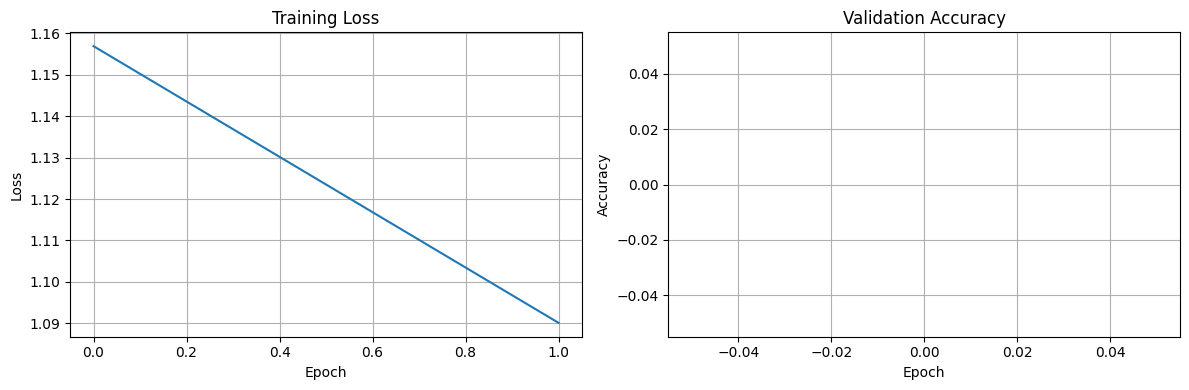

In [17]:
# TODO: Set your hyperparameters here

max_length = 768
batch_size = 1  # Try 2, 4, or 8
gradient_accumulation_steps = 32  # Try 4 or 8
learning_rate = 2e-5 # Try 1e-4, 5e-5, or 1e-5
max_epochs = 2  # Try 5-10
patience = 2  # Try 2 or 3
lora_r = 4  # Try 8, 16, or 32
lora_drop =0.05  # Try 0.05 or 0.1
lora_alpha=16

# Free GPU memory and reload a fresh model for fine-tuning
# This is to ensure that if you run this cell multiple times
# with different hyperparameters, you always start from the
# clean original pretrained model (not a partially fine-tuned one)
import gc
del model
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

#model_id = google/gemma-3-270m-it
#tpu_device = xm.xla_device()
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="cuda"
)
model.to(device)
model.config.use_flash_attn = False

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

model.config.pad_token_id = tokenizer.pad_token_id

print("Fresh model loaded and ready for fine-tuning")

# Run training
model = train_math(
    model=model,
    tokenizer=tokenizer,
    train_data=math_train,
    val_data=math_val, #turn off for now (storage issues)
    test_data=math_test,
    batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    learning_rate=learning_rate,
    max_epochs=max_epochs,
    patience=patience,
    lora_r=lora_r,
    lora_drop=lora_drop
)

# Ablation Study

diff loRA params

# Deploying with Streamlit

In [ ]:
!pip install streamlit

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

base_model_id = "google/gemma-3-270m-it"  # or your gemma3 model_id

# 1. Load base pretrained model
base = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype="auto",
    device_map="cpu"
)

# 2. Load your adapter weights
model = PeftModel.from_pretrained(base, "./math_checkpoints/checkpoint-313")

# 3. Merge LoRA → full model
model = model.merge_and_unload()

# 4. Save full merged model
model.save_pretrained("final_sft_model")
tokenizer = AutoTokenizer.from_pretrained(base_model_id)
tokenizer.save_pretrained("final_sft_model")

print("Merged model saved to final_sft_model/")


In [ ]:
%%writefile app.py
import streamlit as st
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_PATH = "final_sft_model"

@st.cache_resource
def load_model():
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_PATH,
        trust_remote_code=True,
        fix_mistral_regex=True
    )
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_PATH,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
    return tokenizer, model

tokenizer, model = load_model()


In [ ]:
!streamlit run app.py
